## Analysis of models robustness to JPG compression

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

# the name of the base dataset models trained on this data are tested using other datasets
# (e.g. "standard" for the standard dataset)
base_perturbed_name = "standardAugmented"

perturbed_paths = [
                   "data/features/synthbuster/standard",
                   "data/features/synthbuster_gauss/sigma_1",
                   "data/features/synthbuster_gauss/sigma_2",
                   "data/features/synthbuster_gauss/sigma_3",
                ]

perturbed_data = {}
for data_path in perturbed_paths:
    suffix = "features/extraction_params/train_test/features_RGB.csv"
    dalle2 = pd.read_csv(os.path.join(data_path, "dalle2", suffix), index_col=0)
    dalle3 = pd.read_csv(os.path.join(data_path, "dalle3", suffix), index_col=0)
    firefly = pd.read_csv(os.path.join(data_path, "firefly", suffix), index_col=0)
    glide = pd.read_csv(os.path.join(data_path, "glide", suffix), index_col=0)
    img = pd.read_csv(os.path.join(data_path, "img", suffix), index_col=0)
    midjourney = pd.read_csv(os.path.join(data_path, "midjourney-v5", suffix), index_col=0)
    sd_1_3 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-3", suffix), index_col=0)
    sd_1_4 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-4", suffix), index_col=0)
    sd_2 = pd.read_csv(os.path.join(data_path, "stable-diffusion-2", suffix), index_col=0)
    sd_xl = pd.read_csv(os.path.join(data_path, "stable-diffusion-xl", suffix), index_col=0)

    datasets_train = {
        "dalle2": dalle2,
        "dalle3": dalle3,
        "firefly": firefly,
        "glide": glide,
        "midjourney": midjourney,
        "sd_1_3": sd_1_3,
        "sd_1_4": sd_1_4,
        "sd_2": sd_2,
        "sd_xl": sd_xl,
    }
    
    for dataset_name, dataset in datasets_train.items():
        datasets_train[dataset_name] = pd.concat([datasets_train[dataset_name], img])
        
    perturbed_data[data_path.split("/")[-1]] = datasets_train

## Data preparation

In [4]:
def drop_columns(df, drop_only_diagnostic=False):
    to_drop = list()
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            to_drop.append(column)
        elif 'diagnostics' in column:
            to_drop.append(column)
        elif 'Mask' in column:
            to_drop.append(column)
        elif 'Image' in column:
            to_drop.append(column)
    df.drop(to_drop, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [5]:
# We drop only columns from train set
for key, datasets_train in perturbed_data.items():
    for key, df in datasets_train.items():
        preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [6]:
from sklearn.model_selection import train_test_split

perturbed_X_train = {}
perturbed_X_val = {}
perturbed_X_test = {}

perturbed_y_train = {}
perturbed_y_val = {}
perturbed_y_test = {}

for perturbed_name, datasets_train in perturbed_data.items():
    X_train = {}
    X_val = {}
    X_test = {}

    y_train = {}
    y_val = {}
    y_test = {}

    for key, df in datasets_train.items():
        X = df.drop('Category', axis=1)
        y = df['Category']
        
        # get train, val and test sets
        X_train[key], X_test[key], y_train[key], y_test[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
        X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X_train[key], y_train[key], test_size=0.2, random_state=SEED)
        
    # create dataset combining all train sets
    X_train_all = pd.concat([X_train[key] for key in datasets_train.keys()])
    y_train_all = pd.concat([y_train[key] for key in datasets_train.keys()])

    # create dataset combining all val sets
    X_val_all = pd.concat([X_val[key] for key in datasets_train.keys()])
    y_val_all = pd.concat([y_val[key] for key in datasets_train.keys()])

    # create dataset combining all test sets
    X_test_all = pd.concat([X_test[key] for key in datasets_train.keys()])
    y_test_all = pd.concat([y_test[key] for key in datasets_train.keys()])

    X_train['combined'] = X_train_all
    y_train['combined'] = y_train_all

    X_val['combined'] = X_val_all
    y_val['combined'] = y_val_all

    X_test['combined'] = X_test_all
    y_test['combined'] = y_test_all
    
    perturbed_X_train[perturbed_name] = X_train
    perturbed_X_val[perturbed_name] = X_val
    perturbed_X_test[perturbed_name] = X_test
    
    perturbed_y_train[perturbed_name] = y_train
    perturbed_y_val[perturbed_name] = y_val
    perturbed_y_test[perturbed_name] = y_test
    

### Scale the data using loaded scaler

In [7]:
import joblib

scalers = {}
X_train_scaled = {}
for key in X_train.keys():
    # Load scaler (MinMaxScaler) the suffix with model name is redundant since scaler is fitted to the data and is not model specific
    scalers[key] = joblib.load(f"scalers/synthbuster/{base_perturbed_name}/{key}/{key}_HistGradientBoostingClassifier.joblib")
    X_train_scaled[key] = scalers[key].transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Loading trained models

In [8]:
models = {}
for dataset_name in X_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_HistGradientBoostingClassifier.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_LinearDiscriminantAnalysis.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_RandomForestClassifier.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_LinearSVC.joblib"),
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        print(f"Loaded model: {name}")
        print(f"Train score: {model.score(X_train_scaled[dataset_name], y_train[dataset_name])}")
        
    models[dataset_name] = model_temp_dict



Training set: dalle2

Loaded model: HistGradientBoostingClassifier
Train score: 0.86484375
Loaded model: LinearDiscriminantAnalysis
Train score: 0.9265625
Loaded model: RandomForestClassifier
Train score: 0.83046875
Loaded model: LinearSVC
Train score: 0.8625


Training set: dalle3

Loaded model: HistGradientBoostingClassifier
Train score: 0.97265625
Loaded model: LinearDiscriminantAnalysis
Train score: 0.97578125
Loaded model: RandomForestClassifier
Train score: 0.946875
Loaded model: LinearSVC
Train score: 0.98203125


Training set: firefly

Loaded model: HistGradientBoostingClassifier
Train score: 0.93515625
Loaded model: LinearDiscriminantAnalysis
Train score: 0.953125
Loaded model: RandomForestClassifier
Train score: 0.9203125
Loaded model: LinearSVC
Train score: 0.91953125


Training set: glide

Loaded model: HistGradientBoostingClassifier
Train score: 0.93203125
Loaded model: LinearDiscriminantAnalysis
Train score: 0.9671875
Loaded model: RandomForestClassifier
Train score: 0.

## Evaluation

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

In [10]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy", perturbed_name="standard"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes
    df_pivot = df_pivot.reindex(index=X_train.keys())
    df_pivot = df_pivot.reindex(columns=X_train.keys())

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"{name} - {metric} - {perturbed_name}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg


## Validation data

In [12]:
perturbed_results = {}   

for perturbed_name, X_val, y_val in zip(perturbed_X_val.keys(), perturbed_X_val.values(), perturbed_y_val.values()):
    results = {}
    X_train = perturbed_X_train["standard"]
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    for dataset_name in models.keys():
        print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
        for val_dataset_name in X_val.keys():
            print(f"\n\nValidation set: {val_dataset_name}")
            for model_name, model in models[dataset_name].items():
                print()  
                X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
                X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
                accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
                model_results = {
                    "accuracy": accuracy,
                    "f1": f1,
                    "precision": precision,
                    "recall": recall,
                    "mcc": mcc
                }
                results[(dataset_name, val_dataset_name, model_name)] = model_results
    
    perturbed_results[perturbed_name] = results
            









 ################ Evaluating models trained on standardAugmented and tested on standard. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9938
F1: 0.9938
Precision: 0.9938
Recall: 0.9938
MCC: 0.9875

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.8594
F1: 0.8569
Precision: 0.8907
Recall: 0.8594
MCC: 0.7501

Model: LinearDiscriminantAnalysis
Accuracy: 0.8875
F1: 0.8864
Precision: 0.9061
Recall: 0.8875
MCC: 0.7938

Model: RandomForestClassifier
Accuracy: 0.8438
F1: 0.8403
Precision: 0.8815
Recall: 0.8438
MCC: 0.7251

Model: LinearSVC
Accuracy: 0.9625
F1: 0.9625
P

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5406
F1: 0.4330
Precision: 0.7119
Recall: 0.5406
MCC: 0.2018

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3791
Precision: 0.6629
Recall: 0.5125
MCC: 0.1165

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: glide



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9938
F1: 0.9937
Precision: 0.9938
Recall: 0.9938
MCC: 0.9876

Model: RandomForestClassifier
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: LinearSVC
Accuracy: 0.9938
F1: 0.9937
Precision: 0.9938
Recall: 0.9938
MCC: 0.9876


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4938
F1: 0.3404
Precision: 0.5470
Recall: 0.4938
MCC: 0.0228



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5563
F1: 0.4611
Precision: 0.7264
Recall: 0.5563
MCC: 0.2391

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4875
F1: 0.3270
Precision: 0.4097
Recall: 0.4875
MCC: -0.0343


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5656
F1: 0.4774
Precision: 0.7334
Recall: 0.5656
MCC: 0.2597



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3404
Precision: 0.5470
Recall: 0.4938
MCC: 0.0228


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.6625
F1: 0.6254
Precision: 0.7835
Recall: 0.6625
MCC: 0.4344

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5406
F1: 0.4330
Precision: 0.7119
Recall: 0.5406
MCC: 0.2018


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5625
F1: 0.4720
Precision: 0.7312
Recall: 0.5625
MCC: 0.2529



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4844
F1: 0.3202
Precision: 0.2391
Recall: 0.4844
MCC: -0.0808


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404

Model: LinearDiscriminantAnalysis
Accuracy: 0.5969
F1: 0.5289
Precision: 0.7522
Recall: 0.5969
MCC: 0.3216

Model: RandomForestClassifier
Accuracy: 0.5469
F1: 0.4369
Precision: 0.7644
Recall: 0.5469
MCC: 0.2396

Model: LinearSVC
Accuracy: 0.5486
F1: 0.4475
Precision: 0.7199
Recall: 0.5486
MCC: 0.2214




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9719
F1: 0.9719
Precision: 0.9728
Recall: 0.9719
MCC: 0.9447

Model: LinearDiscriminantAnalysis
Accuracy: 0.7719
F1: 0.7605
Precision: 0.8443
Recall: 0.7719
MCC: 0.6139

Model: RandomForestClassifier
Accuracy: 0.8500
F1: 0.8473
Preci

### Accuracy - Validation

########################### Accuracy ###########################








 ################ Evaluating models trained on standardAugmented and tested on standard. ################


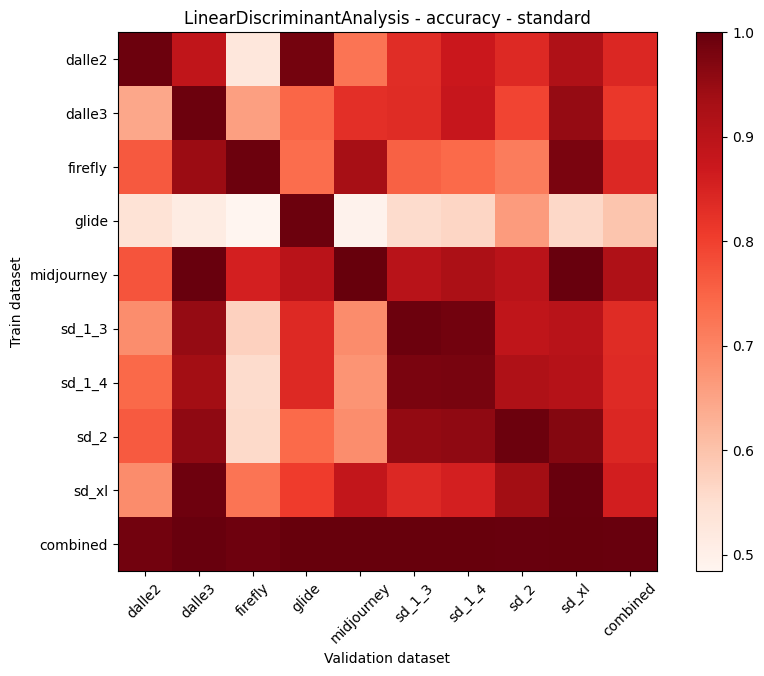

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.887500  0.528125  0.984375    0.725000  0.831250   
dalle3         0.643750  0.993750  0.656250  0.746875    0.828125  0.834375   
firefly        0.765625  0.943750  0.993750  0.737500    0.931250  0.753125   
glide          0.540625  0.512500  0.484375  0.993750    0.493750  0.556250   
midjourney     0.771875  0.996875  0.856250  0.900000    1.000000  0.903125   
sd_1_3         0.684375  0.950000  0.575000  0.837500    0.687500  0.993750   
sd_1_4         0.743750  0.937500  0.556250  0.837500    0.675000  0.978125   
sd_2           0.762500  0.956250  0.559375  0.740625    0.684375  0.953125   
sd_xl          0.687500  0.990625  0.725000  0.806250    0.884375  0.840625   
combined       0.987500  0.996875  0.990625  1.000000    1.000000  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.871875  0.837500  0.915625  0.841667  
dalle3         0.878125  0.793750  0.950000  0.813889  
firefly        0.740625  0.712500  0.978125  0.839583  
glide          0.565625  0.662500  0.562500  0.596875  
midjourney     0.921875  0.900000  0.996875  0.916319  
sd_1_3         0.987500  0.890625  0.903125  0.834375  
sd_1_4         0.981250  0.915625  0.906250  0.836806  
sd_2           0.956250  0.993750  0.968750  0.841667  
sd_xl          0.856250  0.937500  0.996875  0.858333  
combined       1.000000  0.996875  1.000000  0.996875

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.887500  0.528125  0.984375    0.725000  0.831250   
dalle3         0.643750  0.993750  0.656250  0.746875    0.828125  0.834375   
firefly        0.765625  0.943750  0.993750  0.737500    0.931250  0.753125   
glide          0.540625  0.512500  0.484375  0.993750    0.493750  0.556250   
midjourney     0.771875  0.996875  0.856250  0.900000    1.000000  0.903125   
sd_1_3         0.684375  0.950000  0.575000  0.837500    0.687500  0.993750   
sd_1_4         0.743750  0.937500  0.556250  0.837500    0.675000  0.978125   
sd_2           0.762500  0.956250  0.559375  0.740625    0.684375  0.953125   
sd_xl          0.687500  0.990625  0.725000  0.806250    0.884375  0.840625   
combined       0.987500  0.996875  0.990625  1.000000    1.000000  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.871875  0.837500  0.915625  0.841667  
dalle3         0.878125  0.793750  0.950000  0.813889  
firefly        0.740625  0.712500  0.978125  0.839583  
glide          0.565625  0.662500  0.562500  0.596875  
midjourney     0.921875  0.900000  0.996875  0.916319  
sd_1_3         0.987500  0.890625  0.903125  0.834375  
sd_1_4         0.981250  0.915625  0.906250  0.836806  
sd_2           0.956250  0.993750  0.968750  0.841667  
sd_xl          0.856250  0.937500  0.996875  0.858333  
combined       1.000000  0.996875  1.000000  0.996875

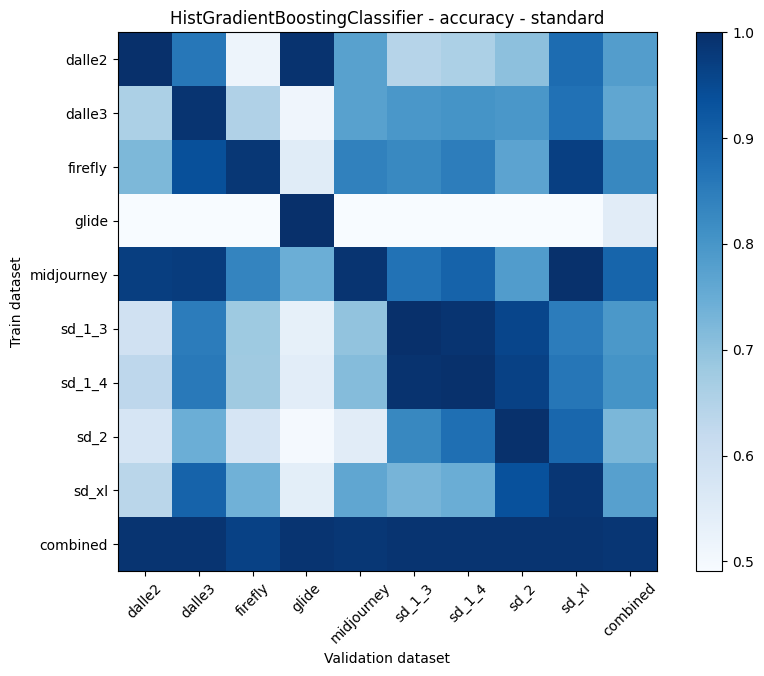

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.859375  0.515625  0.993750    0.775000  0.643750   
dalle3         0.659375  0.990625  0.653125  0.512500    0.775000  0.796875   
firefly        0.721875  0.937500  0.984375  0.550000    0.840625  0.825000   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.971875  0.975000  0.834375  0.743750    0.990625  0.868750   
sd_1_3         0.590625  0.850000  0.681250  0.534375    0.696875  1.000000   
sd_1_4         0.631250  0.856250  0.678125  0.543750    0.712500  0.993750   
sd_2           0.575000  0.743750  0.575000  0.496875    0.546875  0.828125   
sd_xl          0.637500  0.900000  0.737500  0.540625    0.762500  0.731250   
combined       0.990625  0.990625  0.965625  0.990625    0.984375  0.990625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.659375  0.703125  0.881250  0.781250  
dalle3         0.803125  0.796875  0.871875  0.762153  
firefly        0.846875  0.768750  0.968750  0.827083  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.900000  0.784375  0.996875  0.896181  
sd_1_3         0.990625  0.956250  0.850000  0.794444  
sd_1_4         0.996875  0.965625  0.862500  0.804514  
sd_2           0.875000  0.996875  0.890625  0.725347  
sd_xl          0.746875  0.934375  0.987500  0.775347  
combined       0.990625  0.990625  0.990625  0.987153

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.859375  0.515625  0.993750    0.775000  0.643750   
dalle3         0.659375  0.990625  0.653125  0.512500    0.775000  0.796875   
firefly        0.721875  0.937500  0.984375  0.550000    0.840625  0.825000   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.971875  0.975000  0.834375  0.743750    0.990625  0.868750   
sd_1_3         0.590625  0.850000  0.681250  0.534375    0.696875  1.000000   
sd_1_4         0.631250  0.856250  0.678125  0.543750    0.712500  0.993750   
sd_2           0.575000  0.743750  0.575000  0.496875    0.546875  0.828125   
sd_xl          0.637500  0.900000  0.737500  0.540625    0.762500  0.731250   
combined       0.990625  0.990625  0.965625  0.990625    0.984375  0.990625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.659375  0.703125  0.881250  0.781250  
dalle3         0.803125  0.796875  0.871875  0.762153  
firefly        0.846875  0.768750  0.968750  0.827083  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.900000  0.784375  0.996875  0.896181  
sd_1_3         0.990625  0.956250  0.850000  0.794444  
sd_1_4         0.996875  0.965625  0.862500  0.804514  
sd_2           0.875000  0.996875  0.890625  0.725347  
sd_xl          0.746875  0.934375  0.987500  0.775347  
combined       0.990625  0.990625  0.990625  0.987153

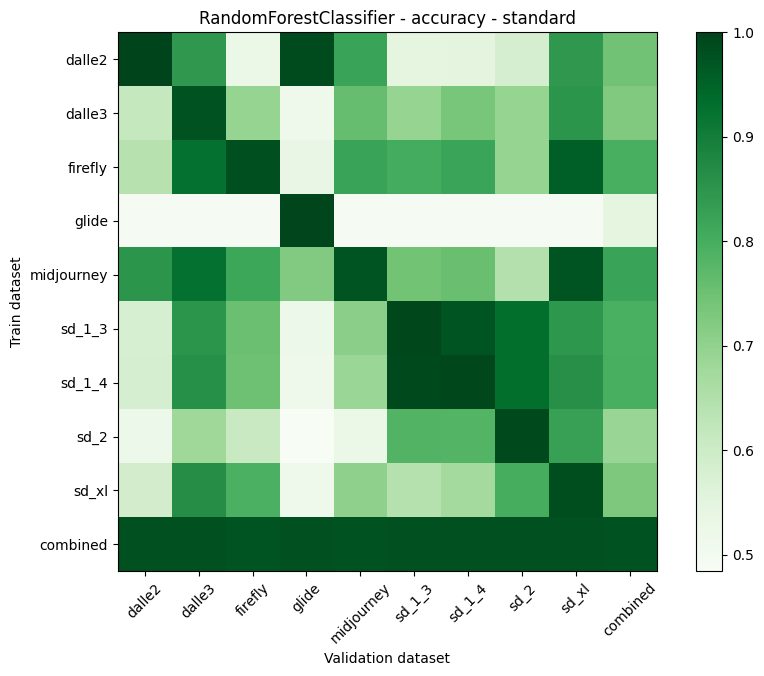

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.843750  0.525000  0.987500    0.821875  0.546875   
dalle3         0.615625  0.975000  0.693750  0.515625    0.759375  0.693750   
firefly        0.640625  0.925000  0.981250  0.534375    0.821875  0.803125   
glide          0.490625  0.490625  0.490625  0.996875    0.490625  0.490625   
midjourney     0.850000  0.925000  0.815625  0.721875    0.971875  0.743750   
sd_1_3         0.578125  0.850000  0.753125  0.521875    0.709375  0.993750   
sd_1_4         0.581250  0.859375  0.750000  0.515625    0.687500  0.990625   
sd_2           0.521875  0.678125  0.609375  0.484375    0.528125  0.784375   
sd_xl          0.587500  0.865625  0.790625  0.515625    0.703125  0.643750   
combined       0.978125  0.978125  0.971875  0.978125    0.975000  0.978125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.550000  0.581250  0.843750  0.744444  
dalle3         0.734375  0.693750  0.850000  0.725694  
firefly        0.818750  0.693750  0.956250  0.797222  
glide          0.490625  0.490625  0.490625  0.546875  
midjourney     0.756250  0.646875  0.971875  0.822569  
sd_1_3         0.971875  0.931250  0.846875  0.795139  
sd_1_4         0.993750  0.931250  0.862500  0.796875  
sd_2           0.781250  0.990625  0.828125  0.689583  
sd_xl          0.671875  0.800000  0.984375  0.729167  
combined       0.978125  0.978125  0.978125  0.977083

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.843750  0.525000  0.987500    0.821875  0.546875   
dalle3         0.615625  0.975000  0.693750  0.515625    0.759375  0.693750   
firefly        0.640625  0.925000  0.981250  0.534375    0.821875  0.803125   
glide          0.490625  0.490625  0.490625  0.996875    0.490625  0.490625   
midjourney     0.850000  0.925000  0.815625  0.721875    0.971875  0.743750   
sd_1_3         0.578125  0.850000  0.753125  0.521875    0.709375  0.993750   
sd_1_4         0.581250  0.859375  0.750000  0.515625    0.687500  0.990625   
sd_2           0.521875  0.678125  0.609375  0.484375    0.528125  0.784375   
sd_xl          0.587500  0.865625  0.790625  0.515625    0.703125  0.643750   
combined       0.978125  0.978125  0.971875  0.978125    0.975000  0.978125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.550000  0.581250  0.843750  0.744444  
dalle3         0.734375  0.693750  0.850000  0.725694  
firefly        0.818750  0.693750  0.956250  0.797222  
glide          0.490625  0.490625  0.490625  0.546875  
midjourney     0.756250  0.646875  0.971875  0.822569  
sd_1_3         0.971875  0.931250  0.846875  0.795139  
sd_1_4         0.993750  0.931250  0.862500  0.796875  
sd_2           0.781250  0.990625  0.828125  0.689583  
sd_xl          0.671875  0.800000  0.984375  0.729167  
combined       0.978125  0.978125  0.978125  0.977083

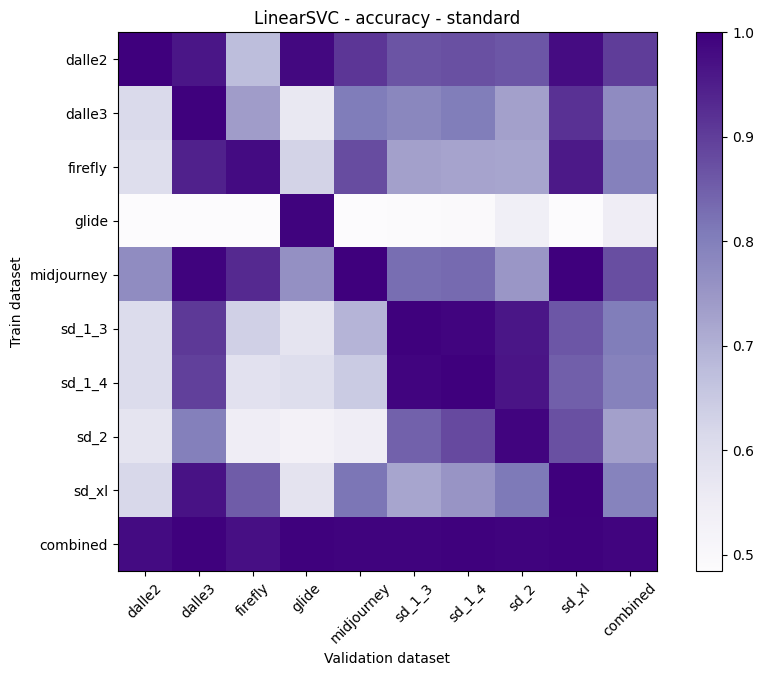

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.962500  0.675000  0.984375    0.909375  0.865625   
dalle3         0.612500  0.996875  0.737500  0.565625    0.806250  0.784375   
firefly        0.600000  0.943750  0.981250  0.628125    0.878125  0.731250   
glide          0.484375  0.484375  0.484375  0.993750    0.484375  0.487500   
midjourney     0.771875  0.993750  0.931250  0.762500    1.000000  0.828125   
sd_1_3         0.606250  0.906250  0.634375  0.578125    0.693750  0.996875   
sd_1_4         0.606250  0.896875  0.587500  0.600000    0.646875  0.990625   
sd_2           0.578125  0.796875  0.546875  0.528125    0.546875  0.846875   
sd_xl          0.615625  0.968750  0.853125  0.581250    0.815625  0.721875   
combined       0.981250  0.996875  0.971875  0.996875    0.993750  0.993750   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.871875  0.862500  0.978125  0.901042  
dalle3         0.803125  0.731250  0.918750  0.772917  
firefly        0.725000  0.721875  0.956250  0.796181  
glide          0.493750  0.540625  0.484375  0.548611  
midjourney     0.834375  0.750000  1.000000  0.874653  
sd_1_3         0.990625  0.962500  0.862500  0.803472  
sd_1_4         1.000000  0.965625  0.850000  0.793750  
sd_2           0.881250  0.990625  0.871875  0.731944  
sd_xl          0.753125  0.809375  1.000000  0.790972  
combined       0.996875  0.993750  0.996875  0.991319

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.962500  0.675000  0.984375    0.909375  0.865625   
dalle3         0.612500  0.996875  0.737500  0.565625    0.806250  0.784375   
firefly        0.600000  0.943750  0.981250  0.628125    0.878125  0.731250   
glide          0.484375  0.484375  0.484375  0.993750    0.484375  0.487500   
midjourney     0.771875  0.993750  0.931250  0.762500    1.000000  0.828125   
sd_1_3         0.606250  0.906250  0.634375  0.578125    0.693750  0.996875   
sd_1_4         0.606250  0.896875  0.587500  0.600000    0.646875  0.990625   
sd_2           0.578125  0.796875  0.546875  0.528125    0.546875  0.846875   
sd_xl          0.615625  0.968750  0.853125  0.581250    0.815625  0.721875   
combined       0.981250  0.996875  0.971875  0.996875    0.993750  0.993750   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.871875  0.862500  0.978125  0.901042  
dalle3         0.803125  0.731250  0.918750  0.772917  
firefly        0.725000  0.721875  0.956250  0.796181  
glide          0.493750  0.540625  0.484375  0.548611  
midjourney     0.834375  0.750000  1.000000  0.874653  
sd_1_3         0.990625  0.962500  0.862500  0.803472  
sd_1_4         1.000000  0.965625  0.850000  0.793750  
sd_2           0.881250  0.990625  0.871875  0.731944  
sd_xl          0.753125  0.809375  1.000000  0.790972  
combined       0.996875  0.993750  0.996875  0.991319









 ################ Evaluating models trained on standardAugmented and tested on sigma_1. ################


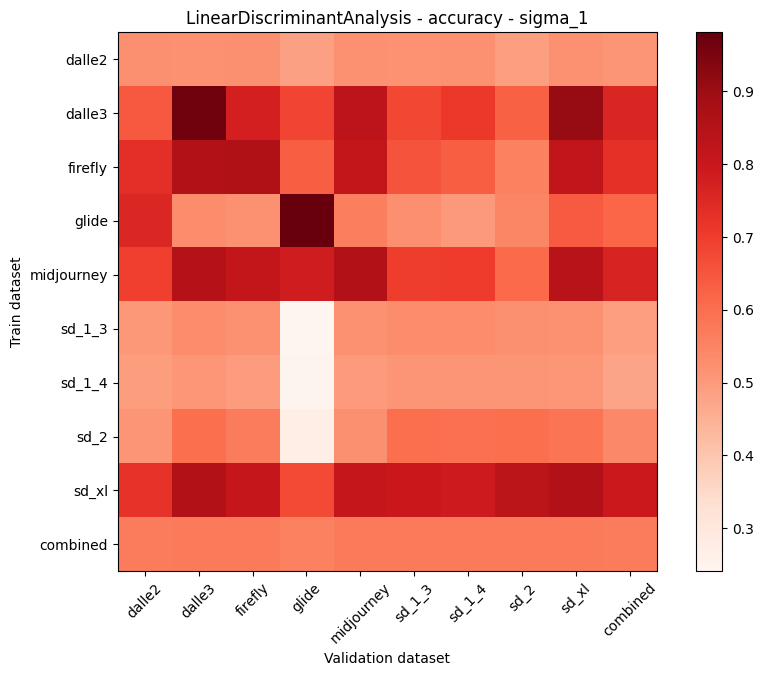

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.521875  0.518750  0.521875  0.484375    0.518750  0.515625   
dalle3         0.643750  0.965625  0.775000  0.684375    0.828125  0.678125   
firefly        0.734375  0.859375  0.862500  0.631250    0.815625  0.656250   
glide          0.753125  0.528125  0.518750  0.981250    0.559375  0.525000   
midjourney     0.693750  0.850000  0.815625  0.784375    0.859375  0.700000   
sd_1_3         0.506250  0.528125  0.518750  0.240625    0.518750  0.528125   
sd_1_4         0.493750  0.509375  0.496875  0.243750    0.500000  0.512500   
sd_2           0.512500  0.596875  0.568750  0.271875    0.521875  0.600000   
sd_xl          0.725000  0.856250  0.812500  0.671875    0.809375  0.796875   
combined       0.568750  0.571875  0.571875  0.556250    0.571875  0.571875   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.518750  0.490625  0.518750  0.512153  
dalle3         0.709375  0.628125  0.906250  0.757639  
firefly        0.631250  0.556250  0.821875  0.729861  
glide          0.503125  0.546875  0.640625  0.617361  
midjourney     0.703125  0.606250  0.843750  0.761806  
sd_1_3         0.528125  0.521875  0.518750  0.489931  
sd_1_4         0.512500  0.512500  0.509375  0.476736  
sd_2           0.593750  0.600000  0.584375  0.538889  
sd_xl          0.787500  0.831250  0.859375  0.794444  
combined       0.571875  0.571875  0.571875  0.569792

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.521875  0.518750  0.521875  0.484375    0.518750  0.515625   
dalle3         0.643750  0.965625  0.775000  0.684375    0.828125  0.678125   
firefly        0.734375  0.859375  0.862500  0.631250    0.815625  0.656250   
glide          0.753125  0.528125  0.518750  0.981250    0.559375  0.525000   
midjourney     0.693750  0.850000  0.815625  0.784375    0.859375  0.700000   
sd_1_3         0.506250  0.528125  0.518750  0.240625    0.518750  0.528125   
sd_1_4         0.493750  0.509375  0.496875  0.243750    0.500000  0.512500   
sd_2           0.512500  0.596875  0.568750  0.271875    0.521875  0.600000   
sd_xl          0.725000  0.856250  0.812500  0.671875    0.809375  0.796875   
combined       0.568750  0.571875  0.571875  0.556250    0.571875  0.571875   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.518750  0.490625  0.518750  0.512153  
dalle3         0.709375  0.628125  0.906250  0.757639  
firefly        0.631250  0.556250  0.821875  0.729861  
glide          0.503125  0.546875  0.640625  0.617361  
midjourney     0.703125  0.606250  0.843750  0.761806  
sd_1_3         0.528125  0.521875  0.518750  0.489931  
sd_1_4         0.512500  0.512500  0.509375  0.476736  
sd_2           0.593750  0.600000  0.584375  0.538889  
sd_xl          0.787500  0.831250  0.859375  0.794444  
combined       0.571875  0.571875  0.571875  0.569792

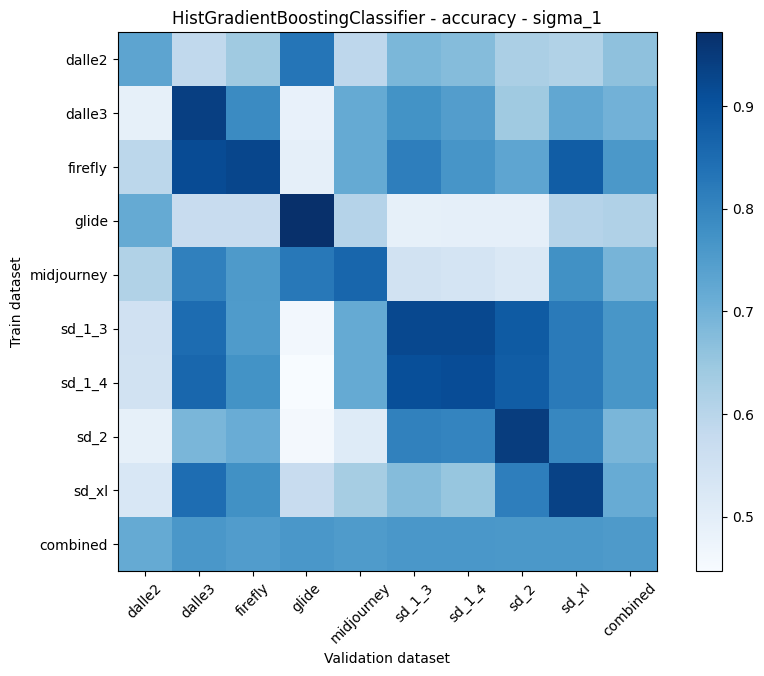

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.731250  0.584375  0.640625  0.831250    0.590625  0.687500   
dalle3         0.490625  0.940625  0.787500  0.484375    0.718750  0.771875   
firefly        0.593750  0.915625  0.925000  0.493750    0.718750  0.812500   
glide          0.718750  0.571875  0.571875  0.971875    0.606250  0.490625   
midjourney     0.612500  0.809375  0.756250  0.825000    0.862500  0.546875   
sd_1_3         0.550000  0.850000  0.753125  0.459375    0.718750  0.921875   
sd_1_4         0.546875  0.859375  0.771875  0.446875    0.718750  0.909375   
sd_2           0.490625  0.690625  0.712500  0.456250    0.512500  0.806250   
sd_xl          0.528125  0.846875  0.775000  0.571875    0.631250  0.675000   
combined       0.718750  0.762500  0.750000  0.762500    0.753125  0.762500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.675000  0.621875  0.612500  0.663889  
dalle3         0.746875  0.640625  0.725000  0.700694  
firefly        0.765625  0.728125  0.881250  0.759375  
glide          0.493750  0.493750  0.606250  0.613889  
midjourney     0.537500  0.521875  0.775000  0.694097  
sd_1_3         0.921875  0.884375  0.821875  0.764583  
sd_1_4         0.912500  0.881250  0.821875  0.763194  
sd_2           0.800000  0.943750  0.796875  0.689931  
sd_xl          0.653125  0.812500  0.934375  0.714236  
combined       0.762500  0.759375  0.759375  0.754514

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.731250  0.584375  0.640625  0.831250    0.590625  0.687500   
dalle3         0.490625  0.940625  0.787500  0.484375    0.718750  0.771875   
firefly        0.593750  0.915625  0.925000  0.493750    0.718750  0.812500   
glide          0.718750  0.571875  0.571875  0.971875    0.606250  0.490625   
midjourney     0.612500  0.809375  0.756250  0.825000    0.862500  0.546875   
sd_1_3         0.550000  0.850000  0.753125  0.459375    0.718750  0.921875   
sd_1_4         0.546875  0.859375  0.771875  0.446875    0.718750  0.909375   
sd_2           0.490625  0.690625  0.712500  0.456250    0.512500  0.806250   
sd_xl          0.528125  0.846875  0.775000  0.571875    0.631250  0.675000   
combined       0.718750  0.762500  0.750000  0.762500    0.753125  0.762500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.675000  0.621875  0.612500  0.663889  
dalle3         0.746875  0.640625  0.725000  0.700694  
firefly        0.765625  0.728125  0.881250  0.759375  
glide          0.493750  0.493750  0.606250  0.613889  
midjourney     0.537500  0.521875  0.775000  0.694097  
sd_1_3         0.921875  0.884375  0.821875  0.764583  
sd_1_4         0.912500  0.881250  0.821875  0.763194  
sd_2           0.800000  0.943750  0.796875  0.689931  
sd_xl          0.653125  0.812500  0.934375  0.714236  
combined       0.762500  0.759375  0.759375  0.754514

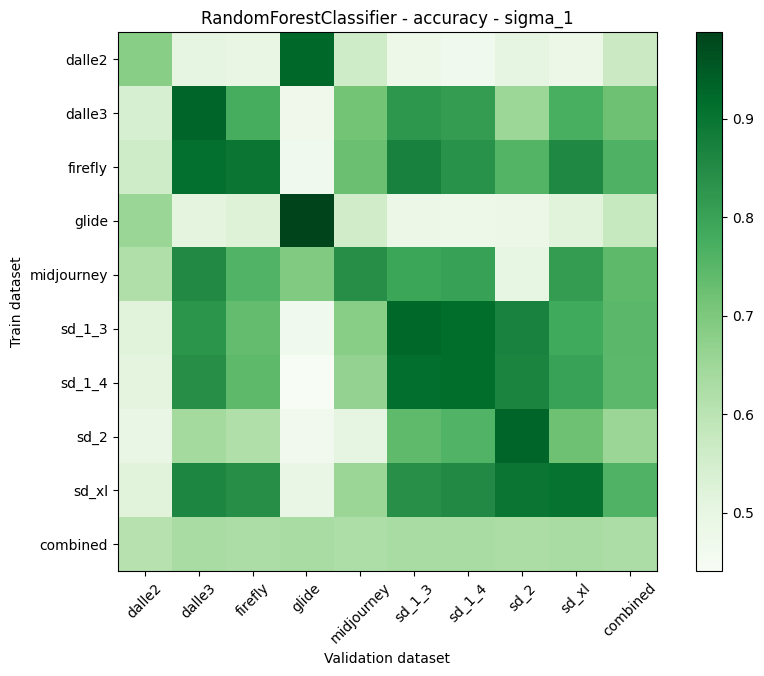

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.681250  0.506250  0.496875  0.925000    0.559375  0.478125   
dalle3         0.540625  0.931250  0.775000  0.471875    0.712500  0.825000   
firefly        0.559375  0.909375  0.896875  0.465625    0.725000  0.871875   
glide          0.656250  0.509375  0.525000  0.987500    0.556250  0.481250   
midjourney     0.618750  0.853125  0.759375  0.693750    0.843750  0.793750   
sd_1_3         0.518750  0.828125  0.734375  0.465625    0.681250  0.925000   
sd_1_4         0.509375  0.843750  0.743750  0.440625    0.665625  0.912500   
sd_2           0.490625  0.640625  0.618750  0.462500    0.506250  0.740625   
sd_xl          0.515625  0.859375  0.843750  0.493750    0.653125  0.840625   
combined       0.606250  0.631250  0.625000  0.631250    0.621875  0.631250   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.465625  0.506250  0.481250  0.566667  
dalle3         0.812500  0.650000  0.771875  0.721181  
firefly        0.834375  0.756250  0.856250  0.763889  
glide          0.478125  0.481250  0.518750  0.577083  
midjourney     0.803125  0.500000  0.812500  0.742014  
sd_1_3         0.915625  0.868750  0.784375  0.746875  
sd_1_4         0.915625  0.865625  0.800000  0.744097  
sd_2           0.759375  0.931250  0.721875  0.652431  
sd_xl          0.853125  0.896875  0.903125  0.762153  
combined       0.631250  0.628125  0.631250  0.626389

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.681250  0.506250  0.496875  0.925000    0.559375  0.478125   
dalle3         0.540625  0.931250  0.775000  0.471875    0.712500  0.825000   
firefly        0.559375  0.909375  0.896875  0.465625    0.725000  0.871875   
glide          0.656250  0.509375  0.525000  0.987500    0.556250  0.481250   
midjourney     0.618750  0.853125  0.759375  0.693750    0.843750  0.793750   
sd_1_3         0.518750  0.828125  0.734375  0.465625    0.681250  0.925000   
sd_1_4         0.509375  0.843750  0.743750  0.440625    0.665625  0.912500   
sd_2           0.490625  0.640625  0.618750  0.462500    0.506250  0.740625   
sd_xl          0.515625  0.859375  0.843750  0.493750    0.653125  0.840625   
combined       0.606250  0.631250  0.625000  0.631250    0.621875  0.631250   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.465625  0.506250  0.481250  0.566667  
dalle3         0.812500  0.650000  0.771875  0.721181  
firefly        0.834375  0.756250  0.856250  0.763889  
glide          0.478125  0.481250  0.518750  0.577083  
midjourney     0.803125  0.500000  0.812500  0.742014  
sd_1_3         0.915625  0.868750  0.784375  0.746875  
sd_1_4         0.915625  0.865625  0.800000  0.744097  
sd_2           0.759375  0.931250  0.721875  0.652431  
sd_xl          0.853125  0.896875  0.903125  0.762153  
combined       0.631250  0.628125  0.631250  0.626389

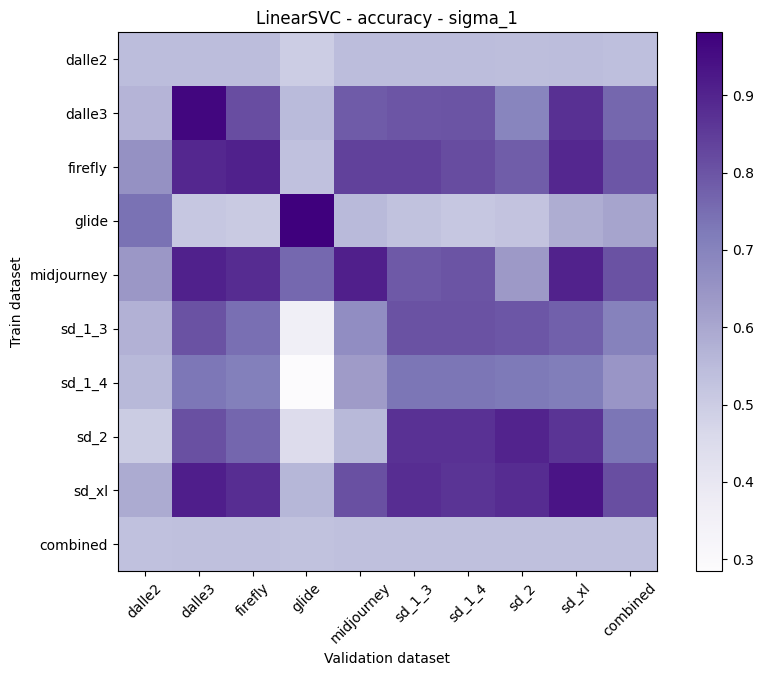

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.543750  0.543750  0.543750  0.496875    0.543750  0.543750   
dalle3         0.565625  0.965625  0.812500  0.550000    0.787500  0.796875   
firefly        0.659375  0.893750  0.906250  0.534375    0.837500  0.837500   
glide          0.740625  0.515625  0.506250  0.981250    0.553125  0.531250   
midjourney     0.640625  0.906250  0.881250  0.759375    0.909375  0.790625   
sd_1_3         0.575000  0.803125  0.746875  0.359375    0.668750  0.803125   
sd_1_4         0.556250  0.728125  0.709375  0.284375    0.628125  0.731250   
sd_2           0.500000  0.809375  0.765625  0.446875    0.556250  0.871875   
sd_xl          0.590625  0.912500  0.878125  0.559375    0.809375  0.878125   
combined       0.534375  0.537500  0.537500  0.531250    0.537500  0.537500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.543750  0.540625  0.543750  0.538194  
dalle3         0.800000  0.693750  0.875000  0.760764  
firefly        0.815625  0.781250  0.893750  0.795486  
glide          0.515625  0.525000  0.584375  0.605903  
midjourney     0.800000  0.634375  0.903125  0.802778  
sd_1_3         0.803125  0.793750  0.775000  0.703125  
sd_1_4         0.731250  0.725000  0.715625  0.645486  
sd_2           0.871875  0.900000  0.865625  0.731944  
sd_xl          0.865625  0.881250  0.934375  0.812153  
combined       0.537500  0.537500  0.537500  0.536458

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.543750  0.543750  0.543750  0.496875    0.543750  0.543750   
dalle3         0.565625  0.965625  0.812500  0.550000    0.787500  0.796875   
firefly        0.659375  0.893750  0.906250  0.534375    0.837500  0.837500   
glide          0.740625  0.515625  0.506250  0.981250    0.553125  0.531250   
midjourney     0.640625  0.906250  0.881250  0.759375    0.909375  0.790625   
sd_1_3         0.575000  0.803125  0.746875  0.359375    0.668750  0.803125   
sd_1_4         0.556250  0.728125  0.709375  0.284375    0.628125  0.731250   
sd_2           0.500000  0.809375  0.765625  0.446875    0.556250  0.871875   
sd_xl          0.590625  0.912500  0.878125  0.559375    0.809375  0.878125   
combined       0.534375  0.537500  0.537500  0.531250    0.537500  0.537500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.543750  0.540625  0.543750  0.538194  
dalle3         0.800000  0.693750  0.875000  0.760764  
firefly        0.815625  0.781250  0.893750  0.795486  
glide          0.515625  0.525000  0.584375  0.605903  
midjourney     0.800000  0.634375  0.903125  0.802778  
sd_1_3         0.803125  0.793750  0.775000  0.703125  
sd_1_4         0.731250  0.725000  0.715625  0.645486  
sd_2           0.871875  0.900000  0.865625  0.731944  
sd_xl          0.865625  0.881250  0.934375  0.812153  
combined       0.537500  0.537500  0.537500  0.536458









 ################ Evaluating models trained on standardAugmented and tested on sigma_2. ################


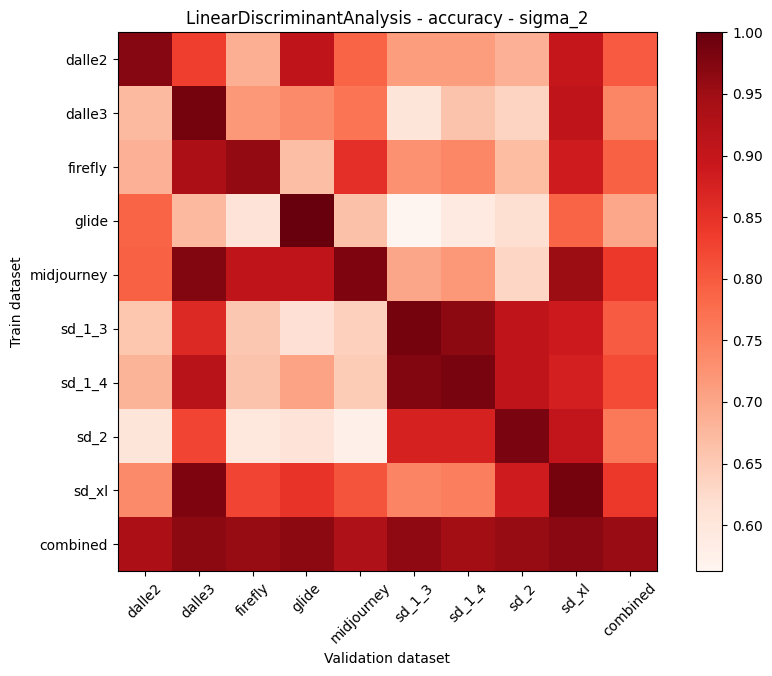

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.971875  0.831250  0.687500  0.906250    0.787500  0.712500   
dalle3         0.671875  0.987500  0.718750  0.737500    0.765625  0.603125   
firefly        0.684375  0.934375  0.959375  0.665625    0.853125  0.728125   
glide          0.787500  0.675000  0.606250  1.000000    0.662500  0.562500   
midjourney     0.790625  0.975000  0.906250  0.909375    0.978125  0.700000   
sd_1_3         0.656250  0.862500  0.653125  0.612500    0.640625  0.987500   
sd_1_4         0.681250  0.918750  0.659375  0.703125    0.646875  0.975000   
sd_2           0.603125  0.825000  0.596875  0.606250    0.575000  0.875000   
sd_xl          0.737500  0.978125  0.825000  0.846875    0.806250  0.743750   
combined       0.934375  0.965625  0.956250  0.965625    0.931250  0.962500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.712500  0.684375  0.900000  0.799306  
dalle3         0.659375  0.634375  0.906250  0.742708  
firefly        0.740625  0.668750  0.884375  0.790972  
glide          0.590625  0.615625  0.787500  0.698611  
midjourney     0.718750  0.631250  0.953125  0.840278  
sd_1_3         0.965625  0.909375  0.887500  0.797222  
sd_1_4         0.984375  0.906250  0.878125  0.817014  
sd_2           0.875000  0.981250  0.903125  0.760069  
sd_xl          0.753125  0.884375  0.987500  0.840278  
combined       0.946875  0.956250  0.968750  0.954167

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.971875  0.831250  0.687500  0.906250    0.787500  0.712500   
dalle3         0.671875  0.987500  0.718750  0.737500    0.765625  0.603125   
firefly        0.684375  0.934375  0.959375  0.665625    0.853125  0.728125   
glide          0.787500  0.675000  0.606250  1.000000    0.662500  0.562500   
midjourney     0.790625  0.975000  0.906250  0.909375    0.978125  0.700000   
sd_1_3         0.656250  0.862500  0.653125  0.612500    0.640625  0.987500   
sd_1_4         0.681250  0.918750  0.659375  0.703125    0.646875  0.975000   
sd_2           0.603125  0.825000  0.596875  0.606250    0.575000  0.875000   
sd_xl          0.737500  0.978125  0.825000  0.846875    0.806250  0.743750   
combined       0.934375  0.965625  0.956250  0.965625    0.931250  0.962500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.712500  0.684375  0.900000  0.799306  
dalle3         0.659375  0.634375  0.906250  0.742708  
firefly        0.740625  0.668750  0.884375  0.790972  
glide          0.590625  0.615625  0.787500  0.698611  
midjourney     0.718750  0.631250  0.953125  0.840278  
sd_1_3         0.965625  0.909375  0.887500  0.797222  
sd_1_4         0.984375  0.906250  0.878125  0.817014  
sd_2           0.875000  0.981250  0.903125  0.760069  
sd_xl          0.753125  0.884375  0.987500  0.840278  
combined       0.946875  0.956250  0.968750  0.954167

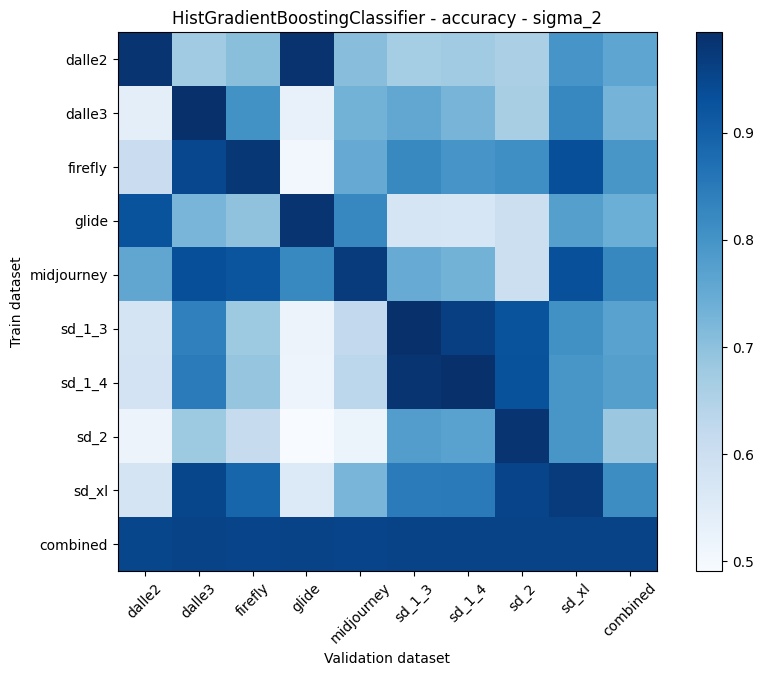

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.984375  0.675000  0.703125  0.987500    0.706250  0.668750   
dalle3         0.540625  0.990625  0.803125  0.528125    0.731250  0.756250   
firefly        0.606250  0.946875  0.978125  0.506250    0.750000  0.821875   
glide          0.925000  0.725000  0.696875  0.984375    0.825000  0.575000   
midjourney     0.759375  0.934375  0.921875  0.821875    0.971875  0.746875   
sd_1_3         0.578125  0.837500  0.678125  0.518750    0.621875  0.993750   
sd_1_4         0.581250  0.846875  0.690625  0.515625    0.631250  0.984375   
sd_2           0.518750  0.678125  0.612500  0.490625    0.521875  0.778125   
sd_xl          0.578125  0.950000  0.890625  0.559375    0.725000  0.846875   
combined       0.950000  0.956250  0.953125  0.956250    0.953125  0.956250   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.675000  0.659375  0.796875  0.761806  
dalle3         0.728125  0.662500  0.825000  0.729514  
firefly        0.796875  0.809375  0.934375  0.794444  
glide          0.571875  0.600000  0.775000  0.742014  
midjourney     0.731250  0.600000  0.931250  0.824306  
sd_1_3         0.962500  0.925000  0.806250  0.769097  
sd_1_4         0.993750  0.928125  0.793750  0.773958  
sd_2           0.768750  0.984375  0.793750  0.682986  
sd_xl          0.850000  0.953125  0.971875  0.813889  
combined       0.956250  0.956250  0.956250  0.954861

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.984375  0.675000  0.703125  0.987500    0.706250  0.668750   
dalle3         0.540625  0.990625  0.803125  0.528125    0.731250  0.756250   
firefly        0.606250  0.946875  0.978125  0.506250    0.750000  0.821875   
glide          0.925000  0.725000  0.696875  0.984375    0.825000  0.575000   
midjourney     0.759375  0.934375  0.921875  0.821875    0.971875  0.746875   
sd_1_3         0.578125  0.837500  0.678125  0.518750    0.621875  0.993750   
sd_1_4         0.581250  0.846875  0.690625  0.515625    0.631250  0.984375   
sd_2           0.518750  0.678125  0.612500  0.490625    0.521875  0.778125   
sd_xl          0.578125  0.950000  0.890625  0.559375    0.725000  0.846875   
combined       0.950000  0.956250  0.953125  0.956250    0.953125  0.956250   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.675000  0.659375  0.796875  0.761806  
dalle3         0.728125  0.662500  0.825000  0.729514  
firefly        0.796875  0.809375  0.934375  0.794444  
glide          0.571875  0.600000  0.775000  0.742014  
midjourney     0.731250  0.600000  0.931250  0.824306  
sd_1_3         0.962500  0.925000  0.806250  0.769097  
sd_1_4         0.993750  0.928125  0.793750  0.773958  
sd_2           0.768750  0.984375  0.793750  0.682986  
sd_xl          0.850000  0.953125  0.971875  0.813889  
combined       0.956250  0.956250  0.956250  0.954861

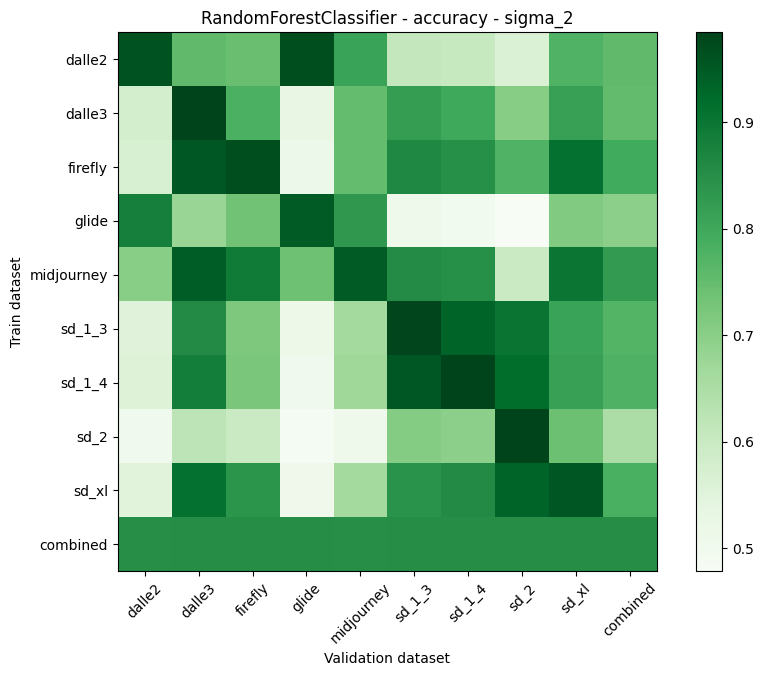

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.962500  0.753125  0.743750  0.968750    0.809375  0.609375   
dalle3         0.578125  0.984375  0.781250  0.531250    0.750000  0.821875   
firefly        0.568750  0.953125  0.968750  0.515625    0.750000  0.862500   
glide          0.881250  0.678125  0.734375  0.946875    0.831250  0.509375   
midjourney     0.700000  0.943750  0.890625  0.737500    0.946875  0.856250   
sd_1_3         0.553125  0.859375  0.715625  0.512500    0.662500  0.981250   
sd_1_4         0.556250  0.884375  0.721875  0.500000    0.668750  0.953125   
sd_2           0.500000  0.621875  0.596875  0.487500    0.509375  0.709375   
sd_xl          0.550000  0.909375  0.837500  0.506250    0.662500  0.840625   
combined       0.850000  0.853125  0.853125  0.853125    0.850000  0.853125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.603125  0.562500  0.775000  0.754167  
dalle3         0.800000  0.703125  0.815625  0.751736  
firefly        0.846875  0.775000  0.909375  0.794444  
glide          0.496875  0.478125  0.712500  0.696528  
midjourney     0.846875  0.596875  0.900000  0.824306  
sd_1_3         0.934375  0.903125  0.809375  0.770139  
sd_1_4         0.984375  0.918750  0.815625  0.778125  
sd_2           0.696875  0.984375  0.740625  0.649653  
sd_xl          0.859375  0.934375  0.956250  0.784028  
combined       0.853125  0.853125  0.853125  0.852431

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.962500  0.753125  0.743750  0.968750    0.809375  0.609375   
dalle3         0.578125  0.984375  0.781250  0.531250    0.750000  0.821875   
firefly        0.568750  0.953125  0.968750  0.515625    0.750000  0.862500   
glide          0.881250  0.678125  0.734375  0.946875    0.831250  0.509375   
midjourney     0.700000  0.943750  0.890625  0.737500    0.946875  0.856250   
sd_1_3         0.553125  0.859375  0.715625  0.512500    0.662500  0.981250   
sd_1_4         0.556250  0.884375  0.721875  0.500000    0.668750  0.953125   
sd_2           0.500000  0.621875  0.596875  0.487500    0.509375  0.709375   
sd_xl          0.550000  0.909375  0.837500  0.506250    0.662500  0.840625   
combined       0.850000  0.853125  0.853125  0.853125    0.850000  0.853125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.603125  0.562500  0.775000  0.754167  
dalle3         0.800000  0.703125  0.815625  0.751736  
firefly        0.846875  0.775000  0.909375  0.794444  
glide          0.496875  0.478125  0.712500  0.696528  
midjourney     0.846875  0.596875  0.900000  0.824306  
sd_1_3         0.934375  0.903125  0.809375  0.770139  
sd_1_4         0.984375  0.918750  0.815625  0.778125  
sd_2           0.696875  0.984375  0.740625  0.649653  
sd_xl          0.859375  0.934375  0.956250  0.784028  
combined       0.853125  0.853125  0.853125  0.852431

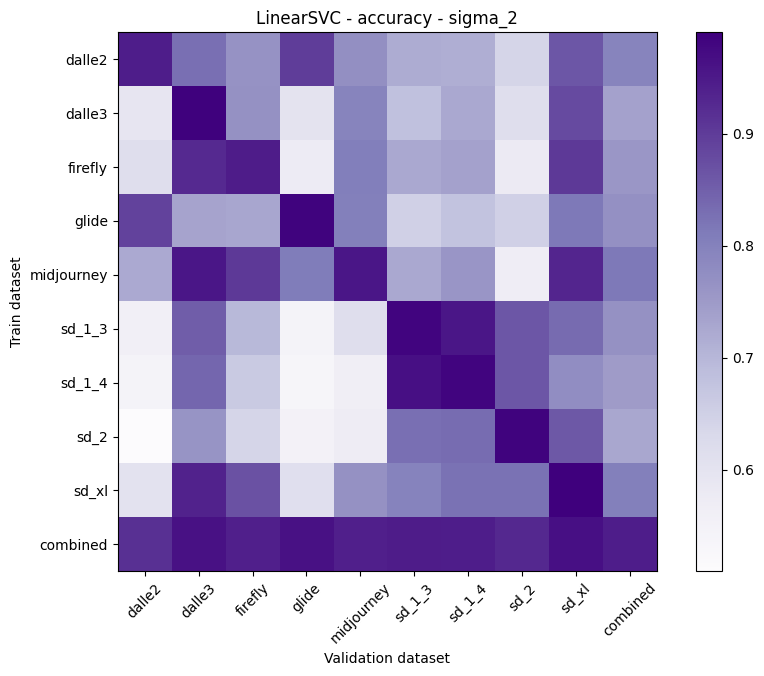

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.943750  0.828125  0.765625  0.896875    0.771875  0.718750   
dalle3         0.593750  0.987500  0.768750  0.600000    0.793750  0.681250   
firefly        0.615625  0.925000  0.946875  0.575000    0.806250  0.725000   
glide          0.890625  0.734375  0.728125  0.984375    0.803125  0.650000   
midjourney     0.721875  0.956250  0.903125  0.809375    0.956250  0.725000   
sd_1_3         0.559375  0.853125  0.696875  0.543750    0.615625  0.981250   
sd_1_4         0.543750  0.840625  0.662500  0.534375    0.565625  0.965625   
sd_2           0.509375  0.762500  0.640625  0.550000    0.571875  0.828125   
sd_xl          0.603125  0.937500  0.868750  0.612500    0.768750  0.796875   
combined       0.915625  0.962500  0.940625  0.962500    0.940625  0.946875   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.715625  0.640625  0.862500  0.793750  
dalle3         0.725000  0.615625  0.878125  0.738194  
firefly        0.737500  0.578125  0.903125  0.756944  
glide          0.678125  0.650000  0.815625  0.770486  
midjourney     0.759375  0.568750  0.931250  0.814583  
sd_1_3         0.956250  0.862500  0.834375  0.767014  
sd_1_4         0.981250  0.862500  0.775000  0.747917  
sd_2           0.831250  0.984375  0.859375  0.726389  
sd_xl          0.825000  0.825000  0.990625  0.803125  
combined       0.943750  0.928125  0.965625  0.945139

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.943750  0.828125  0.765625  0.896875    0.771875  0.718750   
dalle3         0.593750  0.987500  0.768750  0.600000    0.793750  0.681250   
firefly        0.615625  0.925000  0.946875  0.575000    0.806250  0.725000   
glide          0.890625  0.734375  0.728125  0.984375    0.803125  0.650000   
midjourney     0.721875  0.956250  0.903125  0.809375    0.956250  0.725000   
sd_1_3         0.559375  0.853125  0.696875  0.543750    0.615625  0.981250   
sd_1_4         0.543750  0.840625  0.662500  0.534375    0.565625  0.965625   
sd_2           0.509375  0.762500  0.640625  0.550000    0.571875  0.828125   
sd_xl          0.603125  0.937500  0.868750  0.612500    0.768750  0.796875   
combined       0.915625  0.962500  0.940625  0.962500    0.940625  0.946875   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.715625  0.640625  0.862500  0.793750  
dalle3         0.725000  0.615625  0.878125  0.738194  
firefly        0.737500  0.578125  0.903125  0.756944  
glide          0.678125  0.650000  0.815625  0.770486  
midjourney     0.759375  0.568750  0.931250  0.814583  
sd_1_3         0.956250  0.862500  0.834375  0.767014  
sd_1_4         0.981250  0.862500  0.775000  0.747917  
sd_2           0.831250  0.984375  0.859375  0.726389  
sd_xl          0.825000  0.825000  0.990625  0.803125  
combined       0.943750  0.928125  0.965625  0.945139









 ################ Evaluating models trained on standardAugmented and tested on sigma_3. ################


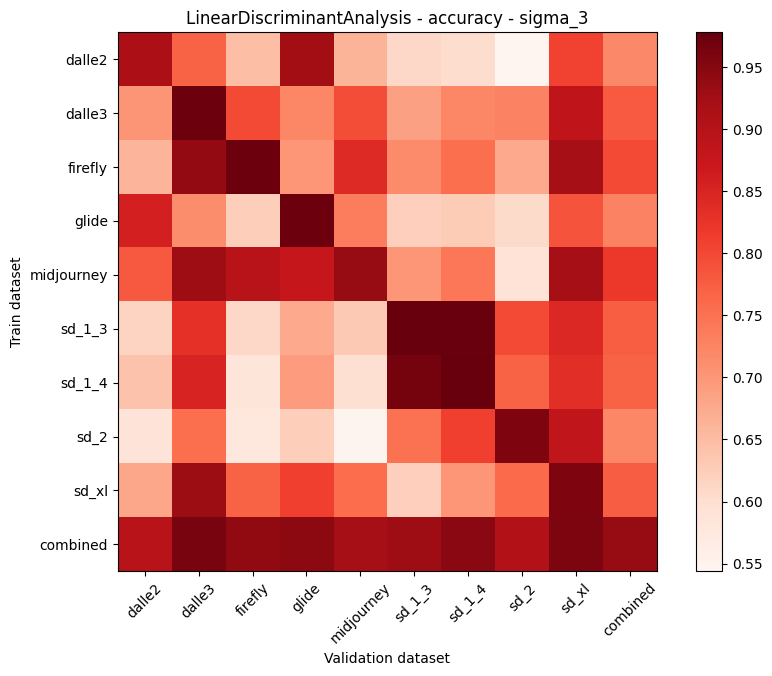

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.912500  0.768750  0.646875  0.925000    0.662500  0.609375   
dalle3         0.703125  0.971875  0.796875  0.721875    0.793750  0.687500   
firefly        0.659375  0.937500  0.971875  0.700000    0.840625  0.715625   
glide          0.856250  0.712500  0.625000  0.971875    0.734375  0.621875   
midjourney     0.781250  0.928125  0.896875  0.878125    0.934375  0.700000   
sd_1_3         0.615625  0.831250  0.609375  0.675000    0.631250  0.978125   
sd_1_4         0.640625  0.850000  0.584375  0.693750    0.596875  0.965625   
sd_2           0.587500  0.753125  0.578125  0.625000    0.546875  0.750000   
sd_xl          0.678125  0.931250  0.768750  0.809375    0.756250  0.621875   
combined       0.896875  0.962500  0.940625  0.943750    0.921875  0.928125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.603125  0.543750  0.806250  0.719792  
dalle3         0.721875  0.728125  0.887500  0.779167  
firefly        0.753125  0.675000  0.921875  0.797222  
glide          0.628125  0.606250  0.787500  0.727083  
midjourney     0.743750  0.590625  0.921875  0.819444  
sd_1_3         0.975000  0.796875  0.843750  0.772917  
sd_1_4         0.978125  0.768750  0.834375  0.768056  
sd_2           0.809375  0.956250  0.884375  0.721181  
sd_xl          0.700000  0.759375  0.956250  0.775694  
combined       0.946875  0.906250  0.959375  0.934028

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.912500  0.768750  0.646875  0.925000    0.662500  0.609375   
dalle3         0.703125  0.971875  0.796875  0.721875    0.793750  0.687500   
firefly        0.659375  0.937500  0.971875  0.700000    0.840625  0.715625   
glide          0.856250  0.712500  0.625000  0.971875    0.734375  0.621875   
midjourney     0.781250  0.928125  0.896875  0.878125    0.934375  0.700000   
sd_1_3         0.615625  0.831250  0.609375  0.675000    0.631250  0.978125   
sd_1_4         0.640625  0.850000  0.584375  0.693750    0.596875  0.965625   
sd_2           0.587500  0.753125  0.578125  0.625000    0.546875  0.750000   
sd_xl          0.678125  0.931250  0.768750  0.809375    0.756250  0.621875   
combined       0.896875  0.962500  0.940625  0.943750    0.921875  0.928125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.603125  0.543750  0.806250  0.719792  
dalle3         0.721875  0.728125  0.887500  0.779167  
firefly        0.753125  0.675000  0.921875  0.797222  
glide          0.628125  0.606250  0.787500  0.727083  
midjourney     0.743750  0.590625  0.921875  0.819444  
sd_1_3         0.975000  0.796875  0.843750  0.772917  
sd_1_4         0.978125  0.768750  0.834375  0.768056  
sd_2           0.809375  0.956250  0.884375  0.721181  
sd_xl          0.700000  0.759375  0.956250  0.775694  
combined       0.946875  0.906250  0.959375  0.934028

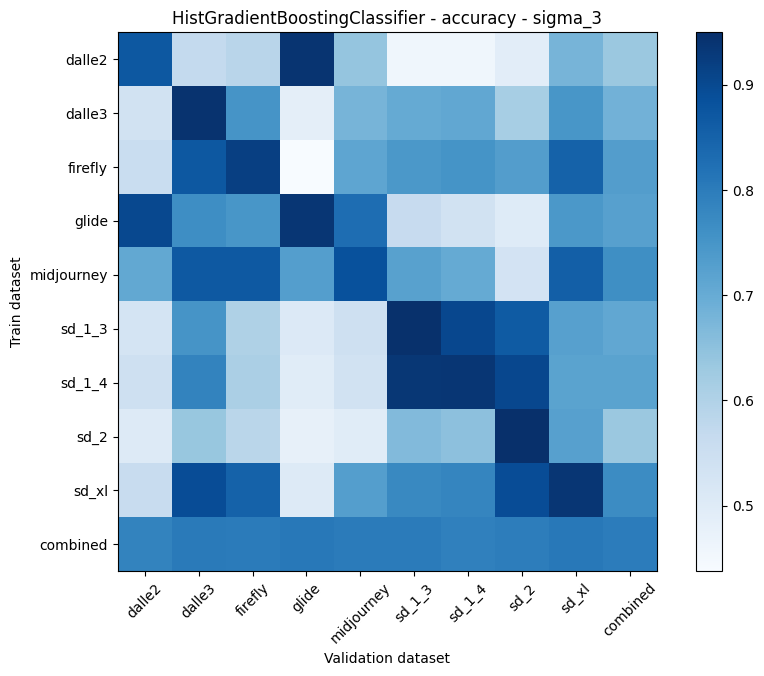

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.871875  0.568750  0.587500  0.940625    0.640625  0.456250   
dalle3         0.534375  0.943750  0.750000  0.487500    0.678125  0.703125   
firefly        0.556250  0.871875  0.918750  0.437500    0.712500  0.743750   
glide          0.900000  0.765625  0.746875  0.937500    0.828125  0.562500   
midjourney     0.706250  0.868750  0.868750  0.728125    0.884375  0.721875   
sd_1_3         0.528125  0.750000  0.603125  0.506250    0.543750  0.946875   
sd_1_4         0.543750  0.784375  0.609375  0.496875    0.534375  0.934375   
sd_2           0.503125  0.637500  0.584375  0.478125    0.496875  0.665625   
sd_xl          0.559375  0.893750  0.850000  0.503125    0.728125  0.775000   
combined       0.784375  0.803125  0.800000  0.806250    0.800000  0.800000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.456250  0.490625  0.678125  0.632292  
dalle3         0.709375  0.615625  0.746875  0.685417  
firefly        0.753125  0.731250  0.850000  0.730556  
glide          0.534375  0.500000  0.743750  0.724306  
midjourney     0.703125  0.531250  0.856250  0.763194  
sd_1_3         0.903125  0.865625  0.725000  0.707986  
sd_1_4         0.937500  0.903125  0.718750  0.718056  
sd_2           0.650000  0.950000  0.725000  0.632292  
sd_xl          0.781250  0.893750  0.937500  0.769097  
combined       0.790625  0.796875  0.806250  0.798611

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.871875  0.568750  0.587500  0.940625    0.640625  0.456250   
dalle3         0.534375  0.943750  0.750000  0.487500    0.678125  0.703125   
firefly        0.556250  0.871875  0.918750  0.437500    0.712500  0.743750   
glide          0.900000  0.765625  0.746875  0.937500    0.828125  0.562500   
midjourney     0.706250  0.868750  0.868750  0.728125    0.884375  0.721875   
sd_1_3         0.528125  0.750000  0.603125  0.506250    0.543750  0.946875   
sd_1_4         0.543750  0.784375  0.609375  0.496875    0.534375  0.934375   
sd_2           0.503125  0.637500  0.584375  0.478125    0.496875  0.665625   
sd_xl          0.559375  0.893750  0.850000  0.503125    0.728125  0.775000   
combined       0.784375  0.803125  0.800000  0.806250    0.800000  0.800000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.456250  0.490625  0.678125  0.632292  
dalle3         0.709375  0.615625  0.746875  0.685417  
firefly        0.753125  0.731250  0.850000  0.730556  
glide          0.534375  0.500000  0.743750  0.724306  
midjourney     0.703125  0.531250  0.856250  0.763194  
sd_1_3         0.903125  0.865625  0.725000  0.707986  
sd_1_4         0.937500  0.903125  0.718750  0.718056  
sd_2           0.650000  0.950000  0.725000  0.632292  
sd_xl          0.781250  0.893750  0.937500  0.769097  
combined       0.790625  0.796875  0.806250  0.798611

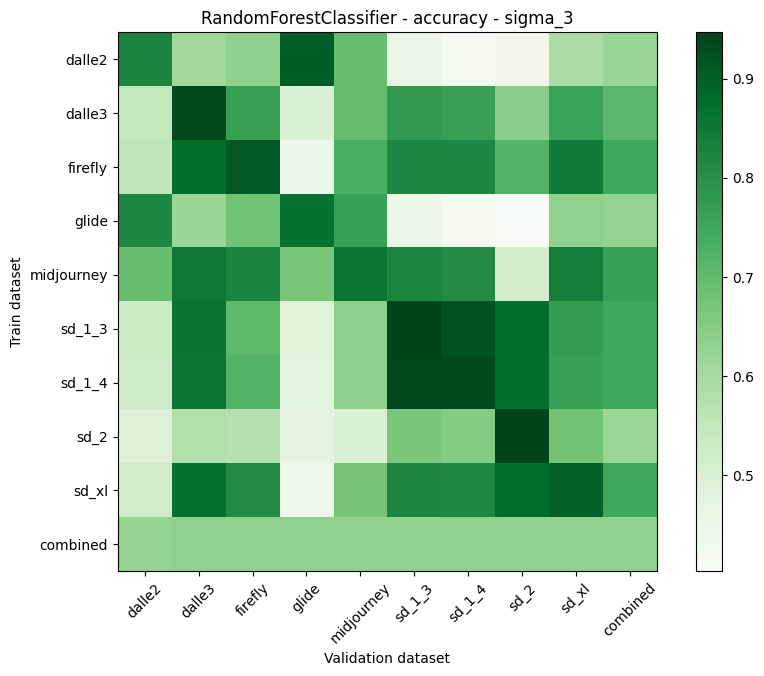

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.825000  0.609375  0.634375  0.903125    0.693750  0.453125   
dalle3         0.546875  0.937500  0.765625  0.493750    0.693750  0.778125   
firefly        0.553125  0.875000  0.909375  0.446875    0.734375  0.818750   
glide          0.818750  0.618750  0.681250  0.865625    0.762500  0.443750   
midjourney     0.690625  0.853125  0.825000  0.665625    0.856250  0.821875   
sd_1_3         0.534375  0.859375  0.703125  0.481250    0.637500  0.946875   
sd_1_4         0.525000  0.856250  0.715625  0.475000    0.637500  0.940625   
sd_2           0.490625  0.578125  0.571875  0.471875    0.493750  0.665625   
sd_xl          0.518750  0.865625  0.812500  0.440625    0.671875  0.821875   
combined       0.625000  0.631250  0.631250  0.631250    0.631250  0.631250   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.421875  0.434375  0.590625  0.618403  
dalle3         0.765625  0.640625  0.759375  0.709028  
firefly        0.818750  0.715625  0.843750  0.746181  
glide          0.418750  0.403125  0.631250  0.627083  
midjourney     0.812500  0.512500  0.837500  0.763889  
sd_1_3         0.921875  0.868750  0.771875  0.747222  
sd_1_4         0.934375  0.871875  0.765625  0.746875  
sd_2           0.650000  0.946875  0.675000  0.615972  
sd_xl          0.815625  0.878125  0.896875  0.746875  
combined       0.631250  0.631250  0.631250  0.630556

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.825000  0.609375  0.634375  0.903125    0.693750  0.453125   
dalle3         0.546875  0.937500  0.765625  0.493750    0.693750  0.778125   
firefly        0.553125  0.875000  0.909375  0.446875    0.734375  0.818750   
glide          0.818750  0.618750  0.681250  0.865625    0.762500  0.443750   
midjourney     0.690625  0.853125  0.825000  0.665625    0.856250  0.821875   
sd_1_3         0.534375  0.859375  0.703125  0.481250    0.637500  0.946875   
sd_1_4         0.525000  0.856250  0.715625  0.475000    0.637500  0.940625   
sd_2           0.490625  0.578125  0.571875  0.471875    0.493750  0.665625   
sd_xl          0.518750  0.865625  0.812500  0.440625    0.671875  0.821875   
combined       0.625000  0.631250  0.631250  0.631250    0.631250  0.631250   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.421875  0.434375  0.590625  0.618403  
dalle3         0.765625  0.640625  0.759375  0.709028  
firefly        0.818750  0.715625  0.843750  0.746181  
glide          0.418750  0.403125  0.631250  0.627083  
midjourney     0.812500  0.512500  0.837500  0.763889  
sd_1_3         0.921875  0.868750  0.771875  0.747222  
sd_1_4         0.934375  0.871875  0.765625  0.746875  
sd_2           0.650000  0.946875  0.675000  0.615972  
sd_xl          0.815625  0.878125  0.896875  0.746875  
combined       0.631250  0.631250  0.631250  0.630556

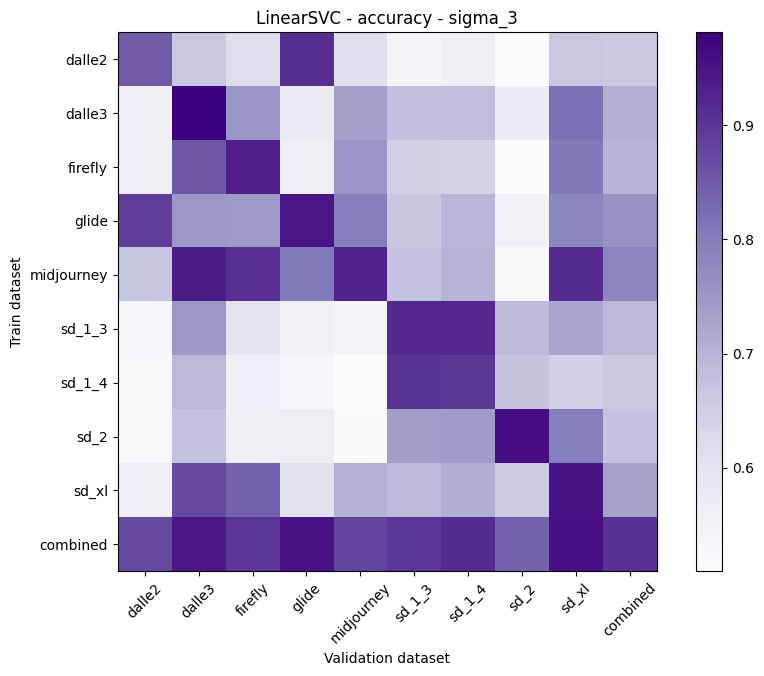

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.850000  0.662500  0.615625  0.912500    0.609375  0.537500   
dalle3         0.559375  0.981250  0.753125  0.575000    0.734375  0.678125   
firefly        0.559375  0.853125  0.934375  0.562500    0.753125  0.646875   
glide          0.890625  0.746875  0.743750  0.946875    0.800000  0.665625   
midjourney     0.665625  0.937500  0.909375  0.803125    0.928125  0.675000   
sd_1_3         0.531250  0.750000  0.596875  0.550000    0.537500  0.918750   
sd_1_4         0.525000  0.690625  0.565625  0.528125    0.509375  0.903125   
sd_2           0.525000  0.675000  0.559375  0.562500    0.515625  0.737500   
sd_xl          0.559375  0.871875  0.840625  0.600000    0.703125  0.687500   
combined       0.871875  0.943750  0.900000  0.953125    0.881250  0.900000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.559375  0.512500  0.662500  0.657986  
dalle3         0.681250  0.571875  0.818750  0.705903  
firefly        0.640625  0.509375  0.806250  0.696181  
glide          0.693750  0.550000  0.781250  0.757639  
midjourney     0.700000  0.518750  0.915625  0.783681  
sd_1_3         0.918750  0.687500  0.725000  0.690625  
sd_1_4         0.896875  0.668750  0.646875  0.659375  
sd_2           0.740625  0.959375  0.796875  0.674653  
sd_xl          0.712500  0.656250  0.953125  0.731597  
combined       0.915625  0.837500  0.956250  0.906597

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.850000  0.662500  0.615625  0.912500    0.609375  0.537500   
dalle3         0.559375  0.981250  0.753125  0.575000    0.734375  0.678125   
firefly        0.559375  0.853125  0.934375  0.562500    0.753125  0.646875   
glide          0.890625  0.746875  0.743750  0.946875    0.800000  0.665625   
midjourney     0.665625  0.937500  0.909375  0.803125    0.928125  0.675000   
sd_1_3         0.531250  0.750000  0.596875  0.550000    0.537500  0.918750   
sd_1_4         0.525000  0.690625  0.565625  0.528125    0.509375  0.903125   
sd_2           0.525000  0.675000  0.559375  0.562500    0.515625  0.737500   
sd_xl          0.559375  0.871875  0.840625  0.600000    0.703125  0.687500   
combined       0.871875  0.943750  0.900000  0.953125    0.881250  0.900000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.559375  0.512500  0.662500  0.657986  
dalle3         0.681250  0.571875  0.818750  0.705903  
firefly        0.640625  0.509375  0.806250  0.696181  
glide          0.693750  0.550000  0.781250  0.757639  
midjourney     0.700000  0.518750  0.915625  0.783681  
sd_1_3         0.918750  0.687500  0.725000  0.690625  
sd_1_4         0.896875  0.668750  0.646875  0.659375  
sd_2           0.740625  0.959375  0.796875  0.674653  
sd_xl          0.712500  0.656250  0.953125  0.731597  
combined       0.915625  0.837500  0.956250  0.906597

In [13]:
print("########################### Accuracy ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]
    
    metric = "accuracy"
    evaluation_data_name = "Validation"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

### MCC - Validation

########################### MCC ###########################








 ################ Evaluating models trained on standardAugmented and tested on standard. ################


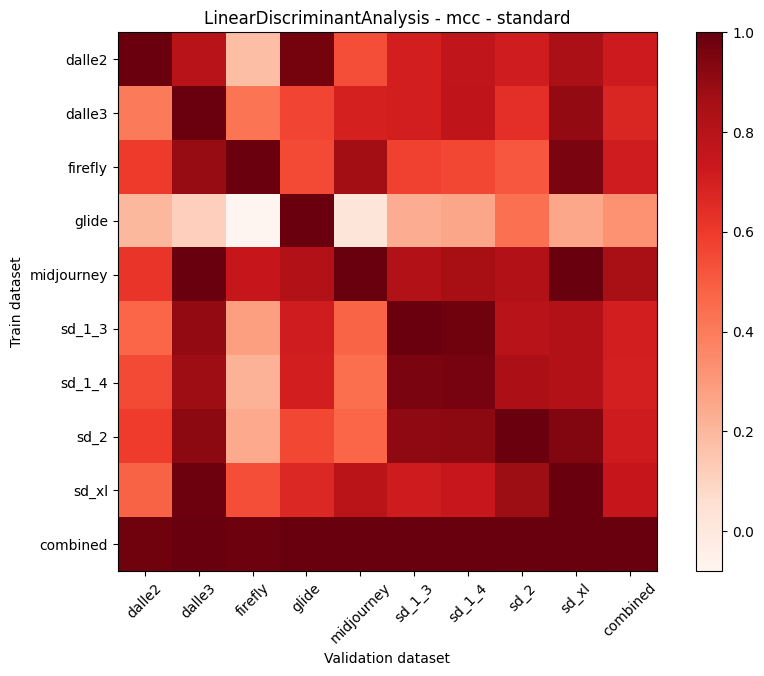

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.793812  0.179361  0.968920    0.537833  0.702095   
dalle3         0.403627  0.987570  0.424219  0.566771    0.693956  0.703981   
firefly        0.595799  0.891054  0.987570  0.552268    0.868234  0.576441   
glide          0.201753  0.116549 -0.080806  0.987570    0.022839  0.239117   
midjourney     0.613922  0.993768  0.745077  0.817073    1.000000  0.822364   
sd_1_3         0.469378  0.902642  0.279164  0.709013    0.474320  0.987570   
sd_1_4         0.549385  0.876814  0.215762  0.700828    0.438569  0.956388   
sd_2           0.590956  0.914356  0.246097  0.557103    0.469378  0.908483   
sd_xl          0.479961  0.981265  0.537833  0.662773    0.788568  0.717034   
combined       0.975308  0.993768  0.981423  1.000000    1.000000  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.767787  0.712041  0.841972  0.718701  
dalle3         0.775808  0.639591  0.902642  0.671296  
firefly        0.557103  0.513491  0.956418  0.712375  
glide          0.259664  0.434379  0.252943  0.321619  
midjourney     0.854594  0.817073  0.993768  0.844955  
sd_1_3         0.974991  0.796968  0.818465  0.703981  
sd_1_4         0.962771  0.836244  0.819273  0.699675  
sd_2           0.914356  0.987570  0.938181  0.715743  
sd_xl          0.742213  0.880791  0.993766  0.745599  
combined       1.000000  0.993768  1.000000  0.993768

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.793812  0.179361  0.968920    0.537833  0.702095   
dalle3         0.403627  0.987570  0.424219  0.566771    0.693956  0.703981   
firefly        0.595799  0.891054  0.987570  0.552268    0.868234  0.576441   
glide          0.201753  0.116549 -0.080806  0.987570    0.022839  0.239117   
midjourney     0.613922  0.993768  0.745077  0.817073    1.000000  0.822364   
sd_1_3         0.469378  0.902642  0.279164  0.709013    0.474320  0.987570   
sd_1_4         0.549385  0.876814  0.215762  0.700828    0.438569  0.956388   
sd_2           0.590956  0.914356  0.246097  0.557103    0.469378  0.908483   
sd_xl          0.479961  0.981265  0.537833  0.662773    0.788568  0.717034   
combined       0.975308  0.993768  0.981423  1.000000    1.000000  1.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.767787  0.712041  0.841972  0.721257  
dalle3         0.775808  0.639591  0.902642  0.677574  
firefly        0.557103  0.513491  0.956418  0.722042  
glide          0.259664  0.434379  0.252943  0.270445  
midjourney     0.854594  0.817073  0.993768  0.850849  
sd_1_3         0.974991  0.796968  0.818465  0.712501  
sd_1_4         0.962771  0.836244  0.819273  0.706226  
sd_2           0.914356  0.987570  0.938181  0.725165  
sd_xl          0.742213  0.880791  0.993766  0.753801  
combined       1.000000  0.993768  1.000000  0.993807

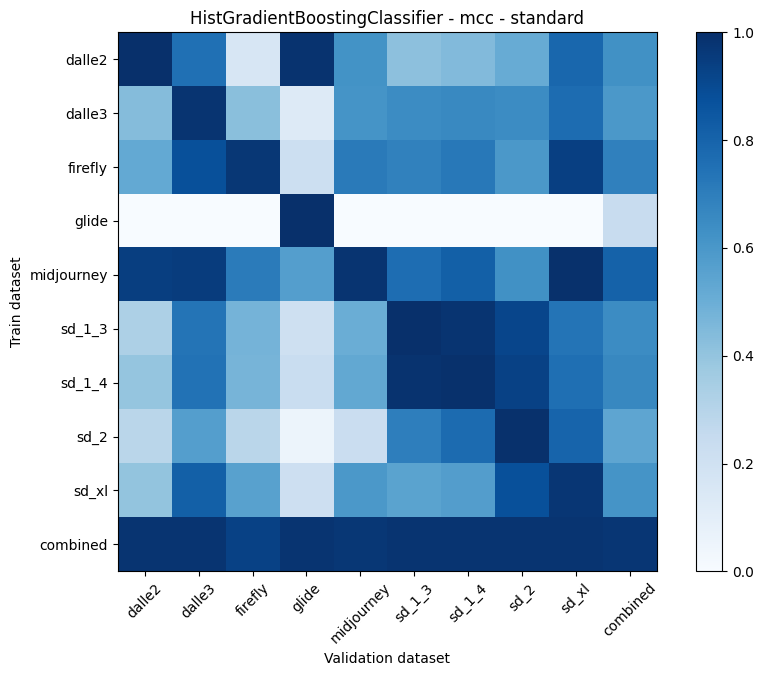

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.750104  0.157153  0.987576    0.618670  0.417320   
dalle3         0.435558  0.981265  0.425503  0.129144    0.614413  0.648189   
firefly        0.523316  0.878522  0.968754  0.215824    0.711234  0.685883   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.944680  0.950686  0.707061  0.566530    0.981265  0.762638   
sd_1_3         0.327141  0.735069  0.476290  0.209923    0.500278  1.000000   
sd_1_4         0.397005  0.745077  0.471460  0.232466    0.524065  0.987576   
sd_2           0.288044  0.566530  0.288044  0.054154    0.227578  0.697140   
sd_xl          0.399961  0.814993  0.556970  0.212470    0.595228  0.547405   
combined       0.981410  0.981410  0.931721  0.981410    0.968754  0.981410   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.442193  0.509812  0.785767  0.628181  
dalle3         0.657903  0.648189  0.767787  0.594696  
firefly        0.721470  0.596669  0.937800  0.689245  
glide          0.000000  0.000000  0.000000  0.240384  
midjourney     0.814993  0.628851  0.993766  0.808485  
sd_1_3         0.981423  0.916117  0.735069  0.648340  
sd_1_4         0.993768  0.933519  0.755147  0.663815  
sd_2           0.772954  0.993766  0.799076  0.538365  
sd_xl          0.571310  0.875165  0.975073  0.614947  
combined       0.981410  0.981410  0.981410  0.974359

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.750104  0.157153  0.987576    0.618670  0.417320   
dalle3         0.435558  0.981265  0.425503  0.129144    0.614413  0.648189   
firefly        0.523316  0.878522  0.968754  0.215824    0.711234  0.685883   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.944680  0.950686  0.707061  0.566530    0.981265  0.762638   
sd_1_3         0.327141  0.735069  0.476290  0.209923    0.500278  1.000000   
sd_1_4         0.397005  0.745077  0.471460  0.232466    0.524065  0.987576   
sd_2           0.288044  0.566530  0.288044  0.054154    0.227578  0.697140   
sd_xl          0.399961  0.814993  0.556970  0.212470    0.595228  0.547405   
combined       0.981410  0.981410  0.931721  0.981410    0.968754  0.981410   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.442193  0.509812  0.785767  0.629844  
dalle3         0.657903  0.648189  0.767787  0.589772  
firefly        0.721470  0.596669  0.937800  0.693275  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.814993  0.628851  0.993766  0.816719  
sd_1_3         0.981423  0.916117  0.735069  0.653479  
sd_1_4         0.993768  0.933519  0.755147  0.671120  
sd_2           0.772954  0.993766  0.799076  0.520810  
sd_xl          0.571310  0.875165  0.975073  0.616508  
combined       0.981410  0.981410  0.981410  0.974482

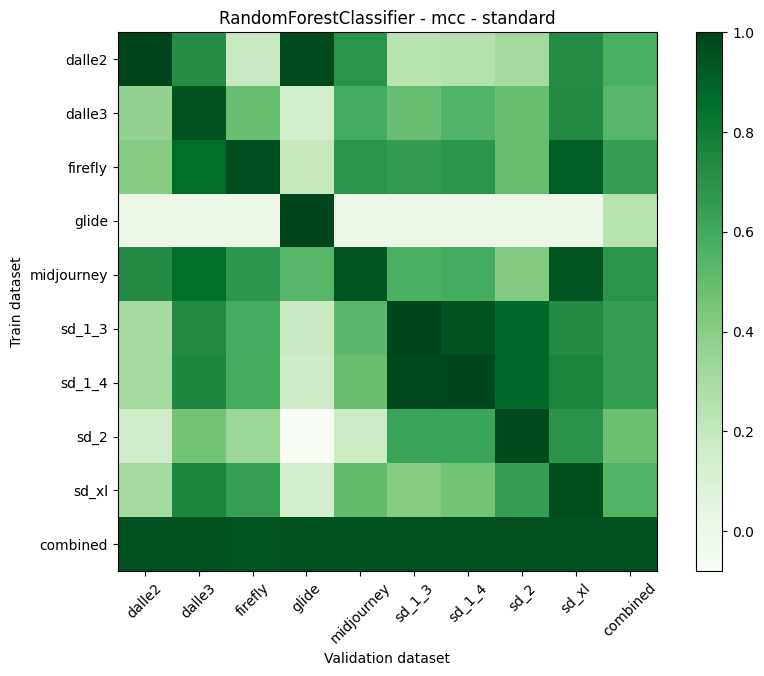

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.725120  0.185171  0.975308    0.690720  0.239601   
dalle3         0.362956  0.950686  0.489684  0.140341    0.590440  0.489684   
firefly        0.405121  0.858451  0.962805  0.196472    0.687267  0.657903   
glide          0.000000  0.000000  0.000000  0.993768    0.000000  0.000000   
midjourney     0.732097  0.858451  0.677439  0.533042    0.944680  0.566530   
sd_1_3         0.303909  0.735069  0.585517  0.176269    0.519320  0.987576   
sd_1_4         0.309819  0.750104  0.580792  0.157153    0.485914  0.981423   
sd_2           0.148799  0.459456  0.344444 -0.080806    0.167790  0.624944   
sd_xl          0.312237  0.757507  0.638506  0.140341    0.504199  0.410253   
combined       0.957117  0.957117  0.944159  0.957117    0.950617  0.957117   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.246575  0.309819  0.725120  0.572396  
dalle3         0.552188  0.489684  0.732097  0.538897  
firefly        0.682347  0.489684  0.915164  0.648727  
glide          0.000000  0.000000  0.000000  0.239601  
midjourney     0.585655  0.415360  0.944680  0.688362  
sd_1_3         0.945284  0.871042  0.730087  0.649405  
sd_1_4         0.987576  0.871042  0.755147  0.652068  
sd_2           0.620074  0.981260  0.693956  0.477608  
sd_xl          0.455445  0.653042  0.968920  0.544216  
combined       0.957117  0.957117  0.957117  0.954946

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.725120  0.185171  0.975308    0.690720  0.239601   
dalle3         0.362956  0.950686  0.489684  0.140341    0.590440  0.489684   
firefly        0.405121  0.858451  0.962805  0.196472    0.687267  0.657903   
glide          0.000000  0.000000  0.000000  0.993768    0.000000  0.000000   
midjourney     0.732097  0.858451  0.677439  0.533042    0.944680  0.566530   
sd_1_3         0.303909  0.735069  0.585517  0.176269    0.519320  0.987576   
sd_1_4         0.309819  0.750104  0.580792  0.157153    0.485914  0.981423   
sd_2           0.148799  0.459456  0.344444 -0.080806    0.167790  0.624944   
sd_xl          0.312237  0.757507  0.638506  0.140341    0.504199  0.410253   
combined       0.957117  0.957117  0.944159  0.957117    0.950617  0.957117   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.246575  0.309819  0.725120  0.566382  
dalle3         0.552188  0.489684  0.732097  0.533085  
firefly        0.682347  0.489684  0.915164  0.650579  
glide          0.000000  0.000000  0.000000  0.110419  
midjourney     0.585655  0.415360  0.944680  0.695326  
sd_1_3         0.945284  0.871042  0.730087  0.650453  
sd_1_4         0.987576  0.871042  0.755147  0.653219  
sd_2           0.620074  0.981260  0.693956  0.439991  
sd_xl          0.455445  0.653042  0.968920  0.537828  
combined       0.957117  0.957117  0.957117  0.954955

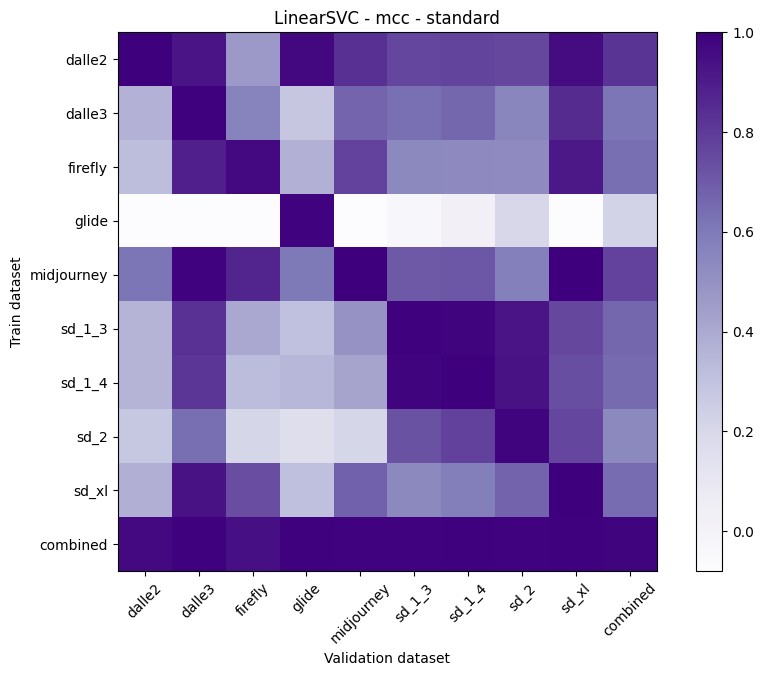

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.927686  0.466618  0.969230    0.833013  0.760207   
dalle3         0.365624  0.993768  0.561903  0.279458    0.666492  0.632945   
firefly        0.320114  0.890120  0.962487  0.370688    0.773620  0.538005   
glide         -0.080806 -0.080806 -0.080806  0.987570   -0.080806 -0.034257   
midjourney     0.613922  0.987576  0.871042  0.599705    1.000000  0.700487   
sd_1_3         0.354865  0.827677  0.402124  0.303909    0.495499  0.993768   
sd_1_4         0.354865  0.811803  0.321431  0.343928    0.422337  0.981423   
sd_2           0.277530  0.640959  0.208258  0.158208    0.208258  0.721470   
sd_xl          0.370943  0.939385  0.740065  0.309819    0.680998  0.538275   
combined       0.962805  0.993766  0.944680  0.993766    0.987496  0.987496   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.770377  0.755147  0.957186  0.818834  
dalle3         0.661675  0.552457  0.849162  0.615504  
firefly        0.528216  0.523316  0.913693  0.639859  
glide          0.022839  0.201753 -0.080806  0.221415  
midjourney     0.710301  0.580792  1.000000  0.774920  
sd_1_3         0.981423  0.927686  0.755147  0.662210  
sd_1_4         1.000000  0.933519  0.735069  0.647276  
sd_2           0.778935  0.981410  0.763048  0.539092  
sd_xl          0.585517  0.671317  1.000000  0.643023  
combined       0.993766  0.987496  0.993766  0.982646

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.927686  0.466618  0.969230    0.833013  0.760207   
dalle3         0.365624  0.993768  0.561903  0.279458    0.666492  0.632945   
firefly        0.320114  0.890120  0.962487  0.370688    0.773620  0.538005   
glide         -0.080806 -0.080806 -0.080806  0.987570   -0.080806 -0.034257   
midjourney     0.613922  0.987576  0.871042  0.599705    1.000000  0.700487   
sd_1_3         0.354865  0.827677  0.402124  0.303909    0.495499  0.993768   
sd_1_4         0.354865  0.811803  0.321431  0.343928    0.422337  0.981423   
sd_2           0.277530  0.640959  0.208258  0.158208    0.208258  0.721470   
sd_xl          0.370943  0.939385  0.740065  0.309819    0.680998  0.538275   
combined       0.962805  0.993766  0.944680  0.993766    0.987496  0.987496   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.770377  0.755147  0.957186  0.826607  
dalle3         0.661675  0.552457  0.849162  0.618165  
firefly        0.528216  0.523316  0.913693  0.646695  
glide          0.022839  0.201753 -0.080806  0.085986  
midjourney     0.710301  0.580792  1.000000  0.784870  
sd_1_3         0.981423  0.927686  0.755147  0.671344  
sd_1_4         1.000000  0.933519  0.735069  0.656042  
sd_2           0.778935  0.981410  0.763048  0.526453  
sd_xl          0.585517  0.671317  1.000000  0.648480  
combined       0.993766  0.987496  0.993766  0.982782









 ################ Evaluating models trained on standardAugmented and tested on sigma_1. ################


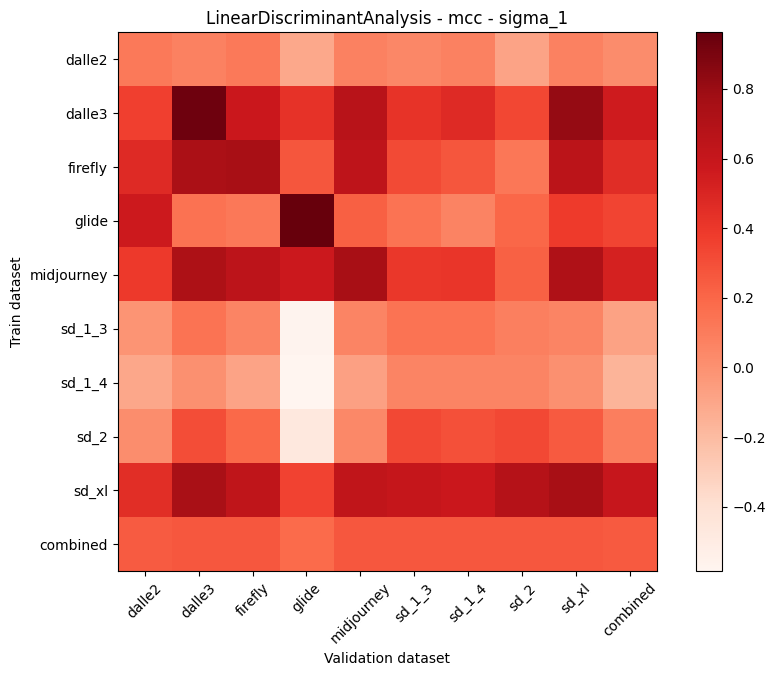

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.114638  0.077969  0.114638 -0.110426    0.077969  0.048678   
dalle3         0.358576  0.933353  0.581249  0.429237    0.671796  0.418561   
firefly        0.468832  0.737610  0.745204  0.272268    0.636777  0.319408   
glide          0.568176  0.150104  0.120980  0.962553    0.229875  0.140770   
midjourney     0.388344  0.724076  0.642039  0.572514    0.747690  0.400492   
sd_1_3        -0.011973  0.140849  0.059905 -0.570697    0.059905  0.140849   
sd_1_4        -0.104033  0.001487 -0.089579 -0.585655   -0.073243  0.057049   
sd_2           0.016899  0.306276  0.188515 -0.465566    0.041830  0.321660   
sd_xl          0.449713  0.739753  0.634893  0.346192    0.627792  0.599829   
combined       0.244790  0.263086  0.263086  0.180157    0.263086  0.263086   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.077969 -0.087675  0.077969  0.021675  
dalle3         0.471495  0.330332  0.813626  0.552166  
firefly        0.272268  0.127570  0.650621  0.459991  
glide          0.062105  0.200338  0.386203  0.345387  
midjourney     0.406588  0.221160  0.708652  0.524629  
sd_1_3         0.140849  0.083081  0.059905 -0.079314  
sd_1_4         0.057049  0.057049  0.001487 -0.165082  
sd_2           0.291448  0.321660  0.249891  0.090211  
sd_xl          0.579286  0.678511  0.747690  0.594469  
combined       0.263086  0.263086  0.263086  0.250778

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.114638  0.077969  0.114638 -0.110426    0.077969  0.048678   
dalle3         0.358576  0.933353  0.581249  0.429237    0.671796  0.418561   
firefly        0.468832  0.737610  0.745204  0.272268    0.636777  0.319408   
glide          0.568176  0.150104  0.120980  0.962553    0.229875  0.140770   
midjourney     0.388344  0.724076  0.642039  0.572514    0.747690  0.400492   
sd_1_3        -0.011973  0.140849  0.059905 -0.570697    0.059905  0.140849   
sd_1_4        -0.104033  0.001487 -0.089579 -0.585655   -0.073243  0.057049   
sd_2           0.016899  0.306276  0.188515 -0.465566    0.041830  0.321660   
sd_xl          0.449713  0.739753  0.634893  0.346192    0.627792  0.599829   
combined       0.244790  0.263086  0.263086  0.180157    0.263086  0.263086   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.077969 -0.087675  0.077969  0.043526  
dalle3         0.471495  0.330332  0.813626  0.556469  
firefly        0.272268  0.127570  0.650621  0.470062  
glide          0.062105  0.200338  0.386203  0.313456  
midjourney     0.406588  0.221160  0.708652  0.534617  
sd_1_3         0.140849  0.083081  0.059905  0.011408  
sd_1_4         0.057049  0.057049  0.001487 -0.075377  
sd_2           0.291448  0.321660  0.249891  0.141401  
sd_xl          0.579286  0.678511  0.747690  0.600406  
combined       0.263086  0.263086  0.263086  0.251839

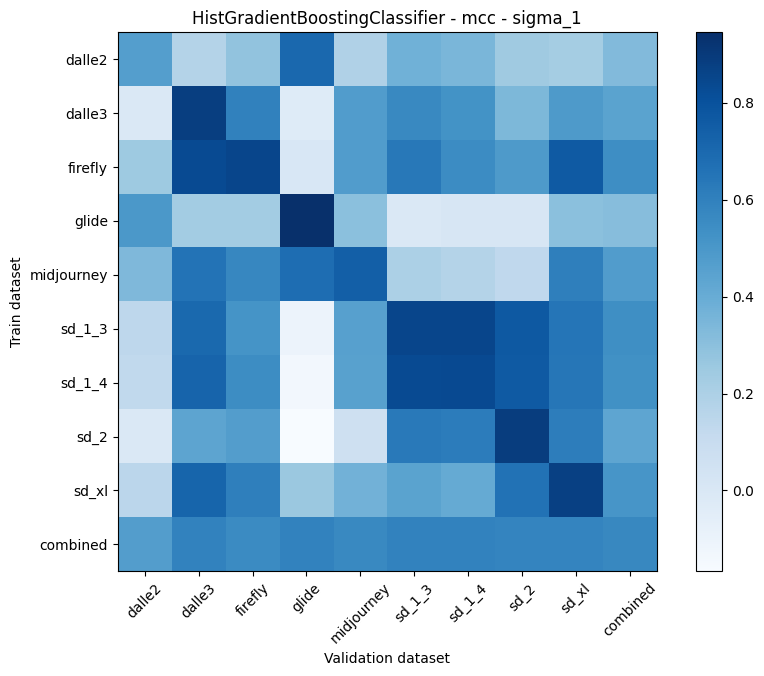

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.465367  0.173001  0.281856  0.701993    0.185078  0.374663   
dalle3        -0.006032  0.883151  0.593579 -0.027930    0.475452  0.566523   
firefly        0.246900  0.831499  0.850873  0.003918    0.472838  0.635850   
glide          0.493957  0.228489  0.228489  0.945171    0.297987 -0.004578   
midjourney     0.336577  0.657656  0.573111  0.682957    0.745014  0.200338   
sd_1_3         0.138138  0.700020  0.519061 -0.105593    0.457664  0.850710   
sd_1_4         0.124623  0.719496  0.548470 -0.139399    0.451145  0.828396   
sd_2          -0.005577  0.433178  0.470464 -0.166816    0.065582  0.630021   
sd_xl          0.150104  0.718895  0.602773  0.257244    0.369996  0.443592   
combined       0.470537  0.593181  0.556187  0.593181    0.565272  0.593181   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.349576  0.245445  0.227315  0.327508  
dalle3         0.523579  0.338785  0.486151  0.444458  
firefly        0.553611  0.488969  0.763120  0.542799  
glide          0.008514  0.008514  0.297987  0.312467  
midjourney     0.176302  0.131077  0.602773  0.474513  
sd_1_3         0.850710  0.769646  0.645608  0.539706  
sd_1_4         0.835586  0.765826  0.643863  0.532361  
sd_2           0.619204  0.888469  0.613813  0.431987  
sd_xl          0.407398  0.662695  0.871779  0.506673  
combined       0.593181  0.583765  0.583765  0.569344

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.465367  0.173001  0.281856  0.701993    0.185078  0.374663   
dalle3        -0.006032  0.883151  0.593579 -0.027930    0.475452  0.566523   
firefly        0.246900  0.831499  0.850873  0.003918    0.472838  0.635850   
glide          0.493957  0.228489  0.228489  0.945171    0.297987 -0.004578   
midjourney     0.336577  0.657656  0.573111  0.682957    0.745014  0.200338   
sd_1_3         0.138138  0.700020  0.519061 -0.105593    0.457664  0.850710   
sd_1_4         0.124623  0.719496  0.548470 -0.139399    0.451145  0.828396   
sd_2          -0.005577  0.433178  0.470464 -0.166816    0.065582  0.630021   
sd_xl          0.150104  0.718895  0.602773  0.257244    0.369996  0.443592   
combined       0.470537  0.593181  0.556187  0.593181    0.565272  0.593181   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.349576  0.245445  0.227315  0.333810  
dalle3         0.523579  0.338785  0.486151  0.425918  
firefly        0.553611  0.488969  0.763120  0.538620  
glide          0.008514  0.008514  0.297987  0.278281  
midjourney     0.176302  0.131077  0.602773  0.456200  
sd_1_3         0.850710  0.769646  0.645608  0.536218  
sd_1_4         0.835586  0.765826  0.643863  0.530890  
sd_2           0.619204  0.888469  0.613813  0.394260  
sd_xl          0.407398  0.662695  0.871779  0.498275  
combined       0.593181  0.583765  0.583765  0.570250

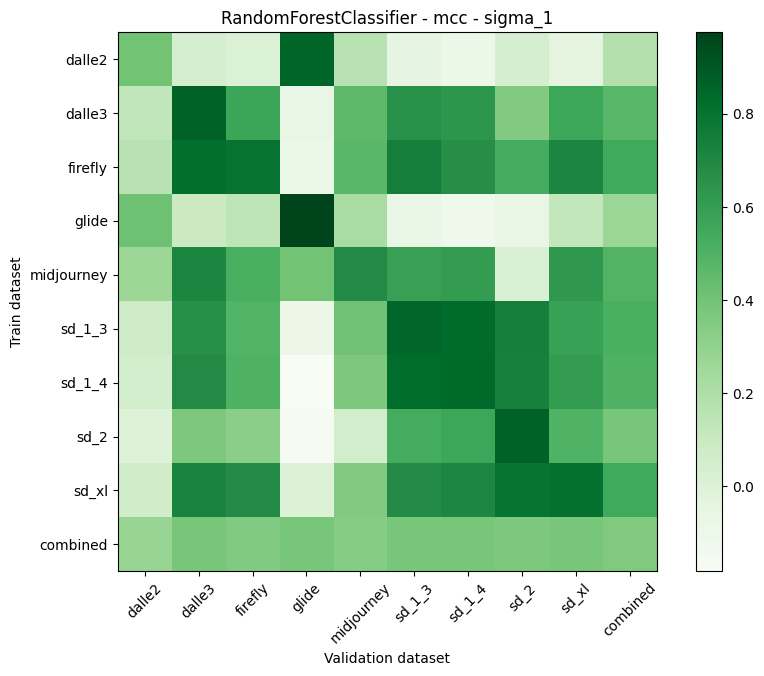

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.397491  0.037368  0.011223  0.853965    0.164784 -0.046243   
dalle3         0.127298  0.865559  0.566137 -0.070370    0.457093  0.655819   
firefly        0.162529  0.821135  0.794721 -0.087608    0.472502  0.743644   
glide          0.412632  0.087675  0.140770  0.975285    0.222719 -0.077969   
midjourney     0.261371  0.708764  0.521717  0.400037    0.688897  0.587732   
sd_1_3         0.073332  0.661557  0.495128 -0.094298    0.402460  0.852144   
sd_1_4         0.043579  0.688093  0.503892 -0.182788    0.364975  0.828782   
sd_2          -0.004578  0.361231  0.321540 -0.173335    0.055288  0.530011   
sd_xl          0.063587  0.719570  0.689768  0.002568    0.349758  0.683879   
combined       0.281502  0.379597  0.353195  0.379597    0.340510  0.379597   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2        -0.089599  0.037368 -0.036104  0.180361  
dalle3         0.633048  0.346809  0.560635  0.472190  
firefly        0.670644  0.527806  0.712756  0.541416  
glide         -0.114638 -0.077969  0.120980  0.268140  
midjourney     0.606170  0.013838  0.624829  0.489124  
sd_1_3         0.832334  0.738111  0.582701  0.516886  
sd_1_4         0.835606  0.731138  0.605526  0.504510  
sd_2           0.560881  0.862786  0.499118  0.382018  
sd_xl          0.707575  0.793945  0.806797  0.541717  
combined       0.379597  0.366217  0.379597  0.358940

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.397491  0.037368  0.011223  0.853965    0.164784 -0.046243   
dalle3         0.127298  0.865559  0.566137 -0.070370    0.457093  0.655819   
firefly        0.162529  0.821135  0.794721 -0.087608    0.472502  0.743644   
glide          0.412632  0.087675  0.140770  0.975285    0.222719 -0.077969   
midjourney     0.261371  0.708764  0.521717  0.400037    0.688897  0.587732   
sd_1_3         0.073332  0.661557  0.495128 -0.094298    0.402460  0.852144   
sd_1_4         0.043579  0.688093  0.503892 -0.182788    0.364975  0.828782   
sd_2          -0.004578  0.361231  0.321540 -0.173335    0.055288  0.530011   
sd_xl          0.063587  0.719570  0.689768  0.002568    0.349758  0.683879   
combined       0.281502  0.379597  0.353195  0.379597    0.340510  0.379597   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2        -0.089599  0.037368 -0.036104  0.147806  
dalle3         0.633048  0.346809  0.560635  0.460225  
firefly        0.670644  0.527806  0.712756  0.535348  
glide         -0.114638 -0.077969  0.120980  0.187720  
midjourney     0.606170  0.013838  0.624829  0.490373  
sd_1_3         0.832334  0.738111  0.582701  0.504830  
sd_1_4         0.835606  0.731138  0.605526  0.490978  
sd_2           0.560881  0.862786  0.499118  0.334771  
sd_xl          0.707575  0.793945  0.806797  0.535272  
combined       0.379597  0.366217  0.379597  0.359935

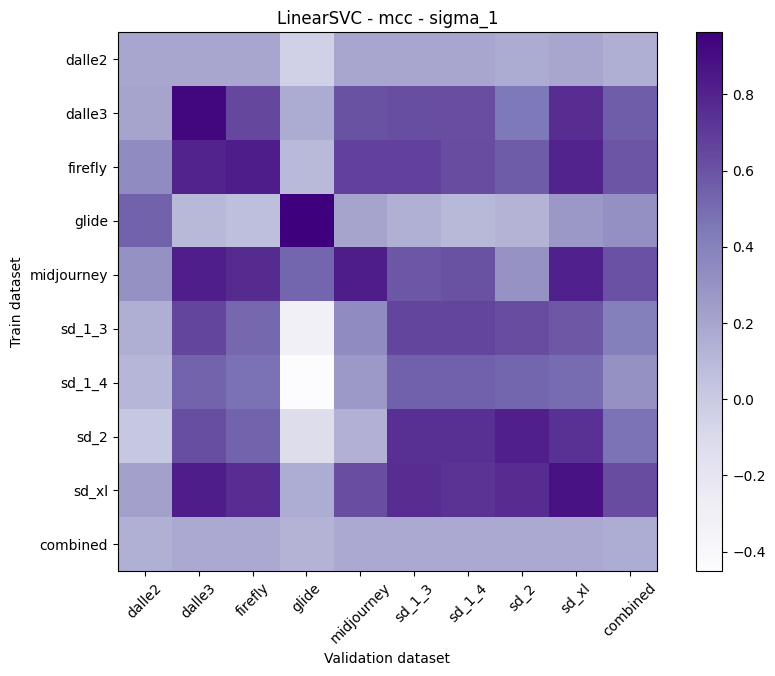

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.192248  0.192248  0.192248 -0.040182    0.192248  0.192248   
dalle3         0.206129  0.933353  0.644829  0.170490    0.602300  0.618172   
firefly        0.338488  0.797448  0.826546  0.093496    0.675428  0.675428   
glide          0.540553  0.098456  0.065237  0.963139    0.202119  0.145945   
midjourney     0.311029  0.819782  0.764972  0.526420    0.826836  0.584405   
sd_1_3         0.150991  0.657134  0.511784 -0.309541    0.338378  0.657134   
sd_1_4         0.111039  0.534045  0.476556 -0.451487    0.266594  0.544093   
sd_2           0.013396  0.618591  0.532948 -0.128584    0.137333  0.750813   
sd_xl          0.226930  0.827839  0.756212  0.162529    0.623861  0.756212   
combined       0.147078  0.173335  0.173335  0.123626    0.173335  0.173335   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.192248  0.168218  0.192248  0.151042  
dalle3         0.623482  0.445158  0.755216  0.557391  
firefly        0.631089  0.563959  0.797448  0.591432  
glide          0.098456  0.127896  0.270395  0.312511  
midjourney     0.602114  0.299461  0.812774  0.607394  
sd_1_3         0.657134  0.631210  0.581572  0.411740  
sd_1_4         0.544093  0.524139  0.495217  0.307474  
sd_2           0.750813  0.815796  0.736903  0.469415  
sd_xl          0.731201  0.762544  0.876001  0.628998  
combined       0.173335  0.173335  0.173335  0.164227

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.192248  0.192248  0.192248 -0.040182    0.192248  0.192248   
dalle3         0.206129  0.933353  0.644829  0.170490    0.602300  0.618172   
firefly        0.338488  0.797448  0.826546  0.093496    0.675428  0.675428   
glide          0.540553  0.098456  0.065237  0.963139    0.202119  0.145945   
midjourney     0.311029  0.819782  0.764972  0.526420    0.826836  0.584405   
sd_1_3         0.150991  0.657134  0.511784 -0.309541    0.338378  0.657134   
sd_1_4         0.111039  0.534045  0.476556 -0.451487    0.266594  0.544093   
sd_2           0.013396  0.618591  0.532948 -0.128584    0.137333  0.750813   
sd_xl          0.226930  0.827839  0.756212  0.162529    0.623861  0.756212   
combined       0.147078  0.173335  0.173335  0.123626    0.173335  0.173335   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.192248  0.168218  0.192248  0.163752  
dalle3         0.623482  0.445158  0.755216  0.555459  
firefly        0.631089  0.563959  0.797448  0.599926  
glide          0.098456  0.127896  0.270395  0.279133  
midjourney     0.602114  0.299461  0.812774  0.616421  
sd_1_3         0.657134  0.631210  0.581572  0.430644  
sd_1_4         0.544093  0.524139  0.495217  0.338254  
sd_2           0.750813  0.815796  0.736903  0.469779  
sd_xl          0.731201  0.762544  0.876001  0.635925  
combined       0.173335  0.173335  0.173335  0.164894









 ################ Evaluating models trained on standardAugmented and tested on sigma_2. ################


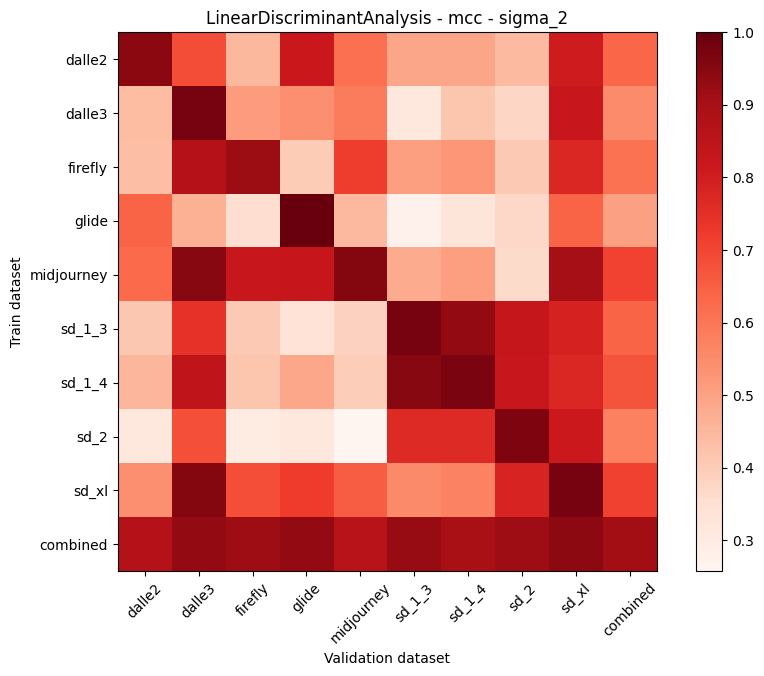

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.944159  0.685535  0.450091  0.816867    0.613056  0.491170   
dalle3         0.438479  0.975285  0.513839  0.543506    0.587928  0.319249   
firefly        0.432880  0.868736  0.919537  0.400838    0.717303  0.506082   
glide          0.637715  0.466618  0.354865  1.000000    0.447110  0.273113   
midjourney     0.624313  0.950045  0.819273  0.824904    0.956388  0.479338   
sd_1_3         0.412632  0.745014  0.407398  0.336577    0.386203  0.975285   
sd_1_4         0.453769  0.843119  0.417843  0.488974    0.396855  0.949982   
sd_2           0.313035  0.680178  0.301097  0.318918    0.257123  0.764257   
sd_xl          0.543506  0.956248  0.682957  0.718895    0.652627  0.553375   
combined       0.868736  0.932634  0.913051  0.932634    0.862551  0.926064   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.491170  0.444906  0.805446  0.632423  
dalle3         0.417843  0.375431  0.820677  0.551731  
firefly        0.526811  0.406220  0.773493  0.610612  
glide          0.327141  0.370943  0.637715  0.502929  
midjourney     0.509480  0.364264  0.906715  0.705447  
sd_1_3         0.931414  0.826249  0.787742  0.638150  
sd_1_4         0.968899  0.820677  0.771571  0.669991  
sd_2           0.764257  0.962771  0.813667  0.575394  
sd_xl          0.568176  0.782331  0.975285  0.707985  
combined       0.893833  0.913051  0.939247  0.908750

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.944159  0.685535  0.450091  0.816867    0.613056  0.491170   
dalle3         0.438479  0.975285  0.513839  0.543506    0.587928  0.319249   
firefly        0.432880  0.868736  0.919537  0.400838    0.717303  0.506082   
glide          0.637715  0.466618  0.354865  1.000000    0.447110  0.273113   
midjourney     0.624313  0.950045  0.819273  0.824904    0.956388  0.479338   
sd_1_3         0.412632  0.745014  0.407398  0.336577    0.386203  0.975285   
sd_1_4         0.453769  0.843119  0.417843  0.488974    0.396855  0.949982   
sd_2           0.313035  0.680178  0.301097  0.318918    0.257123  0.764257   
sd_xl          0.543506  0.956248  0.682957  0.718895    0.652627  0.553375   
combined       0.868736  0.932634  0.913051  0.932634    0.862551  0.926064   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.491170  0.444906  0.805446  0.638044  
dalle3         0.417843  0.375431  0.820677  0.554693  
firefly        0.526811  0.406220  0.773493  0.616878  
glide          0.327141  0.370943  0.637715  0.501691  
midjourney     0.509480  0.364264  0.906715  0.714969  
sd_1_3         0.931414  0.826249  0.787742  0.645390  
sd_1_4         0.968899  0.820677  0.771571  0.679076  
sd_2           0.764257  0.962771  0.813667  0.575034  
sd_xl          0.568176  0.782331  0.975285  0.714822  
combined       0.893833  0.913051  0.939247  0.909089

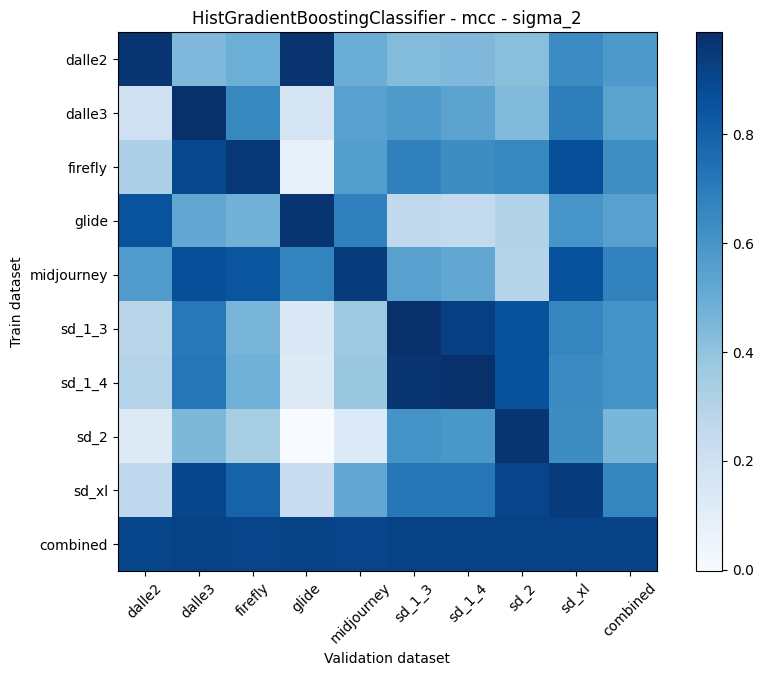

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.968899  0.443592  0.488974  0.975285    0.493962  0.433349   
dalle3         0.201753  0.981260  0.654305  0.167790    0.542593  0.581277   
firefly        0.318918  0.894656  0.956388  0.069776    0.559344  0.675047   
glide          0.853458  0.519477  0.474285  0.969195    0.680178  0.257123   
midjourney     0.567270  0.869643  0.845894  0.669821    0.944159  0.547005   
sd_1_3         0.285467  0.709013  0.459456  0.138629    0.366488  0.987570   
sd_1_4         0.291682  0.724191  0.479250  0.127912    0.382602  0.968762   
sd_2           0.120980  0.448688  0.336577 -0.003003    0.131077  0.607729   
sd_xl          0.263648  0.900668  0.791484  0.222956    0.519477  0.716462   
combined       0.902374  0.915852  0.909091  0.915852    0.909091  0.915852   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.443592  0.417843  0.637594  0.581889  
dalle3         0.537752  0.434379  0.688961  0.539904  
firefly        0.634388  0.654638  0.870930  0.630466  
glide          0.250504  0.307096  0.599241  0.546619  
midjourney     0.521671  0.295808  0.863660  0.673884  
sd_1_3         0.926201  0.856993  0.659227  0.601185  
sd_1_4         0.987570  0.862600  0.639591  0.608732  
sd_2           0.592872  0.968899  0.632600  0.456585  
sd_xl          0.721704  0.906715  0.943742  0.661988  
combined       0.915852  0.915852  0.915852  0.912842

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.968899  0.443592  0.488974  0.975285    0.493962  0.433349   
dalle3         0.201753  0.981260  0.654305  0.167790    0.542593  0.581277   
firefly        0.318918  0.894656  0.956388  0.069776    0.559344  0.675047   
glide          0.853458  0.519477  0.474285  0.969195    0.680178  0.257123   
midjourney     0.567270  0.869643  0.845894  0.669821    0.944159  0.547005   
sd_1_3         0.285467  0.709013  0.459456  0.138629    0.366488  0.987570   
sd_1_4         0.291682  0.724191  0.479250  0.127912    0.382602  0.968762   
sd_2           0.120980  0.448688  0.336577 -0.003003    0.131077  0.607729   
sd_xl          0.263648  0.900668  0.791484  0.222956    0.519477  0.716462   
combined       0.902374  0.915852  0.909091  0.915852    0.909091  0.915852   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.443592  0.417843  0.637594  0.589232  
dalle3         0.537752  0.434379  0.688961  0.532230  
firefly        0.634388  0.654638  0.870930  0.626009  
glide          0.250504  0.307096  0.599241  0.545617  
midjourney     0.521671  0.295808  0.863660  0.680548  
sd_1_3         0.926201  0.856993  0.659227  0.598783  
sd_1_4         0.987570  0.862600  0.639591  0.607129  
sd_2           0.592872  0.968899  0.632600  0.426269  
sd_xl          0.721704  0.906715  0.943742  0.665206  
combined       0.915852  0.915852  0.915852  0.912852

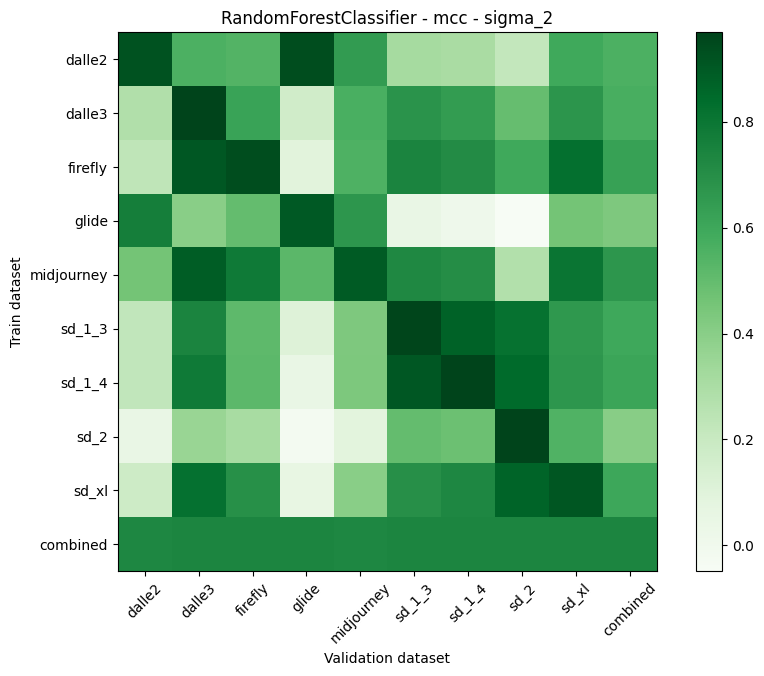

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.925028  0.557135  0.541940  0.937742    0.649040  0.313691   
dalle3         0.277530  0.968754  0.616296  0.167222    0.567326  0.680850   
firefly        0.231867  0.906246  0.937742  0.093725    0.552070  0.738889   
glide          0.762766  0.399633  0.497368  0.898611    0.668392  0.049617   
midjourney     0.459207  0.887503  0.785005  0.521631    0.893833  0.722828   
sd_1_3         0.223218  0.742125  0.513501  0.106965    0.428546  0.962487   
sd_1_4         0.222719  0.782331  0.518793  0.047928    0.433349  0.907162   
sd_2           0.047928  0.353472  0.307419 -0.024172    0.087675  0.498942   
sd_xl          0.178929  0.820858  0.691862  0.055288    0.399470  0.697252   
combined       0.729428  0.737447  0.737447  0.737447    0.729428  0.737447   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.301823  0.218026  0.592659  0.558824  
dalle3         0.645913  0.493797  0.670817  0.570040  
firefly        0.712008  0.592659  0.822617  0.624435  
glide          0.013106 -0.048924  0.459524  0.431802  
midjourney     0.706307  0.275288  0.802466  0.667159  
sd_1_3         0.872767  0.816728  0.660827  0.598846  
sd_1_4         0.968899  0.843119  0.667744  0.607729  
sd_2           0.478971  0.968899  0.548441  0.401553  
sd_xl          0.729948  0.868903  0.912714  0.601638  
combined       0.737447  0.737447  0.737447  0.735659

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.925028  0.557135  0.541940  0.937742    0.649040  0.313691   
dalle3         0.277530  0.968754  0.616296  0.167222    0.567326  0.680850   
firefly        0.231867  0.906246  0.937742  0.093725    0.552070  0.738889   
glide          0.762766  0.399633  0.497368  0.898611    0.668392  0.049617   
midjourney     0.459207  0.887503  0.785005  0.521631    0.893833  0.722828   
sd_1_3         0.223218  0.742125  0.513501  0.106965    0.428546  0.962487   
sd_1_4         0.222719  0.782331  0.518793  0.047928    0.433349  0.907162   
sd_2           0.047928  0.353472  0.307419 -0.024172    0.087675  0.498942   
sd_xl          0.178929  0.820858  0.691862  0.055288    0.399470  0.697252   
combined       0.729428  0.737447  0.737447  0.737447    0.729428  0.737447   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.301823  0.218026  0.592659  0.559676  
dalle3         0.645913  0.493797  0.670817  0.565389  
firefly        0.712008  0.592659  0.822617  0.620869  
glide          0.013106 -0.048924  0.459524  0.411121  
midjourney     0.706307  0.275288  0.802466  0.672674  
sd_1_3         0.872767  0.816728  0.660827  0.591907  
sd_1_4         0.968899  0.843119  0.667744  0.599116  
sd_2           0.478971  0.968899  0.548441  0.363064  
sd_xl          0.729948  0.868903  0.912714  0.595025  
combined       0.737447  0.737447  0.737447  0.735665

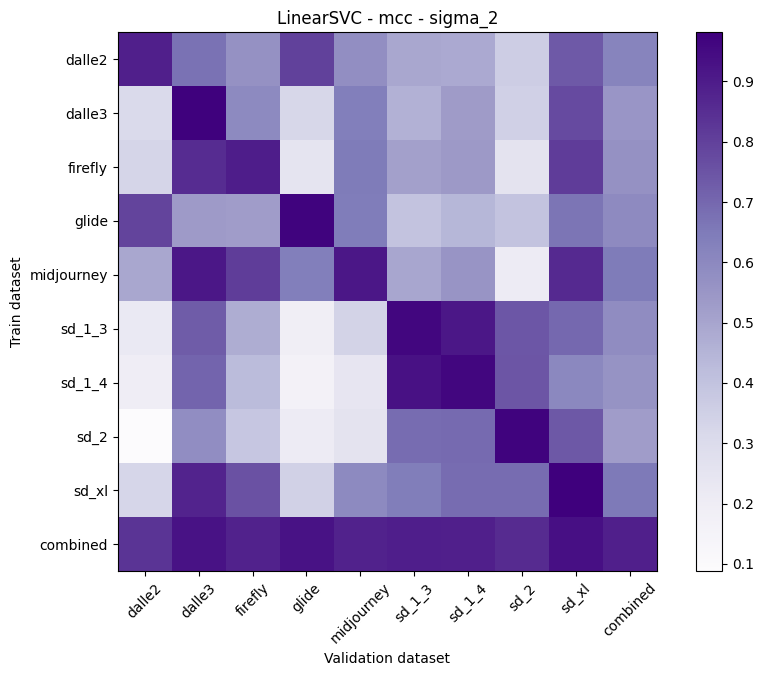

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.887503  0.673728  0.568288  0.796619    0.578688  0.490507   
dalle3         0.308300  0.975062  0.596669  0.320114    0.636013  0.458956   
firefly        0.330636  0.852554  0.894211  0.250975    0.646645  0.515406   
glide          0.791484  0.534441  0.524468  0.969195    0.644495  0.396717   
midjourney     0.489326  0.914159  0.807113  0.637401    0.914159  0.494584   
sd_1_3         0.222956  0.726962  0.474285  0.185473    0.336256  0.962771   
sd_1_4         0.192531  0.708558  0.423032  0.167840    0.243793  0.931414   
sd_2           0.087675  0.582986  0.386203  0.207963    0.257244  0.688051   
sd_xl          0.325931  0.878522  0.757791  0.343059    0.596669  0.640959   
combined       0.831696  0.926703  0.881322  0.926703    0.881322  0.894088   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.485306  0.357002  0.733938  0.615279  
dalle3         0.528216  0.348671  0.773620  0.548870  
firefly        0.535528  0.257534  0.812339  0.566787  
glide          0.443714  0.396717  0.664821  0.592023  
midjourney     0.552365  0.209013  0.862487  0.646403  
sd_1_3         0.912795  0.742837  0.695646  0.586476  
sd_1_4         0.962553  0.745014  0.602773  0.559953  
sd_2           0.693158  0.968899  0.739757  0.525941  
sd_xl          0.685883  0.685883  0.981410  0.650876  
combined       0.887686  0.856233  0.933353  0.890526

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.887503  0.673728  0.568288  0.796619    0.578688  0.490507   
dalle3         0.308300  0.975062  0.596669  0.320114    0.636013  0.458956   
firefly        0.330636  0.852554  0.894211  0.250975    0.646645  0.515406   
glide          0.791484  0.534441  0.524468  0.969195    0.644495  0.396717   
midjourney     0.489326  0.914159  0.807113  0.637401    0.914159  0.494584   
sd_1_3         0.222956  0.726962  0.474285  0.185473    0.336256  0.962771   
sd_1_4         0.192531  0.708558  0.423032  0.167840    0.243793  0.931414   
sd_2           0.087675  0.582986  0.386203  0.207963    0.257244  0.688051   
sd_xl          0.325931  0.878522  0.757791  0.343059    0.596669  0.640959   
combined       0.831696  0.926703  0.881322  0.926703    0.881322  0.894088   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.485306  0.357002  0.733938  0.619064  
dalle3         0.528216  0.348671  0.773620  0.549513  
firefly        0.535528  0.257534  0.812339  0.566203  
glide          0.443714  0.396717  0.664821  0.596228  
midjourney     0.552365  0.209013  0.862487  0.653401  
sd_1_3         0.912795  0.742837  0.695646  0.584442  
sd_1_4         0.962553  0.745014  0.602773  0.553056  
sd_2           0.693158  0.968899  0.739757  0.512437  
sd_xl          0.685883  0.685883  0.981410  0.655123  
combined       0.887686  0.856233  0.933353  0.891011









 ################ Evaluating models trained on standardAugmented and tested on sigma_3. ################


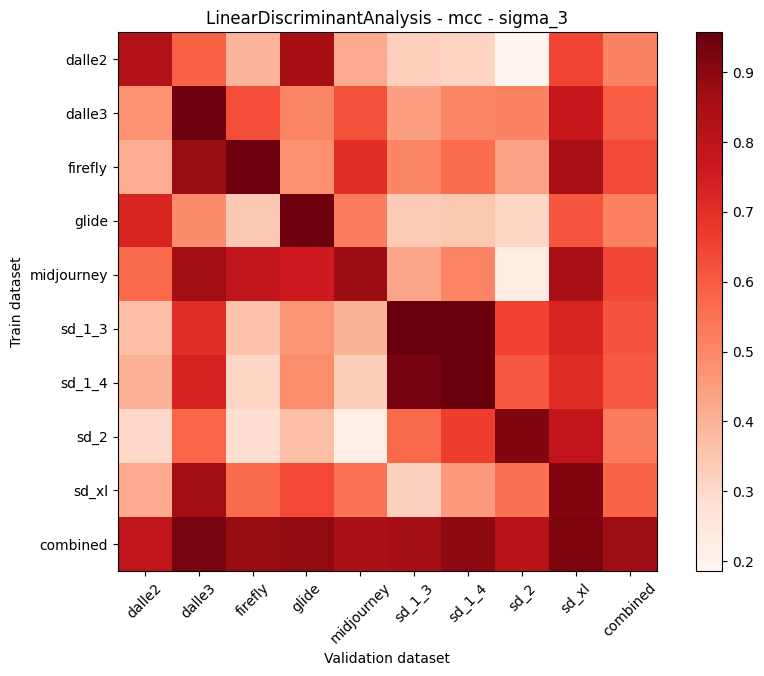

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.830561  0.589249  0.391382  0.853458    0.417812  0.324747   
dalle3         0.471859  0.944591  0.625661  0.502695    0.620487  0.445925   
firefly        0.412573  0.876814  0.943742  0.479338    0.706025  0.504474   
glide          0.728084  0.491170  0.342530  0.944159    0.526741  0.336848   
midjourney     0.573995  0.860808  0.794270  0.756150    0.874632  0.430592   
sd_1_3         0.370943  0.705388  0.360266  0.466618    0.397005  0.957186   
sd_1_4         0.405121  0.732097  0.306304  0.489684    0.329637  0.932773   
sd_2           0.303871  0.576441  0.285467  0.371896    0.217251  0.571606   
sd_xl          0.418561  0.862452  0.570762  0.639475    0.549845  0.318806   
combined       0.795152  0.927489  0.881570  0.888007    0.843730  0.856199   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.313035  0.185473  0.649562  0.511148  
dalle3         0.502695  0.512930  0.781553  0.596440  
firefly        0.564323  0.438569  0.847692  0.634948  
glide          0.348173  0.307783  0.613056  0.514907  
midjourney     0.507463  0.229411  0.847167  0.643484  
sd_1_3         0.951218  0.652068  0.725120  0.615504  
sd_1_4         0.956727  0.604813  0.707061  0.603747  
sd_2           0.664157  0.914356  0.786348  0.526983  
sd_xl          0.455718  0.555068  0.913533  0.582415  
combined       0.894484  0.813137  0.920802  0.868106

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.830561  0.589249  0.391382  0.853458    0.417812  0.324747   
dalle3         0.471859  0.944591  0.625661  0.502695    0.620487  0.445925   
firefly        0.412573  0.876814  0.943742  0.479338    0.706025  0.504474   
glide          0.728084  0.491170  0.342530  0.944159    0.526741  0.336848   
midjourney     0.573995  0.860808  0.794270  0.756150    0.874632  0.430592   
sd_1_3         0.370943  0.705388  0.360266  0.466618    0.397005  0.957186   
sd_1_4         0.405121  0.732097  0.306304  0.489684    0.329637  0.932773   
sd_2           0.303871  0.576441  0.285467  0.371896    0.217251  0.571606   
sd_xl          0.418561  0.862452  0.570762  0.639475    0.549845  0.318806   
combined       0.795152  0.927489  0.881570  0.888007    0.843730  0.856199   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.313035  0.185473  0.649562  0.506142  
dalle3         0.502695  0.512930  0.781553  0.600933  
firefly        0.564323  0.438569  0.847692  0.641506  
glide          0.348173  0.307783  0.613056  0.515394  
midjourney     0.507463  0.229411  0.847167  0.652721  
sd_1_3         0.951218  0.652068  0.725120  0.620646  
sd_1_4         0.956727  0.604813  0.707061  0.607135  
sd_2           0.664157  0.914356  0.786348  0.521266  
sd_xl          0.455718  0.555068  0.913533  0.587136  
combined       0.894484  0.813137  0.920802  0.868952

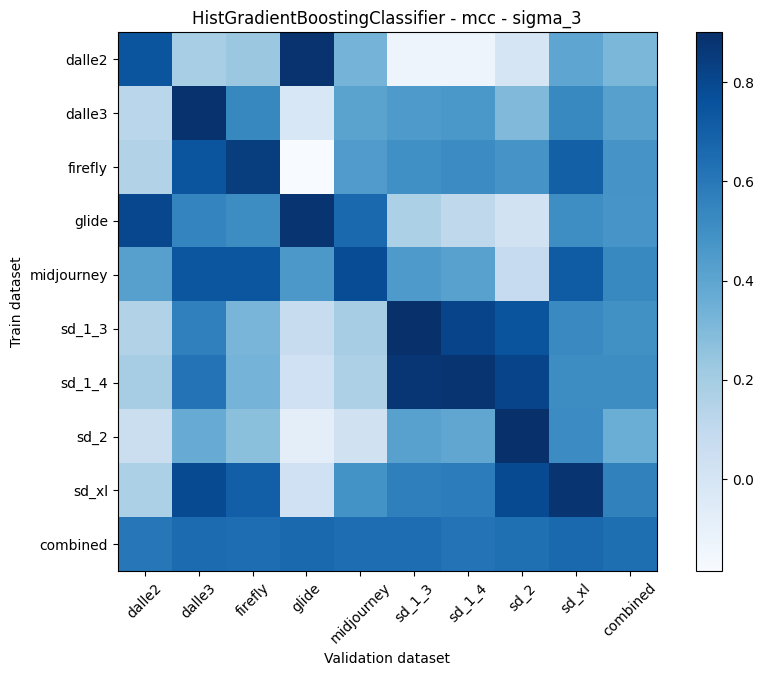

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.744173  0.189830  0.228494  0.886010    0.329786 -0.133571   
dalle3         0.125223  0.888469  0.533915 -0.017106    0.411660  0.454530   
firefly        0.149768  0.744164  0.845097 -0.185779    0.444730  0.500707   
glide          0.800746  0.546128  0.512968  0.881614    0.659630  0.171502   
midjourney     0.422977  0.742647  0.742647  0.463309    0.777603  0.451752   
sd_1_3         0.150104  0.563242  0.319249  0.075301    0.192531  0.895240   
sd_1_4         0.192531  0.617659  0.330853  0.032559    0.167840  0.871779   
sd_2           0.053062  0.369899  0.270395 -0.083081    0.026551  0.418126   
sd_xl          0.172331  0.787425  0.703076  0.031763    0.486559  0.567954   
combined       0.603071  0.653405  0.644811  0.662086    0.644811  0.644811   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2        -0.133571 -0.006677  0.396954  0.314487  
dalle3         0.465159  0.299433  0.528629  0.424235  
firefly        0.517608  0.478267  0.699894  0.477023  
glide          0.108384  0.020104  0.507463  0.473288  
midjourney     0.417238  0.085543  0.715461  0.528946  
sd_1_3         0.815129  0.750288  0.523743  0.496729  
sd_1_4         0.877598  0.815129  0.513839  0.512737  
sd_2           0.391591  0.900293  0.515406  0.360716  
sd_xl          0.578914  0.787425  0.878132  0.557636  
combined       0.619530  0.636302  0.662086  0.641019

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.744173  0.189830  0.228494  0.886010    0.329786 -0.133571   
dalle3         0.125223  0.888469  0.533915 -0.017106    0.411660  0.454530   
firefly        0.149768  0.744164  0.845097 -0.185779    0.444730  0.500707   
glide          0.800746  0.546128  0.512968  0.881614    0.659630  0.171502   
midjourney     0.422977  0.742647  0.742647  0.463309    0.777603  0.451752   
sd_1_3         0.150104  0.563242  0.319249  0.075301    0.192531  0.895240   
sd_1_4         0.192531  0.617659  0.330853  0.032559    0.167840  0.871779   
sd_2           0.053062  0.369899  0.270395 -0.083081    0.026551  0.418126   
sd_xl          0.172331  0.787425  0.703076  0.031763    0.486559  0.567954   
combined       0.603071  0.653405  0.644811  0.662086    0.644811  0.644811   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2        -0.133571 -0.006677  0.396954  0.277936  
dalle3         0.465159  0.299433  0.528629  0.409990  
firefly        0.517608  0.478267  0.699894  0.466051  
glide          0.108384  0.020104  0.507463  0.467615  
midjourney     0.417238  0.085543  0.715461  0.535464  
sd_1_3         0.815129  0.750288  0.523743  0.476092  
sd_1_4         0.877598  0.815129  0.513839  0.491088  
sd_2           0.391591  0.900293  0.515406  0.318027  
sd_xl          0.578914  0.787425  0.878132  0.554842  
combined       0.619530  0.636302  0.662086  0.641212

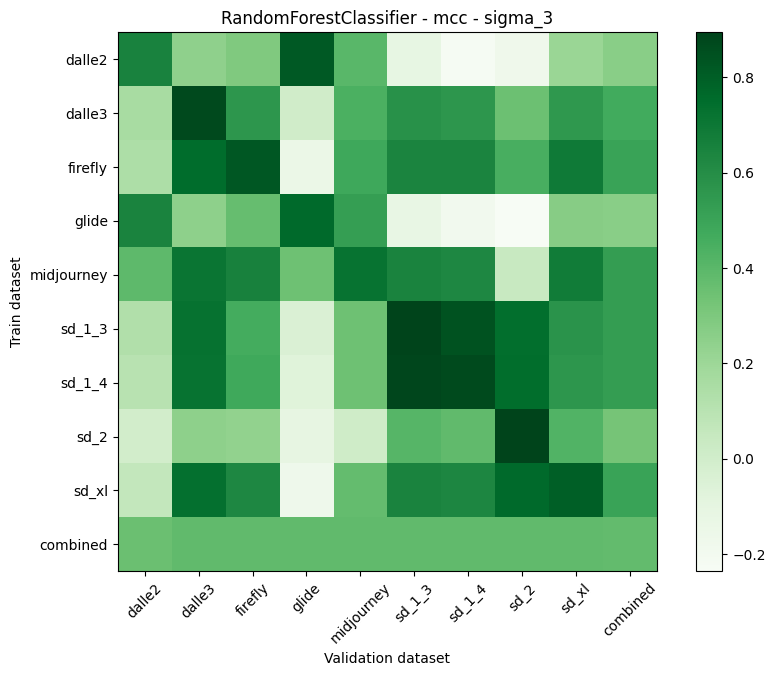

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.649916  0.245214  0.292276  0.819192    0.401392 -0.112917   
dalle3         0.159321  0.875171  0.562897  0.006187    0.441767  0.584022   
firefly        0.141289  0.751091  0.825420 -0.145159    0.482328  0.638510   
glide          0.646224  0.246714  0.365295  0.757989    0.525305 -0.122848   
midjourney     0.389542  0.712801  0.651811  0.343130    0.719783  0.645222   
sd_1_3         0.128382  0.725592  0.457683 -0.042836    0.343532  0.894484   
sd_1_4         0.103585  0.719946  0.478800 -0.070840    0.343532  0.881570   
sd_2          -0.004302  0.246641  0.233370 -0.111150    0.009494  0.409048   
sd_xl          0.063623  0.731637  0.626530 -0.168749    0.369991  0.644533   
combined       0.353195  0.379597  0.379597  0.379597    0.379597  0.379597   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2        -0.219445 -0.173899  0.209074  0.262335  
dalle3         0.562897  0.349169  0.552365  0.467667  
firefly        0.638510  0.448616  0.687390  0.503653  
glide         -0.190072 -0.236003  0.270424  0.262528  
midjourney     0.625655  0.040627  0.678527  0.528237  
sd_1_3         0.843730  0.742659  0.573448  0.531926  
sd_1_4         0.868811  0.748392  0.562897  0.531342  
sd_2           0.382135  0.893743  0.424950  0.321043  
sd_xl          0.632509  0.757648  0.797803  0.504910  
combined       0.379597  0.379597  0.379597  0.376592

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.649916  0.245214  0.292276  0.819192    0.401392 -0.112917   
dalle3         0.159321  0.875171  0.562897  0.006187    0.441767  0.584022   
firefly        0.141289  0.751091  0.825420 -0.145159    0.482328  0.638510   
glide          0.646224  0.246714  0.365295  0.757989    0.525305 -0.122848   
midjourney     0.389542  0.712801  0.651811  0.343130    0.719783  0.645222   
sd_1_3         0.128382  0.725592  0.457683 -0.042836    0.343532  0.894484   
sd_1_4         0.103585  0.719946  0.478800 -0.070840    0.343532  0.881570   
sd_2          -0.004302  0.246641  0.233370 -0.111150    0.009494  0.409048   
sd_xl          0.063623  0.731637  0.626530 -0.168749    0.369991  0.644533   
combined       0.353195  0.379597  0.379597  0.379597    0.379597  0.379597   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2        -0.219445 -0.173899  0.209074  0.234534  
dalle3         0.562897  0.349169  0.552365  0.454866  
firefly        0.638510  0.448616  0.687390  0.496444  
glide         -0.190072 -0.236003  0.270424  0.251448  
midjourney     0.625655  0.040627  0.678527  0.534122  
sd_1_3         0.843730  0.742659  0.573448  0.518519  
sd_1_4         0.868811  0.748392  0.562897  0.515188  
sd_2           0.382135  0.893743  0.424950  0.275992  
sd_xl          0.632509  0.757648  0.797803  0.495058  
combined       0.379597  0.379597  0.379597  0.376664

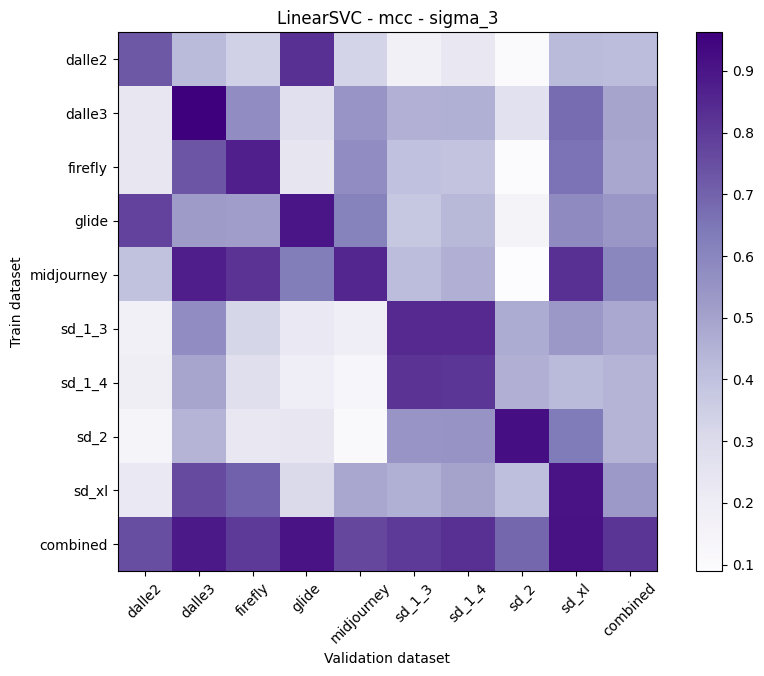

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.724087  0.423032  0.342254  0.831846    0.330853  0.176302   
dalle3         0.237541  0.962487  0.572212  0.271128    0.542895  0.453929   
firefly        0.237541  0.731766  0.872767  0.244494    0.572212  0.402655   
glide          0.781214  0.519005  0.513591  0.898611    0.612048  0.377564   
midjourney     0.397024  0.874995  0.819619  0.628802    0.856233  0.413201   
sd_1_3         0.176723  0.571606  0.321619  0.224707    0.193673  0.845859   
sd_1_4         0.185171  0.490711  0.279458  0.193719    0.135665  0.822364   
sd_2           0.140770  0.443592  0.229875  0.236896    0.110426  0.543506   
sd_xl          0.222956  0.758873  0.706025  0.307096    0.484382  0.459058   
combined       0.749513  0.887686  0.801729  0.907011    0.766693  0.801729   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.229875  0.099350  0.423032  0.415530  
dalle3         0.458956  0.264630  0.675828  0.498186  
firefly        0.392122  0.095008  0.655847  0.482794  
glide          0.426966  0.151393  0.578914  0.537681  
midjourney     0.455718  0.088960  0.831696  0.595855  
sd_1_3         0.845859  0.474320  0.532908  0.479250  
sd_1_4         0.811803  0.456894  0.422337  0.442193  
sd_2           0.548441  0.919218  0.637594  0.443025  
sd_xl          0.499462  0.407311  0.906715  0.530010  
combined       0.831696  0.688152  0.913533  0.814291

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.724087  0.423032  0.342254  0.831846    0.330853  0.176302   
dalle3         0.237541  0.962487  0.572212  0.271128    0.542895  0.453929   
firefly        0.237541  0.731766  0.872767  0.244494    0.572212  0.402655   
glide          0.781214  0.519005  0.513591  0.898611    0.612048  0.377564   
midjourney     0.397024  0.874995  0.819619  0.628802    0.856233  0.413201   
sd_1_3         0.176723  0.571606  0.321619  0.224707    0.193673  0.845859   
sd_1_4         0.185171  0.490711  0.279458  0.193719    0.135665  0.822364   
sd_2           0.140770  0.443592  0.229875  0.236896    0.110426  0.543506   
sd_xl          0.222956  0.758873  0.706025  0.307096    0.484382  0.459058   
combined       0.749513  0.887686  0.801729  0.907011    0.766693  0.801729   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.229875  0.099350  0.423032  0.397848  
dalle3         0.458956  0.264630  0.675828  0.493290  
firefly        0.392122  0.095008  0.655847  0.467157  
glide          0.426966  0.151393  0.578914  0.539923  
midjourney     0.455718  0.088960  0.831696  0.596250  
sd_1_3         0.845859  0.474320  0.532908  0.465253  
sd_1_4         0.811803  0.456894  0.422337  0.422014  
sd_2           0.548441  0.919218  0.637594  0.423369  
sd_xl          0.499462  0.407311  0.906715  0.527986  
combined       0.831696  0.688152  0.913533  0.816416

In [14]:
print("########################### MCC ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "mcc"
    evaluation_data_name = "Validation"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

## Test data

In [16]:
perturbed_results = {}   

for perturbed_name, X_test, y_test in zip(perturbed_X_test.keys(), perturbed_X_test.values(), perturbed_y_test.values()):
    results = {}
    X_train = perturbed_X_train["standard"]
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    for dataset_name in models.keys():
        print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
        for test_dataset_name in X_test.keys():
            print(f"\n\nValidation set: {test_dataset_name}")
            for model_name, model in models[dataset_name].items():
                print()  
                X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
                X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
                accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
                model_results = {
                    "accuracy": accuracy,
                    "f1": f1,
                    "precision": precision,
                    "recall": recall,
                    "mcc": mcc
                }
                results[(dataset_name, test_dataset_name, model_name)] = model_results
                
    perturbed_results[perturbed_name] = results









 ################ Evaluating models trained on standardAugmented and tested on standard. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9925
F1: 0.9925
Precision: 0.9926
Recall: 0.9925
MCC: 0.9851

Model: LinearDiscriminantAnalysis
Accuracy: 0.9850
F1: 0.9850
Precision: 0.9852
Recall: 0.9850
MCC: 0.9702

Model: RandomForestClassifier
Accuracy: 0.9900
F1: 0.9900
Precision: 0.9902
Recall: 0.9900
MCC: 0.9802

Model: LinearSVC
Accuracy: 0.9900
F1: 0.9900
Precision: 0.9900
Recall: 0.9900
MCC: 0.9800


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.8525
F1: 0.8499
Precision: 0.8791
Recall: 0.8525
MCC: 0.7311

Model: LinearDiscriminantAnalysis
Accuracy: 0.8750
F1: 0.8737
Precision: 0.8906
Recall: 0.8750
MCC: 0.7655

Model: RandomForestClassifier
Accuracy: 0.8350
F1: 0.8315
Precision: 0.8658
Recall: 0.8350
MCC: 0.7001

Model: LinearSVC
Accuracy: 0.9675
F1: 0.9675
P

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5250
F1: 0.3903
Precision: 0.7148
Recall: 0.5250
MCC: 0.1466

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: dalle3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3698
Precision: 0.6913
Recall: 0.5150
MCC: 0.1071



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3377
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: glide



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950

Model: RandomForestClassifier
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900

Model: LinearSVC
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5175
F1: 0.3750
Precision: 0.6989
Recall: 0.5175
MCC: 0.1180

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5800
F1: 0.4926
Precision: 0.7572
Recall: 0.5800
MCC: 0.2869



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3377
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5800
F1: 0.4926
Precision: 0.7572
Recall: 0.5800
MCC: 0.2869

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3486
Precision: 0.6263
Recall: 0.5050
MCC: 0.0503


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.6325
F1: 0.5769
Precision: 0.7793
Recall: 0.6325
MCC: 0.3848



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5525
F1: 0.4435
Precision: 0.7422
Recall: 0.5525
MCC: 0.2255


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5750
F1: 0.4840
Precision: 0.7548
Recall: 0.5750
MCC: 0.2765



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425

Model: LinearDiscriminantAnalysis
Accuracy: 0.6025
F1: 0.5301
Precision: 0.7671
Recall: 0.6025
MCC: 0.3309

Model: RandomForestClassifier
Accuracy: 0.5550
F1: 0.4451
Precision: 0.7646
Recall: 0.5550
MCC: 0.2412

Model: LinearSVC
Accuracy: 0.5603
F1: 0.4578
Precision: 0.7470
Recall: 0.5603
MCC: 0.2440




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9525
F1: 0.9525
Precision: 0.9534
Recall: 0.9525
MCC: 0.9059

Model: LinearDiscriminantAnalysis
Accuracy: 0.7525
F1: 0.7402
Precision: 0.8114
Recall: 0.7525
MCC: 0.5608

Model: RandomForestClassifier
Accuracy: 0.8950
F1: 0.8945
Preci

### Accuracy - Test

########################### Accuracy ###########################








 ################ Evaluating models trained on standardAugmented and tested on standard. ################


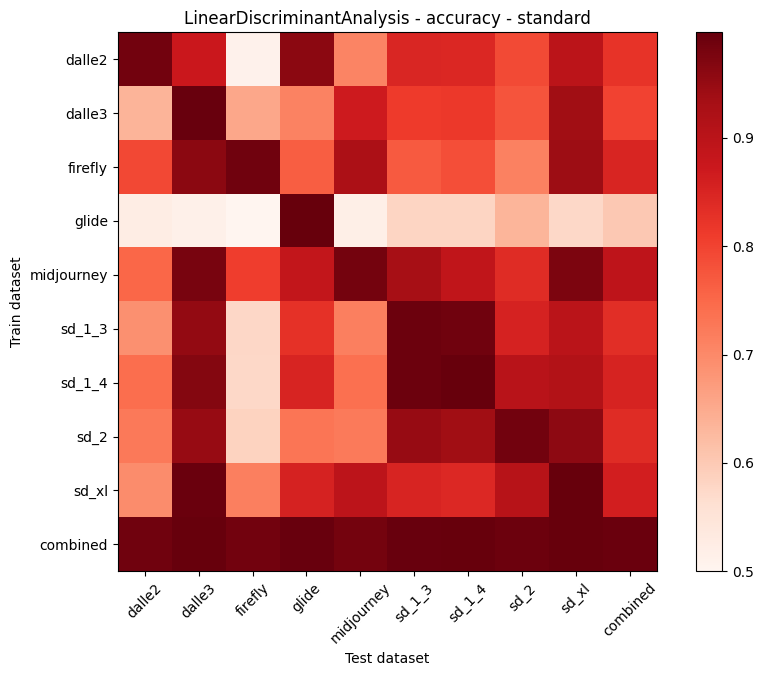

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9850  0.8750   0.5100  0.9600      0.7075  0.8475  0.8450   
dalle3         0.6350  0.9950   0.6550  0.7100      0.8675  0.8125  0.8150   
firefly        0.7925  0.9600   0.9875  0.7625      0.9225  0.7700  0.7850   
glide          0.5250  0.5150   0.5000  0.9975      0.5175  0.5800  0.5800   
midjourney     0.7525  0.9800   0.8075  0.8850      0.9825  0.9300  0.8900   
sd_1_3         0.6900  0.9525   0.5775  0.8275      0.7150  0.9900  0.9875   
sd_1_4         0.7425  0.9675   0.5750  0.8500      0.7375  0.9900  0.9975   
sd_2           0.7250  0.9475   0.5850  0.7300      0.7225  0.9475  0.9375   
sd_xl          0.6950  0.9925   0.7150  0.8550      0.8950  0.8500  0.8425   
combined       0.9875  0.9975   0.9850  0.9950      0.9825  0.9950  0.9975   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7900  0.8975  0.824167  
dalle3         0.7775  0.9375  0.800556  
firefly        0.7125  0.9425  0.848333  
glide          0.6325  0.5750  0.602500  
midjourney     0.8375  0.9750  0.893333  
sd_1_3         0.8550  0.9000  0.832778  
sd_1_4         0.9025  0.9125  0.852778  
sd_2           0.9850  0.9575  0.837500  
sd_xl          0.9050  0.9975  0.860833  
combined       0.9900  0.9975  0.991944

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9850  0.8750   0.5100  0.9600      0.7075  0.8475  0.8450   
dalle3         0.6350  0.9950   0.6550  0.7100      0.8675  0.8125  0.8150   
firefly        0.7925  0.9600   0.9875  0.7625      0.9225  0.7700  0.7850   
glide          0.5250  0.5150   0.5000  0.9975      0.5175  0.5800  0.5800   
midjourney     0.7525  0.9800   0.8075  0.8850      0.9825  0.9300  0.8900   
sd_1_3         0.6900  0.9525   0.5775  0.8275      0.7150  0.9900  0.9875   
sd_1_4         0.7425  0.9675   0.5750  0.8500      0.7375  0.9900  0.9975   
sd_2           0.7250  0.9475   0.5850  0.7300      0.7225  0.9475  0.9375   
sd_xl          0.6950  0.9925   0.7150  0.8550      0.8950  0.8500  0.8425   
combined       0.9875  0.9975   0.9850  0.9950      0.9825  0.9950  0.9975   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7900  0.8975  0.824167  
dalle3         0.7775  0.9375  0.800556  
firefly        0.7125  0.9425  0.848333  
glide          0.6325  0.5750  0.602500  
midjourney     0.8375  0.9750  0.893333  
sd_1_3         0.8550  0.9000  0.832778  
sd_1_4         0.9025  0.9125  0.852778  
sd_2           0.9850  0.9575  0.837500  
sd_xl          0.9050  0.9975  0.860833  
combined       0.9900  0.9975  0.991944

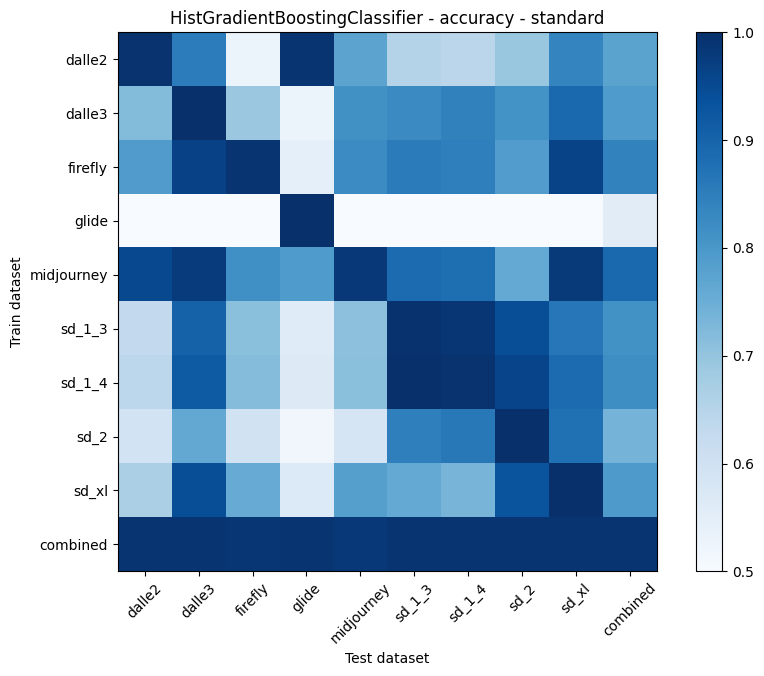

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8525   0.5300  0.9900      0.7725  0.6525  0.6425   
dalle3         0.7200  1.0000   0.6900  0.5300      0.8125  0.8250  0.8425   
firefly        0.7900  0.9650   0.9900  0.5450      0.8225  0.8550  0.8475   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9525  0.9775   0.8150  0.7925      0.9825  0.8850  0.8800   
sd_1_3         0.6300  0.9025   0.7100  0.5600      0.7075  0.9950  0.9875   
sd_1_4         0.6400  0.9175   0.7175  0.5625      0.7100  0.9975  0.9925   
sd_2           0.5925  0.7625   0.5975  0.5175      0.5825  0.8475  0.8600   
sd_xl          0.6675  0.9425   0.7550  0.5675      0.7825  0.7600  0.7350   
combined       0.9900  0.9900   0.9875  0.9900      0.9825  0.9900  0.9900   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6950  0.8375  0.773889  
dalle3         0.8100  0.8900  0.791111  
firefly        0.7875  0.9625  0.840556  
glide          0.5000  0.5000  0.555556  
midjourney     0.7600  0.9800  0.891667  
sd_1_3         0.9425  0.8625  0.810833  
sd_1_4         0.9600  0.8850  0.820278  
sd_2           0.9975  0.8750  0.736944  
sd_xl          0.9300  0.9975  0.793056  
combined       0.9900  0.9900  0.988889

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8525   0.5300  0.9900      0.7725  0.6525  0.6425   
dalle3         0.7200  1.0000   0.6900  0.5300      0.8125  0.8250  0.8425   
firefly        0.7900  0.9650   0.9900  0.5450      0.8225  0.8550  0.8475   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9525  0.9775   0.8150  0.7925      0.9825  0.8850  0.8800   
sd_1_3         0.6300  0.9025   0.7100  0.5600      0.7075  0.9950  0.9875   
sd_1_4         0.6400  0.9175   0.7175  0.5625      0.7100  0.9975  0.9925   
sd_2           0.5925  0.7625   0.5975  0.5175      0.5825  0.8475  0.8600   
sd_xl          0.6675  0.9425   0.7550  0.5675      0.7825  0.7600  0.7350   
combined       0.9900  0.9900   0.9875  0.9900      0.9825  0.9900  0.9900   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6950  0.8375  0.773889  
dalle3         0.8100  0.8900  0.791111  
firefly        0.7875  0.9625  0.840556  
glide          0.5000  0.5000  0.555556  
midjourney     0.7600  0.9800  0.891667  
sd_1_3         0.9425  0.8625  0.810833  
sd_1_4         0.9600  0.8850  0.820278  
sd_2           0.9975  0.8750  0.736944  
sd_xl          0.9300  0.9975  0.793056  
combined       0.9900  0.9900  0.988889

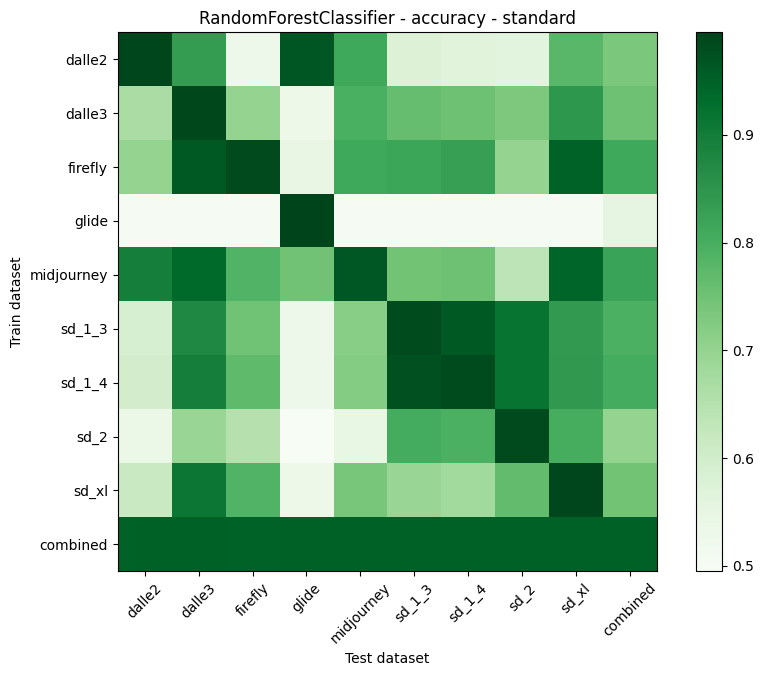

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.8350   0.5275  0.9675      0.8100  0.5750  0.5650   
dalle3         0.6675  0.9875   0.7000  0.5300      0.7975  0.7625  0.7525   
firefly        0.7000  0.9625   0.9850  0.5475      0.8100  0.8175  0.8300   
glide          0.5000  0.5000   0.5000  0.9950      0.5000  0.5000  0.5000   
midjourney     0.8950  0.9350   0.7875  0.7475      0.9650  0.7450  0.7525   
sd_1_3         0.5875  0.8750   0.7500  0.5275      0.7150  0.9825  0.9625   
sd_1_4         0.5950  0.8950   0.7700  0.5275      0.7225  0.9750  0.9825   
sd_2           0.5350  0.6925   0.6475  0.4950      0.5450  0.8025  0.7925   
sd_xl          0.6175  0.9100   0.7875  0.5300      0.7375  0.6925  0.6800   
combined       0.9500  0.9500   0.9475  0.9500      0.9500  0.9500  0.9500   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5600  0.7775  0.734167  
dalle3         0.7300  0.8450  0.752500  
firefly        0.7000  0.9475  0.811111  
glide          0.5000  0.5000  0.555000  
midjourney     0.6375  0.9425  0.823056  
sd_1_3         0.9150  0.8400  0.795000  
sd_1_4         0.9150  0.8425  0.802778  
sd_2           0.9850  0.8000  0.699444  
sd_xl          0.7650  0.9900  0.745556  
combined       0.9500  0.9500  0.949722

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.8350   0.5275  0.9675      0.8100  0.5750  0.5650   
dalle3         0.6675  0.9875   0.7000  0.5300      0.7975  0.7625  0.7525   
firefly        0.7000  0.9625   0.9850  0.5475      0.8100  0.8175  0.8300   
glide          0.5000  0.5000   0.5000  0.9950      0.5000  0.5000  0.5000   
midjourney     0.8950  0.9350   0.7875  0.7475      0.9650  0.7450  0.7525   
sd_1_3         0.5875  0.8750   0.7500  0.5275      0.7150  0.9825  0.9625   
sd_1_4         0.5950  0.8950   0.7700  0.5275      0.7225  0.9750  0.9825   
sd_2           0.5350  0.6925   0.6475  0.4950      0.5450  0.8025  0.7925   
sd_xl          0.6175  0.9100   0.7875  0.5300      0.7375  0.6925  0.6800   
combined       0.9500  0.9500   0.9475  0.9500      0.9500  0.9500  0.9500   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5600  0.7775  0.734167  
dalle3         0.7300  0.8450  0.752500  
firefly        0.7000  0.9475  0.811111  
glide          0.5000  0.5000  0.555000  
midjourney     0.6375  0.9425  0.823056  
sd_1_3         0.9150  0.8400  0.795000  
sd_1_4         0.9150  0.8425  0.802778  
sd_2           0.9850  0.8000  0.699444  
sd_xl          0.7650  0.9900  0.745556  
combined       0.9500  0.9500  0.949722

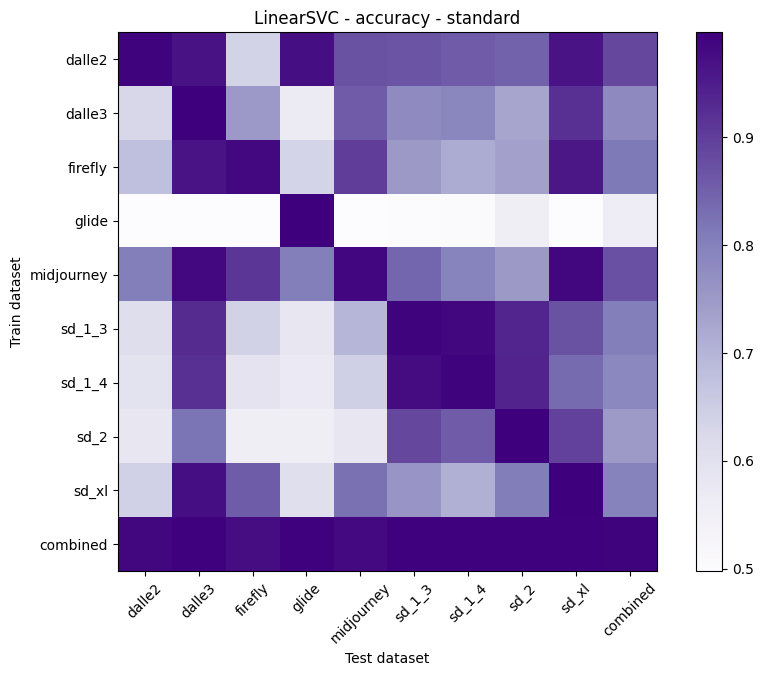

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.9675   0.6375  0.9725      0.8700  0.8675  0.8575   
dalle3         0.6275  0.9975   0.7500  0.5675      0.8575  0.7775  0.7875   
firefly        0.6775  0.9650   0.9825  0.6350      0.9000  0.7475  0.7175   
glide          0.4975  0.4975   0.4975  0.9975      0.4975  0.5000  0.5050   
midjourney     0.8050  0.9825   0.9100  0.8050      0.9850  0.8425  0.7925   
sd_1_3         0.6075  0.9275   0.6400  0.5825      0.6975  0.9900  0.9875   
sd_1_4         0.5950  0.9200   0.5925  0.5700      0.6450  0.9775  0.9900   
sd_2           0.5825  0.8200   0.5525  0.5525      0.5800  0.8850  0.8575   
sd_xl          0.6425  0.9725   0.8550  0.6050      0.8275  0.7575  0.7100   
combined       0.9875  0.9950   0.9750  0.9950      0.9800  0.9950  0.9950   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.8475  0.9650  0.886111  
dalle3         0.7275  0.9225  0.779444  
firefly        0.7375  0.9600  0.813611  
glide          0.5525  0.4975  0.560278  
midjourney     0.7475  0.9875  0.873056  
sd_1_3         0.9375  0.8700  0.804444  
sd_1_4         0.9400  0.8350  0.785000  
sd_2           0.9975  0.8950  0.746944  
sd_xl          0.8075  0.9975  0.797222  
combined       0.9950  0.9950  0.990278

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9900  0.9675   0.6375  0.9725      0.8700  0.8675  0.8575   
dalle3         0.6275  0.9975   0.7500  0.5675      0.8575  0.7775  0.7875   
firefly        0.6775  0.9650   0.9825  0.6350      0.9000  0.7475  0.7175   
glide          0.4975  0.4975   0.4975  0.9975      0.4975  0.5000  0.5050   
midjourney     0.8050  0.9825   0.9100  0.8050      0.9850  0.8425  0.7925   
sd_1_3         0.6075  0.9275   0.6400  0.5825      0.6975  0.9900  0.9875   
sd_1_4         0.5950  0.9200   0.5925  0.5700      0.6450  0.9775  0.9900   
sd_2           0.5825  0.8200   0.5525  0.5525      0.5800  0.8850  0.8575   
sd_xl          0.6425  0.9725   0.8550  0.6050      0.8275  0.7575  0.7100   
combined       0.9875  0.9950   0.9750  0.9950      0.9800  0.9950  0.9950   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.8475  0.9650  0.886111  
dalle3         0.7275  0.9225  0.779444  
firefly        0.7375  0.9600  0.813611  
glide          0.5525  0.4975  0.560278  
midjourney     0.7475  0.9875  0.873056  
sd_1_3         0.9375  0.8700  0.804444  
sd_1_4         0.9400  0.8350  0.785000  
sd_2           0.9975  0.8950  0.746944  
sd_xl          0.8075  0.9975  0.797222  
combined       0.9950  0.9950  0.990278









 ################ Evaluating models trained on standardAugmented and tested on sigma_1. ################


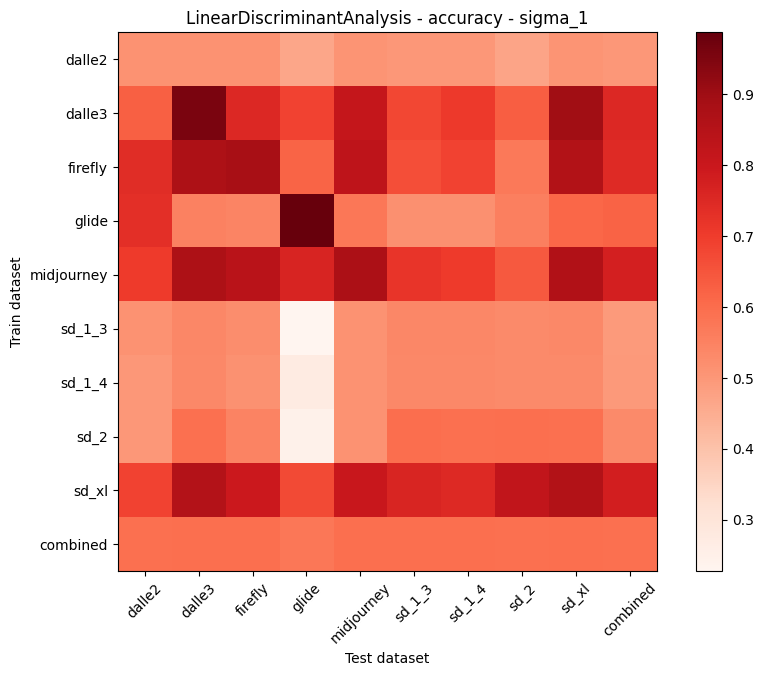

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5100  0.5100   0.5100  0.4650      0.5075  0.5000  0.5000   
dalle3         0.6275  0.9575   0.7525  0.6875      0.8150  0.6775  0.7075   
firefly        0.7400  0.8700   0.8825  0.6175      0.8300  0.6625  0.6850   
glide          0.7325  0.5525   0.5450  0.9875      0.5750  0.5175  0.5175   
midjourney     0.7025  0.8700   0.8400  0.7625      0.8725  0.7175  0.7025   
sd_1_3         0.5100  0.5375   0.5225  0.2275      0.5100  0.5375  0.5375   
sd_1_4         0.5000  0.5350   0.5150  0.2700      0.5100  0.5350  0.5350   
sd_2           0.5000  0.5925   0.5475  0.2475      0.5100  0.5975  0.5925   
sd_xl          0.6875  0.8550   0.7950  0.6700      0.8025  0.7600  0.7475   
combined       0.5900  0.5950   0.5950  0.5775      0.5950  0.5950  0.5950   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.4700  0.5075  0.497778  
dalle3         0.6300  0.8975  0.750278  
firefly        0.5700  0.8575  0.746111  
glide          0.5550  0.6125  0.621667  
midjourney     0.6425  0.8625  0.774722  
sd_1_3         0.5325  0.5350  0.494444  
sd_1_4         0.5325  0.5325  0.496111  
sd_2           0.5950  0.5925  0.530556  
sd_xl          0.8200  0.8575  0.777222  
combined       0.5925  0.5950  0.592222

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5100  0.5100   0.5100  0.4650      0.5075  0.5000  0.5000   
dalle3         0.6275  0.9575   0.7525  0.6875      0.8150  0.6775  0.7075   
firefly        0.7400  0.8700   0.8825  0.6175      0.8300  0.6625  0.6850   
glide          0.7325  0.5525   0.5450  0.9875      0.5750  0.5175  0.5175   
midjourney     0.7025  0.8700   0.8400  0.7625      0.8725  0.7175  0.7025   
sd_1_3         0.5100  0.5375   0.5225  0.2275      0.5100  0.5375  0.5375   
sd_1_4         0.5000  0.5350   0.5150  0.2700      0.5100  0.5350  0.5350   
sd_2           0.5000  0.5925   0.5475  0.2475      0.5100  0.5975  0.5925   
sd_xl          0.6875  0.8550   0.7950  0.6700      0.8025  0.7600  0.7475   
combined       0.5900  0.5950   0.5950  0.5775      0.5950  0.5950  0.5950   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.4700  0.5075  0.497778  
dalle3         0.6300  0.8975  0.750278  
firefly        0.5700  0.8575  0.746111  
glide          0.5550  0.6125  0.621667  
midjourney     0.6425  0.8625  0.774722  
sd_1_3         0.5325  0.5350  0.494444  
sd_1_4         0.5325  0.5325  0.496111  
sd_2           0.5950  0.5925  0.530556  
sd_xl          0.8200  0.8575  0.777222  
combined       0.5925  0.5950  0.592222

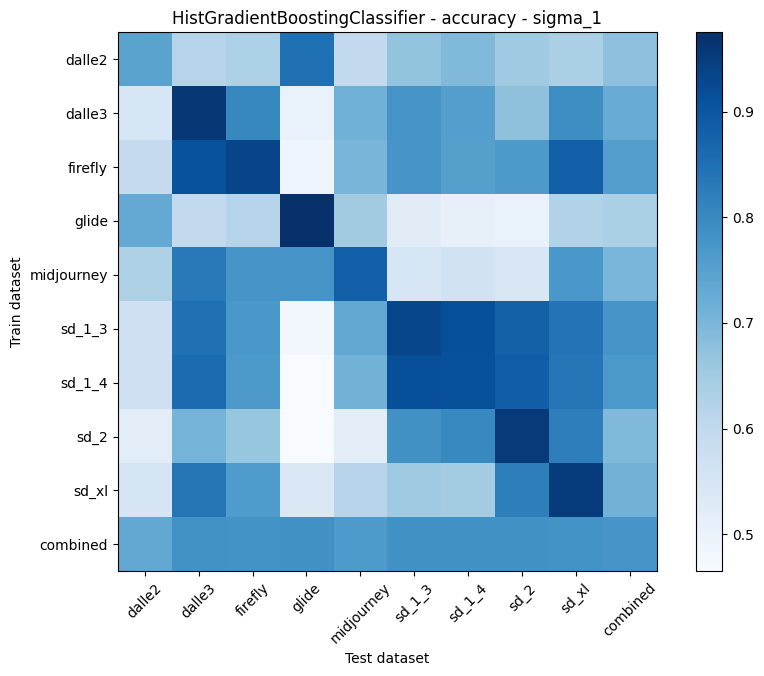

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.7450  0.6175   0.6325  0.8475      0.5975  0.6700  0.6925   
dalle3         0.5450  0.9600   0.8025  0.5000      0.7125  0.7775  0.7550   
firefly        0.5925  0.9075   0.9350  0.4875      0.7025  0.7750  0.7525   
glide          0.7300  0.5975   0.6175  0.9750      0.6500  0.5225  0.5050   
midjourney     0.6300  0.8300   0.7750  0.7775      0.8825  0.5475  0.5625   
sd_1_3         0.5725  0.8475   0.7700  0.4775      0.7325  0.9300  0.9150   
sd_1_4         0.5700  0.8575   0.7675  0.4650      0.7100  0.9150  0.9125   
sd_2           0.5175  0.7075   0.6650  0.4650      0.5175  0.7850  0.8000   
sd_xl          0.5525  0.8400   0.7625  0.5400      0.6150  0.6525  0.6475   
combined       0.7325  0.7825   0.7800  0.7850      0.7650  0.7850  0.7850   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6525  0.6350  0.676667  
dalle3         0.6750  0.7900  0.724167  
firefly        0.7675  0.8825  0.755833  
glide          0.5000  0.6225  0.635556  
midjourney     0.5425  0.7700  0.701944  
sd_1_3         0.8775  0.8425  0.773889  
sd_1_4         0.8850  0.8375  0.768889  
sd_2           0.9550  0.8200  0.692500  
sd_xl          0.8200  0.9525  0.709167  
combined       0.7850  0.7800  0.775556

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.7450  0.6175   0.6325  0.8475      0.5975  0.6700  0.6925   
dalle3         0.5450  0.9600   0.8025  0.5000      0.7125  0.7775  0.7550   
firefly        0.5925  0.9075   0.9350  0.4875      0.7025  0.7750  0.7525   
glide          0.7300  0.5975   0.6175  0.9750      0.6500  0.5225  0.5050   
midjourney     0.6300  0.8300   0.7750  0.7775      0.8825  0.5475  0.5625   
sd_1_3         0.5725  0.8475   0.7700  0.4775      0.7325  0.9300  0.9150   
sd_1_4         0.5700  0.8575   0.7675  0.4650      0.7100  0.9150  0.9125   
sd_2           0.5175  0.7075   0.6650  0.4650      0.5175  0.7850  0.8000   
sd_xl          0.5525  0.8400   0.7625  0.5400      0.6150  0.6525  0.6475   
combined       0.7325  0.7825   0.7800  0.7850      0.7650  0.7850  0.7850   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6525  0.6350  0.676667  
dalle3         0.6750  0.7900  0.724167  
firefly        0.7675  0.8825  0.755833  
glide          0.5000  0.6225  0.635556  
midjourney     0.5425  0.7700  0.701944  
sd_1_3         0.8775  0.8425  0.773889  
sd_1_4         0.8850  0.8375  0.768889  
sd_2           0.9550  0.8200  0.692500  
sd_xl          0.8200  0.9525  0.709167  
combined       0.7850  0.7800  0.775556

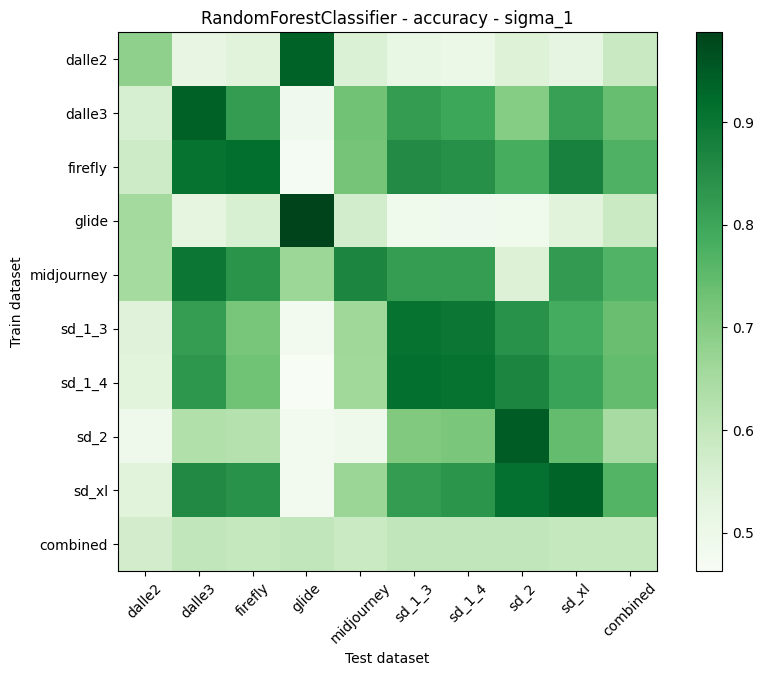

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.6850  0.5200   0.5350  0.9375      0.5500  0.5150  0.5050   
dalle3         0.5600  0.9400   0.8200  0.4875      0.7275  0.8200  0.8000   
firefly        0.5800  0.9075   0.9150  0.4725      0.7225  0.8575  0.8450   
glide          0.6525  0.5275   0.5550  0.9875      0.5700  0.4900  0.4875   
midjourney     0.6500  0.8975   0.8375  0.6650      0.8675  0.8175  0.8175   
sd_1_3         0.5400  0.8175   0.7175  0.4800      0.6625  0.9075  0.8975   
sd_1_4         0.5325  0.8300   0.7300  0.4625      0.6575  0.9125  0.9075   
sd_2           0.4950  0.6300   0.6250  0.4800      0.4950  0.7075  0.7150   
sd_xl          0.5350  0.8600   0.8400  0.4800      0.6675  0.8200  0.8350   
combined       0.5675  0.6025   0.5950  0.6025      0.5875  0.6025  0.6025   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5425  0.5225  0.590278  
dalle3         0.7000  0.8125  0.740833  
firefly        0.7825  0.8750  0.773056  
glide          0.4900  0.5350  0.588333  
midjourney     0.5475  0.8225  0.769167  
sd_1_3         0.8400  0.7875  0.738889  
sd_1_4         0.8675  0.8050  0.745000  
sd_2           0.9475  0.7450  0.648889  
sd_xl          0.9100  0.9350  0.764722  
combined       0.6025  0.5975  0.595556

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.6850  0.5200   0.5350  0.9375      0.5500  0.5150  0.5050   
dalle3         0.5600  0.9400   0.8200  0.4875      0.7275  0.8200  0.8000   
firefly        0.5800  0.9075   0.9150  0.4725      0.7225  0.8575  0.8450   
glide          0.6525  0.5275   0.5550  0.9875      0.5700  0.4900  0.4875   
midjourney     0.6500  0.8975   0.8375  0.6650      0.8675  0.8175  0.8175   
sd_1_3         0.5400  0.8175   0.7175  0.4800      0.6625  0.9075  0.8975   
sd_1_4         0.5325  0.8300   0.7300  0.4625      0.6575  0.9125  0.9075   
sd_2           0.4950  0.6300   0.6250  0.4800      0.4950  0.7075  0.7150   
sd_xl          0.5350  0.8600   0.8400  0.4800      0.6675  0.8200  0.8350   
combined       0.5675  0.6025   0.5950  0.6025      0.5875  0.6025  0.6025   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5425  0.5225  0.590278  
dalle3         0.7000  0.8125  0.740833  
firefly        0.7825  0.8750  0.773056  
glide          0.4900  0.5350  0.588333  
midjourney     0.5475  0.8225  0.769167  
sd_1_3         0.8400  0.7875  0.738889  
sd_1_4         0.8675  0.8050  0.745000  
sd_2           0.9475  0.7450  0.648889  
sd_xl          0.9100  0.9350  0.764722  
combined       0.6025  0.5975  0.595556

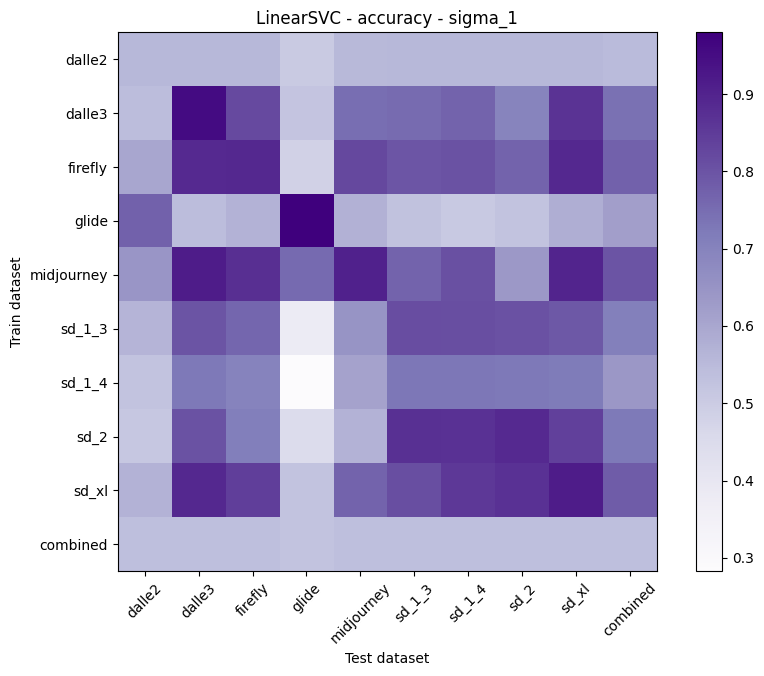

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5550  0.5550   0.5550  0.5050      0.5525  0.5550  0.5550   
dalle3         0.5425  0.9550   0.8200  0.5200      0.7475  0.7525  0.7675   
firefly        0.6000  0.8850   0.8875  0.4825      0.8225  0.7950  0.8025   
glide          0.7725  0.5425   0.5700  0.9800      0.5725  0.5300  0.5075   
midjourney     0.6425  0.9150   0.8750  0.7550      0.9050  0.7675  0.8075   
sd_1_3         0.5650  0.7975   0.7625  0.3800      0.6500  0.8125  0.8100   
sd_1_4         0.5275  0.7250   0.6975  0.2825      0.6100  0.7275  0.7275   
sd_2           0.5125  0.8025   0.7125  0.4475      0.5700  0.8725  0.8700   
sd_xl          0.5700  0.8900   0.8425  0.5250      0.7675  0.8100  0.8550   
combined       0.5375  0.5375   0.5375  0.5275      0.5375  0.5375  0.5375   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5550  0.5550  0.549167  
dalle3         0.6950  0.8675  0.740833  
firefly        0.7700  0.8875  0.770278  
glide          0.5250  0.5800  0.620000  
midjourney     0.6350  0.8975  0.800000  
sd_1_3         0.8050  0.7900  0.708056  
sd_1_4         0.7250  0.7200  0.638056  
sd_2           0.8850  0.8400  0.723611  
sd_xl          0.8700  0.9150  0.782778  
combined       0.5375  0.5375  0.536389

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5550  0.5550   0.5550  0.5050      0.5525  0.5550  0.5550   
dalle3         0.5425  0.9550   0.8200  0.5200      0.7475  0.7525  0.7675   
firefly        0.6000  0.8850   0.8875  0.4825      0.8225  0.7950  0.8025   
glide          0.7725  0.5425   0.5700  0.9800      0.5725  0.5300  0.5075   
midjourney     0.6425  0.9150   0.8750  0.7550      0.9050  0.7675  0.8075   
sd_1_3         0.5650  0.7975   0.7625  0.3800      0.6500  0.8125  0.8100   
sd_1_4         0.5275  0.7250   0.6975  0.2825      0.6100  0.7275  0.7275   
sd_2           0.5125  0.8025   0.7125  0.4475      0.5700  0.8725  0.8700   
sd_xl          0.5700  0.8900   0.8425  0.5250      0.7675  0.8100  0.8550   
combined       0.5375  0.5375   0.5375  0.5275      0.5375  0.5375  0.5375   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5550  0.5550  0.549167  
dalle3         0.6950  0.8675  0.740833  
firefly        0.7700  0.8875  0.770278  
glide          0.5250  0.5800  0.620000  
midjourney     0.6350  0.8975  0.800000  
sd_1_3         0.8050  0.7900  0.708056  
sd_1_4         0.7250  0.7200  0.638056  
sd_2           0.8850  0.8400  0.723611  
sd_xl          0.8700  0.9150  0.782778  
combined       0.5375  0.5375  0.536389









 ################ Evaluating models trained on standardAugmented and tested on sigma_2. ################


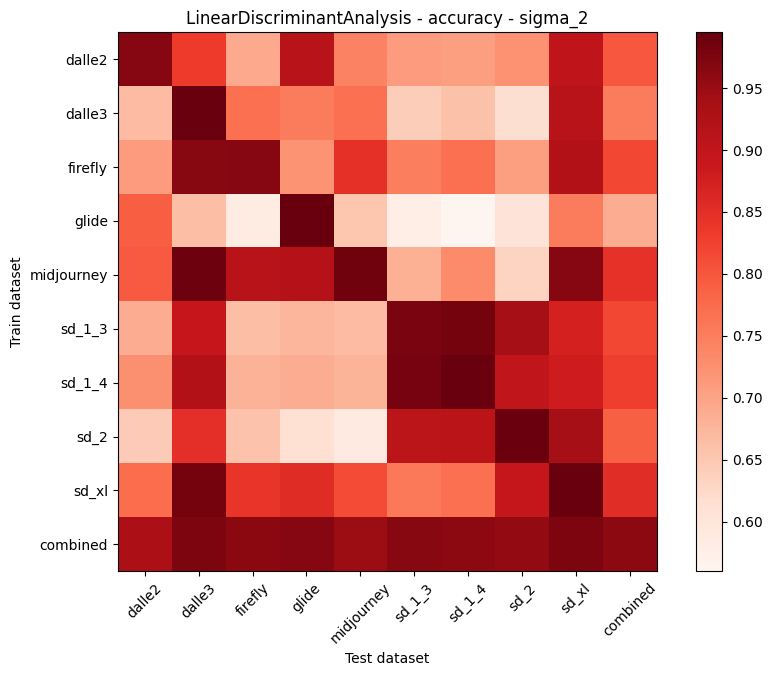

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9675  0.8325   0.6925  0.9150      0.7450  0.7100  0.7050   
dalle3         0.6675  0.9925   0.7675  0.7525      0.7675  0.6425  0.6600   
firefly        0.7100  0.9650   0.9675  0.7200      0.8475  0.7475  0.7675   
glide          0.7900  0.6625   0.5850  0.9950      0.6525  0.5775  0.5600   
midjourney     0.7950  0.9875   0.9150  0.9175      0.9850  0.6825  0.7325   
sd_1_3         0.6875  0.8925   0.6650  0.6750      0.6675  0.9775  0.9825   
sd_1_4         0.7250  0.9225   0.6800  0.6875      0.6775  0.9800  0.9925   
sd_2           0.6450  0.8500   0.6575  0.6125      0.5875  0.9075  0.9100   
sd_xl          0.7725  0.9825   0.8400  0.8550      0.8125  0.7575  0.7675   
combined       0.9300  0.9750   0.9625  0.9675      0.9475  0.9650  0.9600   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7225  0.9025  0.799167  
dalle3         0.6150  0.9125  0.753056  
firefly        0.7075  0.9225  0.817222  
glide          0.6025  0.7525  0.686389  
midjourney     0.6325  0.9675  0.846111  
sd_1_3         0.9375  0.8725  0.817500  
sd_1_4         0.9000  0.8800  0.827222  
sd_2           0.9900  0.9400  0.788889  
sd_xl          0.8950  0.9925  0.852778  
combined       0.9550  0.9750  0.959722

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9675  0.8325   0.6925  0.9150      0.7450  0.7100  0.7050   
dalle3         0.6675  0.9925   0.7675  0.7525      0.7675  0.6425  0.6600   
firefly        0.7100  0.9650   0.9675  0.7200      0.8475  0.7475  0.7675   
glide          0.7900  0.6625   0.5850  0.9950      0.6525  0.5775  0.5600   
midjourney     0.7950  0.9875   0.9150  0.9175      0.9850  0.6825  0.7325   
sd_1_3         0.6875  0.8925   0.6650  0.6750      0.6675  0.9775  0.9825   
sd_1_4         0.7250  0.9225   0.6800  0.6875      0.6775  0.9800  0.9925   
sd_2           0.6450  0.8500   0.6575  0.6125      0.5875  0.9075  0.9100   
sd_xl          0.7725  0.9825   0.8400  0.8550      0.8125  0.7575  0.7675   
combined       0.9300  0.9750   0.9625  0.9675      0.9475  0.9650  0.9600   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7225  0.9025  0.799167  
dalle3         0.6150  0.9125  0.753056  
firefly        0.7075  0.9225  0.817222  
glide          0.6025  0.7525  0.686389  
midjourney     0.6325  0.9675  0.846111  
sd_1_3         0.9375  0.8725  0.817500  
sd_1_4         0.9000  0.8800  0.827222  
sd_2           0.9900  0.9400  0.788889  
sd_xl          0.8950  0.9925  0.852778  
combined       0.9550  0.9750  0.959722

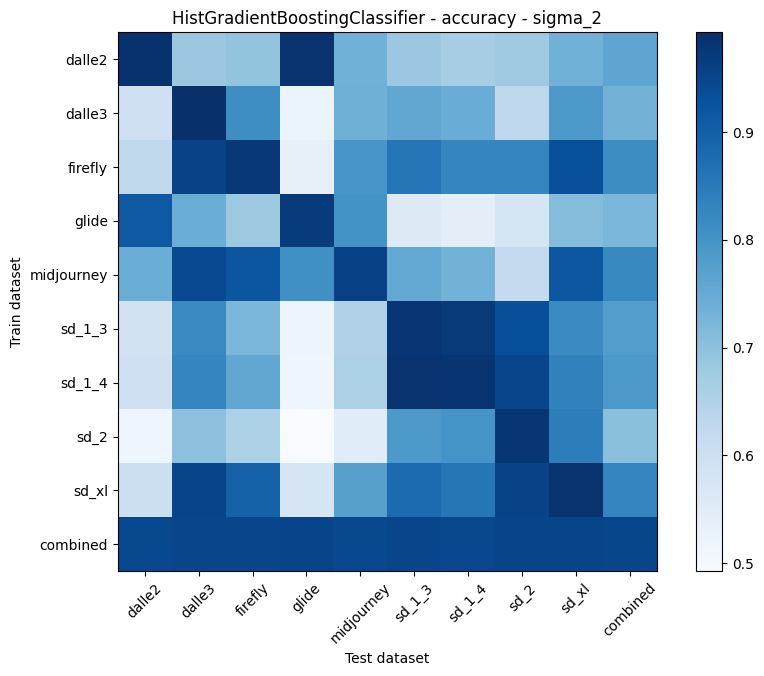

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.6825   0.6925  0.9850      0.7350  0.6825  0.6675   
dalle3         0.5975  0.9925   0.8125  0.5225      0.7375  0.7575  0.7450   
firefly        0.6250  0.9550   0.9750  0.5325      0.7950  0.8575  0.8275   
glide          0.9125  0.7425   0.6800  0.9700      0.8025  0.5575  0.5425   
midjourney     0.7425  0.9425   0.9200  0.8075      0.9575  0.7525  0.7325   
sd_1_3         0.5875  0.8200   0.7225  0.5175      0.6525  0.9800  0.9725   
sd_1_4         0.5975  0.8275   0.7575  0.5150      0.6575  0.9850  0.9825   
sd_2           0.5150  0.7000   0.6575  0.4925      0.5500  0.7900  0.8000   
sd_xl          0.6000  0.9525   0.8950  0.5775      0.7725  0.8775  0.8575   
combined       0.9450  0.9500   0.9500  0.9525      0.9450  0.9500  0.9475   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6775  0.7350  0.760556  
dalle3         0.6300  0.7875  0.731389  
firefly        0.8275  0.9300  0.813889  
glide          0.5750  0.7100  0.721389  
midjourney     0.6175  0.9175  0.821111  
sd_1_3         0.9325  0.8175  0.778056  
sd_1_4         0.9500  0.8350  0.789722  
sd_2           0.9800  0.8425  0.703056  
sd_xl          0.9550  0.9850  0.830278  
combined       0.9525  0.9525  0.949444

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.6825   0.6925  0.9850      0.7350  0.6825  0.6675   
dalle3         0.5975  0.9925   0.8125  0.5225      0.7375  0.7575  0.7450   
firefly        0.6250  0.9550   0.9750  0.5325      0.7950  0.8575  0.8275   
glide          0.9125  0.7425   0.6800  0.9700      0.8025  0.5575  0.5425   
midjourney     0.7425  0.9425   0.9200  0.8075      0.9575  0.7525  0.7325   
sd_1_3         0.5875  0.8200   0.7225  0.5175      0.6525  0.9800  0.9725   
sd_1_4         0.5975  0.8275   0.7575  0.5150      0.6575  0.9850  0.9825   
sd_2           0.5150  0.7000   0.6575  0.4925      0.5500  0.7900  0.8000   
sd_xl          0.6000  0.9525   0.8950  0.5775      0.7725  0.8775  0.8575   
combined       0.9450  0.9500   0.9500  0.9525      0.9450  0.9500  0.9475   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6775  0.7350  0.760556  
dalle3         0.6300  0.7875  0.731389  
firefly        0.8275  0.9300  0.813889  
glide          0.5750  0.7100  0.721389  
midjourney     0.6175  0.9175  0.821111  
sd_1_3         0.9325  0.8175  0.778056  
sd_1_4         0.9500  0.8350  0.789722  
sd_2           0.9800  0.8425  0.703056  
sd_xl          0.9550  0.9850  0.830278  
combined       0.9525  0.9525  0.949444

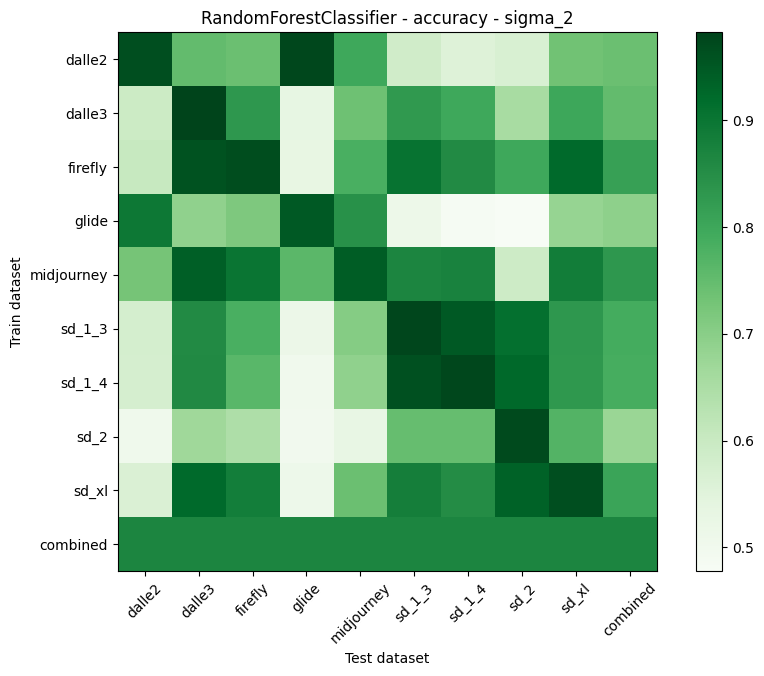

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9650  0.7500   0.7400  0.9750      0.7975  0.5850  0.5550   
dalle3         0.5925  0.9825   0.8325  0.5325      0.7375  0.8275  0.7975   
firefly        0.6025  0.9600   0.9675  0.5300      0.7825  0.9050  0.8575   
glide          0.8950  0.6900   0.7150  0.9475      0.8425  0.5125  0.4850   
midjourney     0.7275  0.9400   0.9000  0.7600      0.9425  0.8675  0.8725   
sd_1_3         0.5750  0.8575   0.7825  0.5150      0.7050  0.9775  0.9475   
sd_1_4         0.5725  0.8600   0.7625  0.5025      0.6900  0.9625  0.9750   
sd_2           0.5050  0.6675   0.6450  0.4975      0.5275  0.7475  0.7475   
sd_xl          0.5625  0.9225   0.8825  0.5100      0.7400  0.8800  0.8525   
combined       0.8675  0.8675   0.8675  0.8675      0.8675  0.8675  0.8675   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5675  0.7325  0.740833  
dalle3         0.6550  0.8000  0.750833  
firefly        0.7975  0.9225  0.813889  
glide          0.4775  0.6825  0.694167  
midjourney     0.5900  0.8850  0.831667  
sd_1_3         0.9100  0.8325  0.789167  
sd_1_4         0.9250  0.8300  0.786667  
sd_2           0.9725  0.7700  0.675556  
sd_xl          0.9350  0.9650  0.805556  
combined       0.8675  0.8675  0.867500

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9650  0.7500   0.7400  0.9750      0.7975  0.5850  0.5550   
dalle3         0.5925  0.9825   0.8325  0.5325      0.7375  0.8275  0.7975   
firefly        0.6025  0.9600   0.9675  0.5300      0.7825  0.9050  0.8575   
glide          0.8950  0.6900   0.7150  0.9475      0.8425  0.5125  0.4850   
midjourney     0.7275  0.9400   0.9000  0.7600      0.9425  0.8675  0.8725   
sd_1_3         0.5750  0.8575   0.7825  0.5150      0.7050  0.9775  0.9475   
sd_1_4         0.5725  0.8600   0.7625  0.5025      0.6900  0.9625  0.9750   
sd_2           0.5050  0.6675   0.6450  0.4975      0.5275  0.7475  0.7475   
sd_xl          0.5625  0.9225   0.8825  0.5100      0.7400  0.8800  0.8525   
combined       0.8675  0.8675   0.8675  0.8675      0.8675  0.8675  0.8675   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5675  0.7325  0.740833  
dalle3         0.6550  0.8000  0.750833  
firefly        0.7975  0.9225  0.813889  
glide          0.4775  0.6825  0.694167  
midjourney     0.5900  0.8850  0.831667  
sd_1_3         0.9100  0.8325  0.789167  
sd_1_4         0.9250  0.8300  0.786667  
sd_2           0.9725  0.7700  0.675556  
sd_xl          0.9350  0.9650  0.805556  
combined       0.8675  0.8675  0.867500

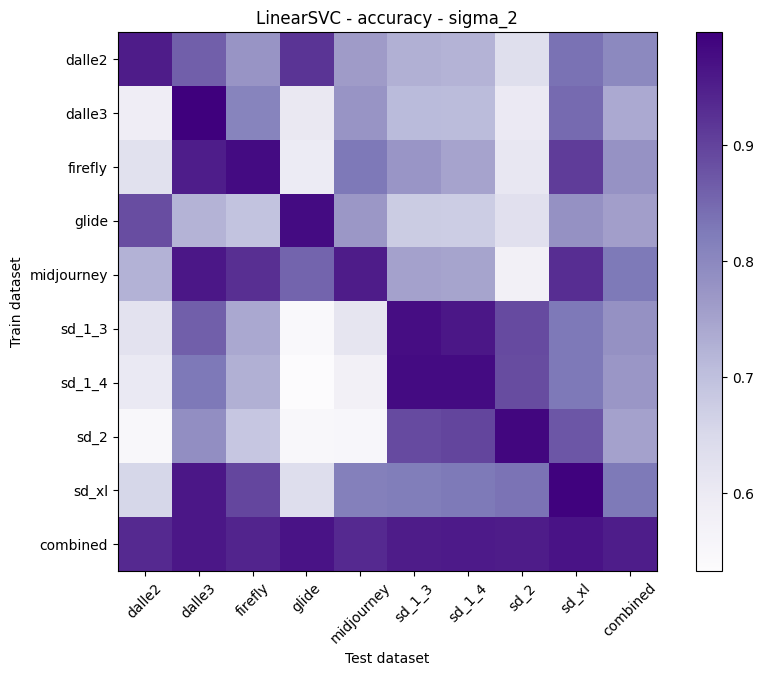

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9550  0.8625   0.7750  0.9200      0.7625  0.7275  0.7225   
dalle3         0.5900  0.9975   0.8075  0.6050      0.7750  0.7100  0.7075   
firefly        0.6275  0.9525   0.9800  0.5975      0.8275  0.7725  0.7500   
glide          0.8850  0.7225   0.6950  0.9800      0.7700  0.6775  0.6750   
midjourney     0.7250  0.9625   0.9275  0.8550      0.9550  0.7525  0.7475   
sd_1_3         0.6225  0.8625   0.7400  0.5450      0.6150  0.9775  0.9625   
sd_1_4         0.6025  0.8275   0.7275  0.5325      0.5775  0.9800  0.9800   
sd_2           0.5500  0.7875   0.6875  0.5475      0.5525  0.8900  0.8975   
sd_xl          0.6550  0.9625   0.8950  0.6375      0.8150  0.8200  0.8250   
combined       0.9350  0.9625   0.9425  0.9675      0.9350  0.9550  0.9575   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6325  0.8375  0.799444  
dalle3         0.6000  0.8475  0.737778  
firefly        0.6075  0.9100  0.780556  
glide          0.6300  0.7825  0.757500  
midjourney     0.5775  0.9300  0.825833  
sd_1_3         0.8900  0.8275  0.782500  
sd_1_4         0.8875  0.8275  0.771389  
sd_2           0.9875  0.8725  0.752500  
sd_xl          0.8350  0.9925  0.826389  
combined       0.9550  0.9675  0.953056

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9550  0.8625   0.7750  0.9200      0.7625  0.7275  0.7225   
dalle3         0.5900  0.9975   0.8075  0.6050      0.7750  0.7100  0.7075   
firefly        0.6275  0.9525   0.9800  0.5975      0.8275  0.7725  0.7500   
glide          0.8850  0.7225   0.6950  0.9800      0.7700  0.6775  0.6750   
midjourney     0.7250  0.9625   0.9275  0.8550      0.9550  0.7525  0.7475   
sd_1_3         0.6225  0.8625   0.7400  0.5450      0.6150  0.9775  0.9625   
sd_1_4         0.6025  0.8275   0.7275  0.5325      0.5775  0.9800  0.9800   
sd_2           0.5500  0.7875   0.6875  0.5475      0.5525  0.8900  0.8975   
sd_xl          0.6550  0.9625   0.8950  0.6375      0.8150  0.8200  0.8250   
combined       0.9350  0.9625   0.9425  0.9675      0.9350  0.9550  0.9575   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6325  0.8375  0.799444  
dalle3         0.6000  0.8475  0.737778  
firefly        0.6075  0.9100  0.780556  
glide          0.6300  0.7825  0.757500  
midjourney     0.5775  0.9300  0.825833  
sd_1_3         0.8900  0.8275  0.782500  
sd_1_4         0.8875  0.8275  0.771389  
sd_2           0.9875  0.8725  0.752500  
sd_xl          0.8350  0.9925  0.826389  
combined       0.9550  0.9675  0.953056









 ################ Evaluating models trained on standardAugmented and tested on sigma_3. ################


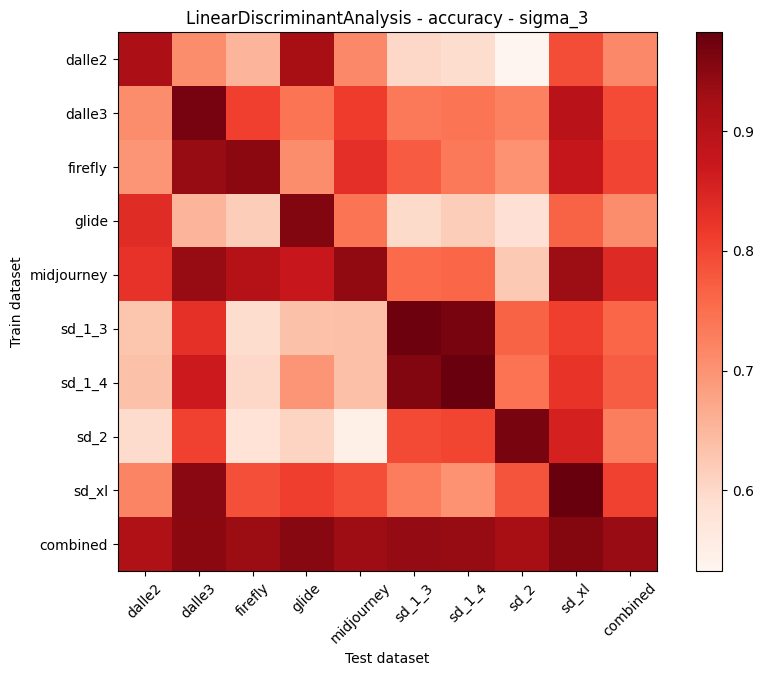

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9150  0.7075   0.6525  0.9225      0.7150  0.6000  0.5925   
dalle3         0.7075  0.9675   0.8075  0.7425      0.8125  0.7350  0.7425   
firefly        0.6975  0.9375   0.9475  0.7100      0.8325  0.7750  0.7375   
glide          0.8375  0.6525   0.6175  0.9575      0.7425  0.5975  0.6175   
midjourney     0.8275  0.9375   0.9000  0.8750      0.9425  0.7550  0.7600   
sd_1_3         0.6300  0.8300   0.5925  0.6350      0.6375  0.9750  0.9650   
sd_1_4         0.6350  0.8675   0.6000  0.6975      0.6375  0.9575  0.9800   
sd_2           0.5950  0.8050   0.5800  0.6075      0.5500  0.7950  0.8000   
sd_xl          0.7200  0.9500   0.7875  0.8100      0.7900  0.7300  0.7000   
combined       0.9100  0.9475   0.9350  0.9525      0.9300  0.9400  0.9375   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5325  0.7925  0.714444  
dalle3         0.7250  0.8950  0.792778  
firefly        0.7000  0.8800  0.801944  
glide          0.5850  0.7650  0.708056  
midjourney     0.6225  0.9325  0.839167  
sd_1_3         0.7650  0.8100  0.760000  
sd_1_4         0.7450  0.8250  0.771667  
sd_2           0.9650  0.8550  0.728056  
sd_xl          0.7825  0.9825  0.805833  
combined       0.9200  0.9550  0.936389

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9150  0.7075   0.6525  0.9225      0.7150  0.6000  0.5925   
dalle3         0.7075  0.9675   0.8075  0.7425      0.8125  0.7350  0.7425   
firefly        0.6975  0.9375   0.9475  0.7100      0.8325  0.7750  0.7375   
glide          0.8375  0.6525   0.6175  0.9575      0.7425  0.5975  0.6175   
midjourney     0.8275  0.9375   0.9000  0.8750      0.9425  0.7550  0.7600   
sd_1_3         0.6300  0.8300   0.5925  0.6350      0.6375  0.9750  0.9650   
sd_1_4         0.6350  0.8675   0.6000  0.6975      0.6375  0.9575  0.9800   
sd_2           0.5950  0.8050   0.5800  0.6075      0.5500  0.7950  0.8000   
sd_xl          0.7200  0.9500   0.7875  0.8100      0.7900  0.7300  0.7000   
combined       0.9100  0.9475   0.9350  0.9525      0.9300  0.9400  0.9375   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5325  0.7925  0.714444  
dalle3         0.7250  0.8950  0.792778  
firefly        0.7000  0.8800  0.801944  
glide          0.5850  0.7650  0.708056  
midjourney     0.6225  0.9325  0.839167  
sd_1_3         0.7650  0.8100  0.760000  
sd_1_4         0.7450  0.8250  0.771667  
sd_2           0.9650  0.8550  0.728056  
sd_xl          0.7825  0.9825  0.805833  
combined       0.9200  0.9550  0.936389

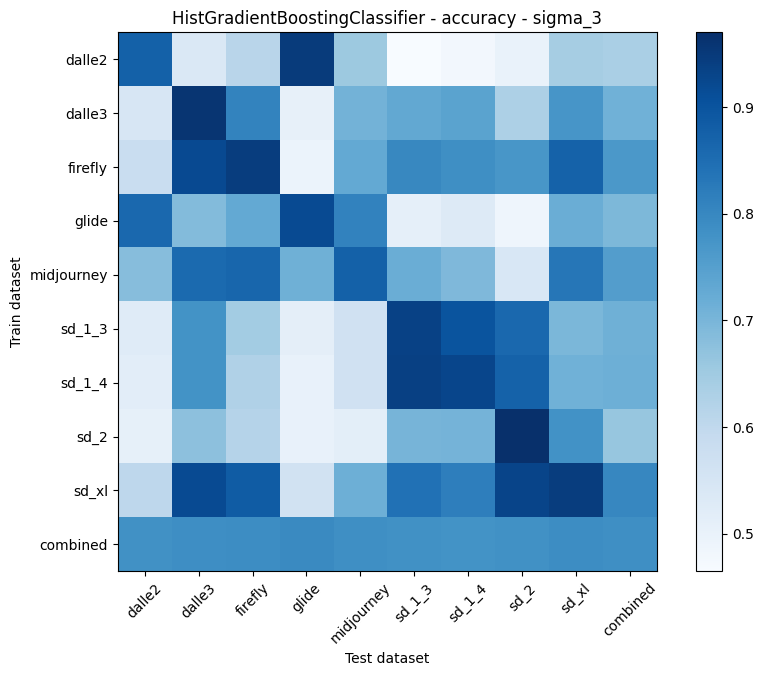

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8750  0.5375   0.6125  0.9475      0.6550  0.4650  0.4775   
dalle3         0.5450  0.9600   0.8075  0.5050      0.7075  0.7300  0.7425   
firefly        0.5825  0.9200   0.9425  0.4950      0.7275  0.8000  0.7850   
glide          0.8600  0.6875   0.7275  0.9175      0.8100  0.5100  0.5300   
midjourney     0.6825  0.8575   0.8650  0.7125      0.8750  0.7175  0.6925   
sd_1_3         0.5250  0.7775   0.6450  0.5125      0.5650  0.9350  0.9000   
sd_1_4         0.5175  0.7775   0.6250  0.5025      0.5650  0.9375  0.9275   
sd_2           0.5075  0.6750   0.6175  0.5025      0.5150  0.7025  0.7050   
sd_xl          0.6050  0.9175   0.8850  0.5600      0.7150  0.8425  0.8175   
combined       0.7825  0.7875   0.7900  0.7950      0.7850  0.7825  0.7775   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5000  0.6425  0.634722  
dalle3         0.6300  0.7725  0.711111  
firefly        0.7700  0.8725  0.766111  
glide          0.4875  0.7175  0.694167  
midjourney     0.5425  0.8325  0.753056  
sd_1_3         0.8600  0.6975  0.713056  
sd_1_4         0.8725  0.7100  0.715000  
sd_2           0.9700  0.7800  0.663889  
sd_xl          0.9300  0.9425  0.801667  
combined       0.7825  0.7900  0.785833

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8750  0.5375   0.6125  0.9475      0.6550  0.4650  0.4775   
dalle3         0.5450  0.9600   0.8075  0.5050      0.7075  0.7300  0.7425   
firefly        0.5825  0.9200   0.9425  0.4950      0.7275  0.8000  0.7850   
glide          0.8600  0.6875   0.7275  0.9175      0.8100  0.5100  0.5300   
midjourney     0.6825  0.8575   0.8650  0.7125      0.8750  0.7175  0.6925   
sd_1_3         0.5250  0.7775   0.6450  0.5125      0.5650  0.9350  0.9000   
sd_1_4         0.5175  0.7775   0.6250  0.5025      0.5650  0.9375  0.9275   
sd_2           0.5075  0.6750   0.6175  0.5025      0.5150  0.7025  0.7050   
sd_xl          0.6050  0.9175   0.8850  0.5600      0.7150  0.8425  0.8175   
combined       0.7825  0.7875   0.7900  0.7950      0.7850  0.7825  0.7775   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5000  0.6425  0.634722  
dalle3         0.6300  0.7725  0.711111  
firefly        0.7700  0.8725  0.766111  
glide          0.4875  0.7175  0.694167  
midjourney     0.5425  0.8325  0.753056  
sd_1_3         0.8600  0.6975  0.713056  
sd_1_4         0.8725  0.7100  0.715000  
sd_2           0.9700  0.7800  0.663889  
sd_xl          0.9300  0.9425  0.801667  
combined       0.7825  0.7900  0.785833

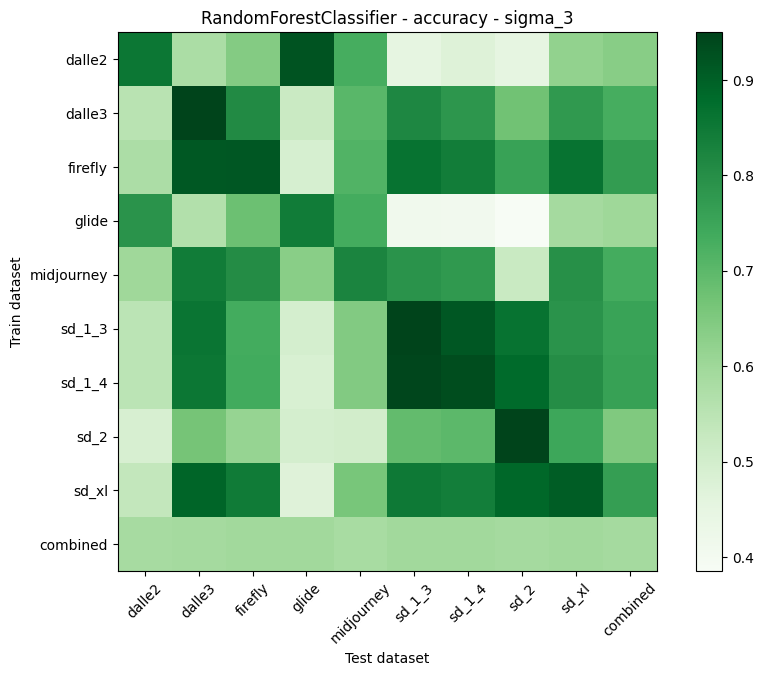

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8550  0.5775   0.6425  0.9225      0.7300  0.4525  0.4725   
dalle3         0.5525  0.9500   0.8100  0.5175      0.7050  0.8175  0.7825   
firefly        0.5750  0.9125   0.9150  0.4900      0.7150  0.8625  0.8400   
glide          0.7900  0.5650   0.6775  0.8425      0.7325  0.4100  0.4075   
midjourney     0.5975  0.8425   0.8050  0.6325      0.8225  0.7900  0.7775   
sd_1_3         0.5475  0.8575   0.7350  0.4950      0.6450  0.9500  0.9150   
sd_1_4         0.5475  0.8550   0.7375  0.4850      0.6450  0.9450  0.9325   
sd_2           0.4875  0.6650   0.6125  0.4950      0.5000  0.6900  0.7000   
sd_xl          0.5350  0.8925   0.8450  0.4700      0.6600  0.8500  0.8375   
combined       0.5850  0.5900   0.5925  0.5925      0.5825  0.5925  0.5925   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.4525  0.6200  0.636111  
dalle3         0.6700  0.7775  0.731389  
firefly        0.7575  0.8625  0.770000  
glide          0.3850  0.5900  0.600000  
midjourney     0.5200  0.7975  0.731667  
sd_1_3         0.8625  0.7900  0.755278  
sd_1_4         0.8800  0.8025  0.758889  
sd_2           0.9500  0.7450  0.649444  
sd_xl          0.8875  0.9050  0.764722  
combined       0.5900  0.5925  0.590000

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8550  0.5775   0.6425  0.9225      0.7300  0.4525  0.4725   
dalle3         0.5525  0.9500   0.8100  0.5175      0.7050  0.8175  0.7825   
firefly        0.5750  0.9125   0.9150  0.4900      0.7150  0.8625  0.8400   
glide          0.7900  0.5650   0.6775  0.8425      0.7325  0.4100  0.4075   
midjourney     0.5975  0.8425   0.8050  0.6325      0.8225  0.7900  0.7775   
sd_1_3         0.5475  0.8575   0.7350  0.4950      0.6450  0.9500  0.9150   
sd_1_4         0.5475  0.8550   0.7375  0.4850      0.6450  0.9450  0.9325   
sd_2           0.4875  0.6650   0.6125  0.4950      0.5000  0.6900  0.7000   
sd_xl          0.5350  0.8925   0.8450  0.4700      0.6600  0.8500  0.8375   
combined       0.5850  0.5900   0.5925  0.5925      0.5825  0.5925  0.5925   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.4525  0.6200  0.636111  
dalle3         0.6700  0.7775  0.731389  
firefly        0.7575  0.8625  0.770000  
glide          0.3850  0.5900  0.600000  
midjourney     0.5200  0.7975  0.731667  
sd_1_3         0.8625  0.7900  0.755278  
sd_1_4         0.8800  0.8025  0.758889  
sd_2           0.9500  0.7450  0.649444  
sd_xl          0.8875  0.9050  0.764722  
combined       0.5900  0.5925  0.590000

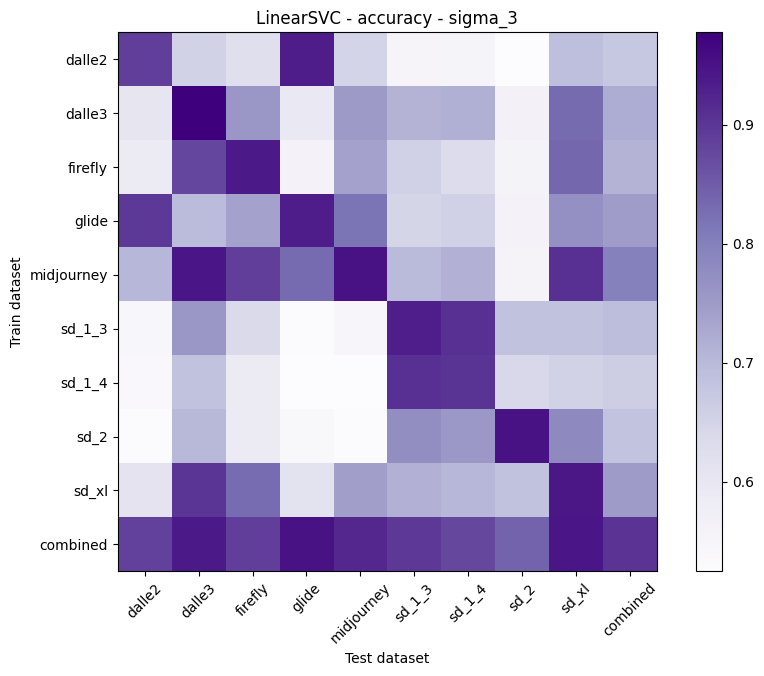

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8875  0.6525   0.6225  0.9350      0.6500  0.5500  0.5525   
dalle3         0.6050  0.9775   0.7575  0.5925      0.7500  0.7100  0.7175   
firefly        0.5900  0.8775   0.9400  0.5600      0.7400  0.6575  0.6325   
glide          0.8950  0.6950   0.7400  0.9350      0.8175  0.6475  0.6575   
midjourney     0.7025  0.9450   0.8875  0.8325      0.9500  0.6975  0.7125   
sd_1_3         0.5450  0.7575   0.6375  0.5300      0.5475  0.9325  0.9075   
sd_1_4         0.5375  0.6850   0.5900  0.5250      0.5250  0.9075  0.9025   
sd_2           0.5275  0.7000   0.5900  0.5425      0.5275  0.7725  0.7550   
sd_xl          0.6100  0.9000   0.8275  0.6150      0.7425  0.7125  0.7025   
combined       0.8850  0.9400   0.8875  0.9525      0.9200  0.8975  0.8750   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5250  0.6900  0.673889  
dalle3         0.5650  0.8300  0.722778  
firefly        0.5575  0.8350  0.710000  
glide          0.5600  0.7700  0.746389  
midjourney     0.5550  0.9075  0.798889  
sd_1_3         0.6850  0.6850  0.691944  
sd_1_4         0.6400  0.6525  0.662778  
sd_2           0.9500  0.7800  0.682778  
sd_xl          0.6850  0.9425  0.748611  
combined       0.8400  0.9450  0.904722

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8875  0.6525   0.6225  0.9350      0.6500  0.5500  0.5525   
dalle3         0.6050  0.9775   0.7575  0.5925      0.7500  0.7100  0.7175   
firefly        0.5900  0.8775   0.9400  0.5600      0.7400  0.6575  0.6325   
glide          0.8950  0.6950   0.7400  0.9350      0.8175  0.6475  0.6575   
midjourney     0.7025  0.9450   0.8875  0.8325      0.9500  0.6975  0.7125   
sd_1_3         0.5450  0.7575   0.6375  0.5300      0.5475  0.9325  0.9075   
sd_1_4         0.5375  0.6850   0.5900  0.5250      0.5250  0.9075  0.9025   
sd_2           0.5275  0.7000   0.5900  0.5425      0.5275  0.7725  0.7550   
sd_xl          0.6100  0.9000   0.8275  0.6150      0.7425  0.7125  0.7025   
combined       0.8850  0.9400   0.8875  0.9525      0.9200  0.8975  0.8750   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5250  0.6900  0.673889  
dalle3         0.5650  0.8300  0.722778  
firefly        0.5575  0.8350  0.710000  
glide          0.5600  0.7700  0.746389  
midjourney     0.5550  0.9075  0.798889  
sd_1_3         0.6850  0.6850  0.691944  
sd_1_4         0.6400  0.6525  0.662778  
sd_2           0.9500  0.7800  0.682778  
sd_xl          0.6850  0.9425  0.748611  
combined       0.8400  0.9450  0.904722

In [17]:
print("########################### Accuracy ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "accuracy"
    evaluation_data_name = "Test"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

### MCC - Test

########################### MCC ###########################








 ################ Evaluating models trained on standardAugmented and tested on standard. ################


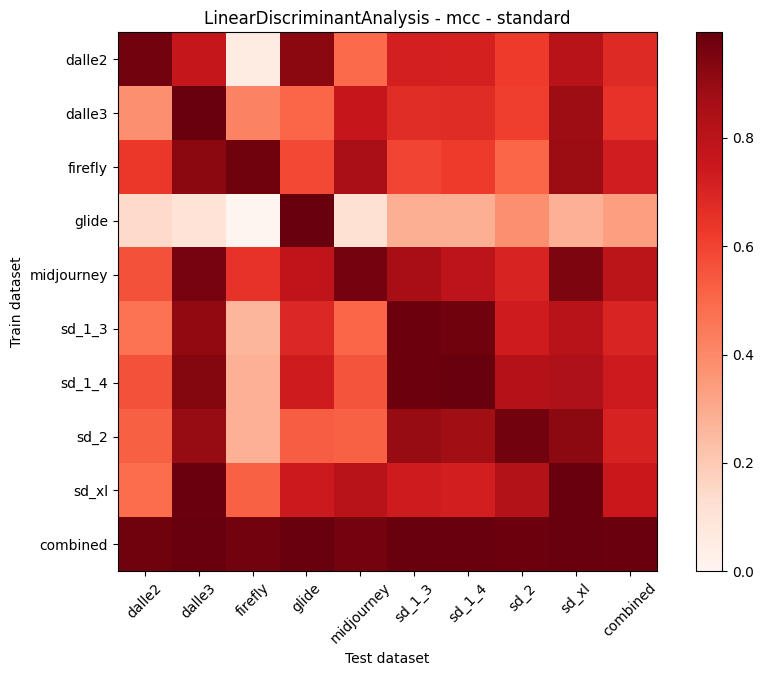

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.970194  0.765466  0.054413  0.920414    0.491210  0.718761   
dalle3         0.383413  0.990050  0.417587  0.506945    0.758105  0.668545   
firefly        0.633860  0.921152  0.975012  0.586245    0.851680  0.598120   
glide          0.146553  0.107143  0.000000  0.995012    0.118002  0.286860   
midjourney     0.560843  0.960192  0.650302  0.781374    0.965302  0.862765   
sd_1_3         0.466477  0.906372  0.261262  0.687771    0.507077  0.980196   
sd_1_4         0.561915  0.936417  0.276454  0.731432    0.554136  0.980049   
sd_2           0.523150  0.896897  0.277276  0.531162    0.519138  0.896897   
sd_xl          0.487500  0.985012  0.519015  0.739583    0.806290  0.731432   
combined       0.975110  0.995012  0.970194  0.990000    0.965302  0.990000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.714575  0.624306  0.804726  0.680013  
dalle3         0.672538  0.613129  0.879864  0.649539  
firefly        0.621921  0.506896  0.888214  0.724246  
glide          0.286860  0.384756  0.276454  0.330914  
midjourney     0.790180  0.700027  0.950048  0.796081  
sd_1_3         0.975110  0.733285  0.810441  0.696429  
sd_1_4         0.995012  0.819140  0.836465  0.735956  
sd_2           0.878178  0.970049  0.915928  0.704205  
sd_xl          0.719272  0.823450  0.995012  0.749141  
combined       0.995012  0.980049  0.995012  0.983907

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.970194  0.765466  0.054413  0.920414    0.491210  0.718761   
dalle3         0.383413  0.990050  0.417587  0.506945    0.758105  0.668545   
firefly        0.633860  0.921152  0.975012  0.586245    0.851680  0.598120   
glide          0.146553  0.107143  0.000000  0.995012    0.118002  0.286860   
midjourney     0.560843  0.960192  0.650302  0.781374    0.965302  0.862765   
sd_1_3         0.466477  0.906372  0.261262  0.687771    0.507077  0.980196   
sd_1_4         0.561915  0.936417  0.276454  0.731432    0.554136  0.980049   
sd_2           0.523150  0.896897  0.277276  0.531162    0.519138  0.896897   
sd_xl          0.487500  0.985012  0.519015  0.739583    0.806290  0.731432   
combined       0.975110  0.995012  0.970194  0.990000    0.965302  0.990000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.714575  0.624306  0.804726  0.673785  
dalle3         0.672538  0.613129  0.879864  0.654464  
firefly        0.621921  0.506896  0.888214  0.731456  
glide          0.286860  0.384756  0.276454  0.289071  
midjourney     0.790180  0.700027  0.950048  0.802337  
sd_1_3         0.975110  0.733285  0.810441  0.703110  
sd_1_4         0.995012  0.819140  0.836465  0.743447  
sd_2           0.878178  0.970049  0.915928  0.712075  
sd_xl          0.719272  0.823450  0.995012  0.756285  
combined       0.995012  0.980049  0.995012  0.983966

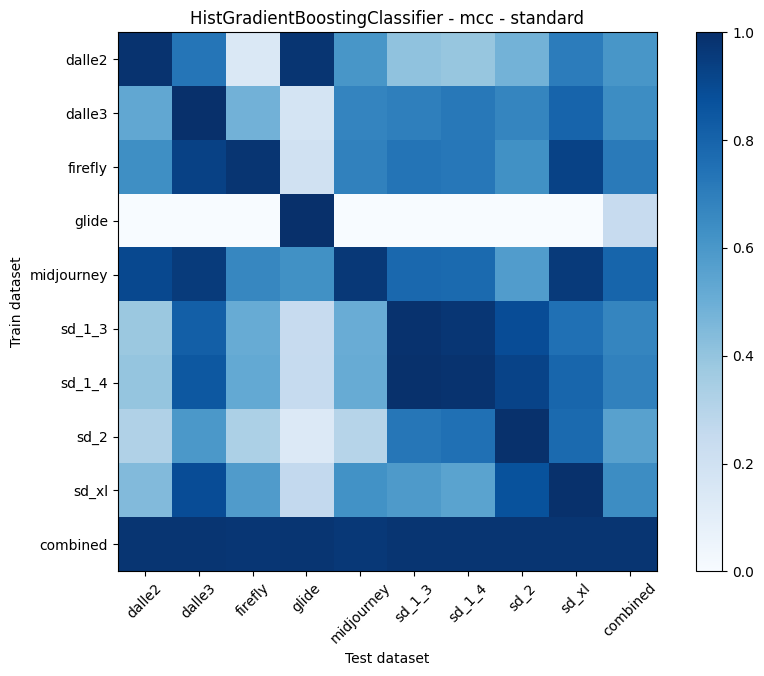

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985111  0.731139  0.144715  0.980049    0.602081  0.408386   
dalle3         0.531085  1.000000  0.484322  0.175863    0.674200  0.693889   
firefly        0.632832  0.931165  0.980000  0.197386    0.684555  0.737386   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.905918  0.955012  0.664966  0.628352    0.965109  0.782786   
sd_1_3         0.380424  0.819140  0.511170  0.243382    0.507240  0.990000   
sd_1_4         0.397613  0.845215  0.522931  0.249117    0.511170  0.995012   
sd_2           0.319262  0.596601  0.328684  0.133460    0.299864  0.729772   
sd_xl          0.443339  0.889919  0.581350  0.260302    0.624176  0.589124   
combined       0.980196  0.980196  0.975110  0.980196    0.965012  0.980196   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.391192  0.478753  0.706438  0.604283  
dalle3         0.721743  0.670280  0.799590  0.640826  
firefly        0.725070  0.628885  0.926402  0.713738  
glide          0.000000  0.000000  0.000000  0.242536  
midjourney     0.774101  0.575967  0.960048  0.794445  
sd_1_3         0.975110  0.889919  0.751881  0.668679  
sd_1_4         0.985012  0.922262  0.789339  0.683655  
sd_2           0.750000  0.995012  0.774597  0.557244  
sd_xl          0.550244  0.867360  0.995012  0.640693  
combined       0.980196  0.980196  0.980196  0.977932

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985111  0.731139  0.144715  0.980049    0.602081  0.408386   
dalle3         0.531085  1.000000  0.484322  0.175863    0.674200  0.693889   
firefly        0.632832  0.931165  0.980000  0.197386    0.684555  0.737386   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.905918  0.955012  0.664966  0.628352    0.965109  0.782786   
sd_1_3         0.380424  0.819140  0.511170  0.243382    0.507240  0.990000   
sd_1_4         0.397613  0.845215  0.522931  0.249117    0.511170  0.995012   
sd_2           0.319262  0.596601  0.328684  0.133460    0.299864  0.729772   
sd_xl          0.443339  0.889919  0.581350  0.260302    0.624176  0.589124   
combined       0.980196  0.980196  0.975110  0.980196    0.965012  0.980196   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.391192  0.478753  0.706438  0.603096  
dalle3         0.721743  0.670280  0.799590  0.638997  
firefly        0.725070  0.628885  0.926402  0.715965  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.774101  0.575967  0.960048  0.801362  
sd_1_3         0.975110  0.889919  0.751881  0.674252  
sd_1_4         0.985012  0.922262  0.789339  0.690852  
sd_2           0.750000  0.995012  0.774597  0.547472  
sd_xl          0.550244  0.867360  0.995012  0.644536  
combined       0.980196  0.980196  0.980196  0.977944

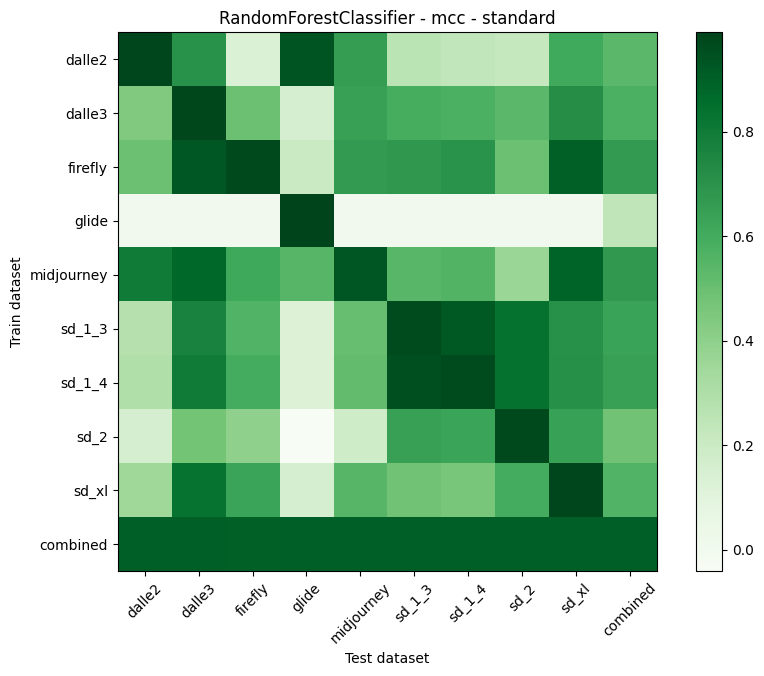

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980196  0.700085  0.129287  0.935292    0.659276  0.255785   
dalle3         0.438377  0.975012  0.491029  0.153093    0.644695  0.589562   
firefly        0.491029  0.926402  0.970049  0.204042    0.664557  0.676538   
glide          0.000000  0.000000  0.000000  0.990050    0.000000  0.000000   
midjourney     0.797858  0.871570  0.615061  0.549737    0.930000  0.545658   
sd_1_3         0.276916  0.765466  0.559893  0.123300    0.503415  0.965109   
sd_1_4         0.292342  0.800310  0.592050  0.123300    0.515572  0.950000   
sd_2           0.153522  0.470572  0.394996 -0.041135    0.182537  0.647151   
sd_xl          0.352290  0.830702  0.628885  0.153093    0.550329  0.479019   
combined       0.904534  0.904534  0.899066  0.904534    0.904534  0.904534   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.233074  0.221163  0.607011  0.537830  
dalle3         0.573873  0.538537  0.720983  0.573873  
firefly        0.696631  0.491029  0.898251  0.666329  
glide          0.000000  0.000000  0.000000  0.241249  
midjourney     0.557892  0.363935  0.885897  0.673835  
sd_1_3         0.925289  0.836041  0.706229  0.632401  
sd_1_4         0.965109  0.836041  0.710398  0.645027  
sd_2           0.631051  0.970049  0.643120  0.481901  
sd_xl          0.458831  0.593486  0.980000  0.562977  
combined       0.904534  0.904534  0.904534  0.903925

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980196  0.700085  0.129287  0.935292    0.659276  0.255785   
dalle3         0.438377  0.975012  0.491029  0.153093    0.644695  0.589562   
firefly        0.491029  0.926402  0.970049  0.204042    0.664557  0.676538   
glide          0.000000  0.000000  0.000000  0.990050    0.000000  0.000000   
midjourney     0.797858  0.871570  0.615061  0.549737    0.930000  0.545658   
sd_1_3         0.276916  0.765466  0.559893  0.123300    0.503415  0.965109   
sd_1_4         0.292342  0.800310  0.592050  0.123300    0.515572  0.950000   
sd_2           0.153522  0.470572  0.394996 -0.041135    0.182537  0.647151   
sd_xl          0.352290  0.830702  0.628885  0.153093    0.550329  0.479019   
combined       0.904534  0.904534  0.899066  0.904534    0.904534  0.904534   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.233074  0.221163  0.607011  0.524574  
dalle3         0.573873  0.538537  0.720983  0.569462  
firefly        0.696631  0.491029  0.898251  0.668725  
glide          0.000000  0.000000  0.000000  0.110006  
midjourney     0.557892  0.363935  0.885897  0.679734  
sd_1_3         0.925289  0.836041  0.706229  0.629073  
sd_1_4         0.965109  0.836041  0.710398  0.642791  
sd_2           0.631051  0.970049  0.643120  0.450207  
sd_xl          0.458831  0.593486  0.980000  0.558515  
combined       0.904534  0.904534  0.904534  0.903927

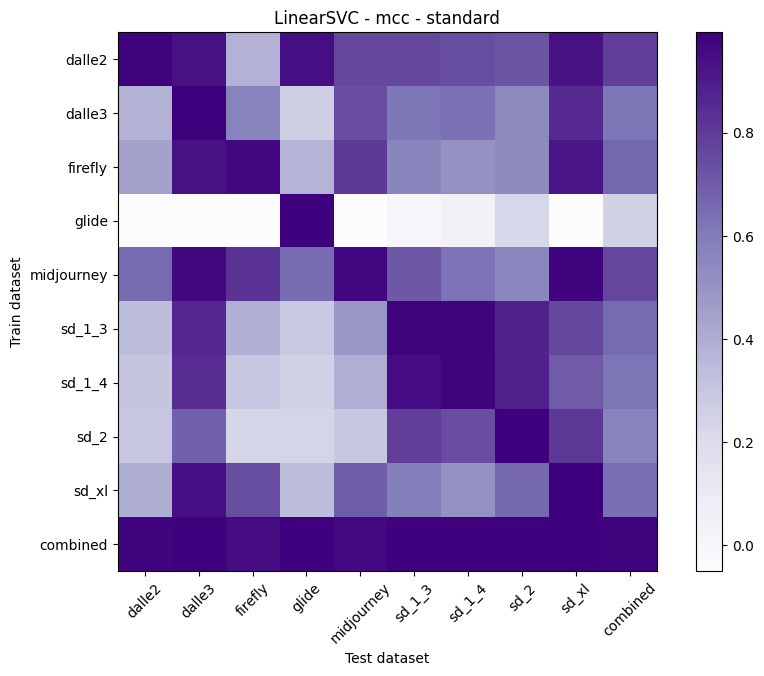

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980049  0.935573  0.382470  0.945295    0.760385  0.756176   
dalle3         0.376069  0.995012  0.573577  0.260302    0.743673  0.616372   
firefly        0.445854  0.930419  0.965012  0.373026    0.810441  0.559126   
glide         -0.050063 -0.050063 -0.050063  0.995012   -0.050063  0.000000   
midjourney     0.648643  0.965109  0.827018  0.648643    0.970194  0.710398   
sd_1_3         0.333835  0.861759  0.392078  0.284747    0.487033  0.980000   
sd_1_4         0.303621  0.847189  0.298630  0.251002    0.395520  0.955107   
sd_2           0.299864  0.685994  0.235391  0.235391    0.294884  0.791212   
sd_xl          0.401857  0.945958  0.739583  0.335581    0.695168  0.585237   
combined       0.975012  0.990050  0.950428  0.990050    0.960192  0.990050   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.739445  0.722871  0.930745  0.787783  
dalle3         0.631992  0.538556  0.854026  0.619406  
firefly        0.511102  0.543159  0.920737  0.665131  
glide          0.050252  0.225520 -0.050063  0.244024  
midjourney     0.628352  0.555873  0.975305  0.762120  
sd_1_3         0.975012  0.879864  0.762279  0.655714  
sd_1_4         0.980049  0.883586  0.702351  0.621921  
sd_2           0.745936  0.995012  0.808018  0.572646  
sd_xl          0.511170  0.663413  0.995012  0.647231  
combined       0.990050  0.990050  0.990050  0.980556

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.980049  0.935573  0.382470  0.945295    0.760385  0.756176   
dalle3         0.376069  0.995012  0.573577  0.260302    0.743673  0.616372   
firefly        0.445854  0.930419  0.965012  0.373026    0.810441  0.559126   
glide         -0.050063 -0.050063 -0.050063  0.995012   -0.050063  0.000000   
midjourney     0.648643  0.965109  0.827018  0.648643    0.970194  0.710398   
sd_1_3         0.333835  0.861759  0.392078  0.284747    0.487033  0.980000   
sd_1_4         0.303621  0.847189  0.298630  0.251002    0.395520  0.955107   
sd_2           0.299864  0.685994  0.235391  0.235391    0.294884  0.791212   
sd_xl          0.401857  0.945958  0.739583  0.335581    0.695168  0.585237   
combined       0.975012  0.990050  0.950428  0.990050    0.960192  0.990050   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.739445  0.722871  0.930745  0.794779  
dalle3         0.631992  0.538556  0.854026  0.621064  
firefly        0.511102  0.543159  0.920737  0.673208  
glide          0.050252  0.225520 -0.050063  0.113386  
midjourney     0.628352  0.555873  0.975305  0.769948  
sd_1_3         0.975012  0.879864  0.762279  0.661845  
sd_1_4         0.980049  0.883586  0.702351  0.624117  
sd_2           0.745936  0.995012  0.808018  0.565745  
sd_xl          0.511170  0.663413  0.995012  0.652553  
combined       0.990050  0.990050  0.990050  0.980659









 ################ Evaluating models trained on standardAugmented and tested on sigma_1. ################


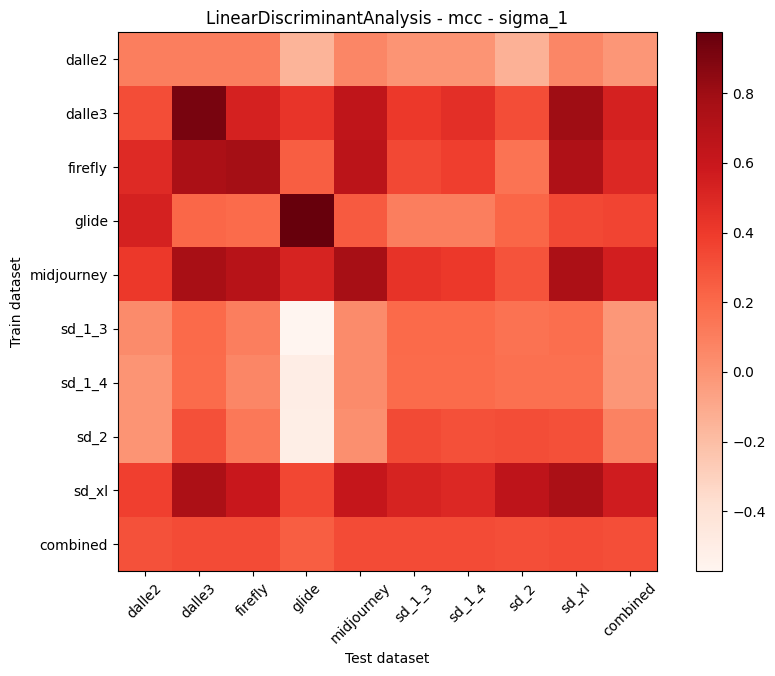

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.100504  0.100504  0.100504 -0.153522    0.067505  0.000000   
dalle3         0.317272  0.916939  0.538034  0.426143    0.645823  0.408566   
firefly        0.481956  0.750930  0.779973  0.249411    0.662689  0.335216   
glide          0.538744  0.209258  0.189484  0.975012    0.262071  0.098689   
midjourney     0.407251  0.760385  0.690044  0.525059    0.766465  0.436229   
sd_1_3         0.040564  0.197386  0.100882 -0.572267    0.040564  0.197386   
sd_1_4         0.000000  0.190445  0.065795 -0.501901    0.042108  0.190445   
sd_2           0.000000  0.304974  0.133952 -0.507807    0.025753  0.328684   
sd_xl          0.375568  0.739583  0.597700  0.341385    0.614482  0.522119   
combined       0.300000  0.323994  0.323994  0.245268    0.323994  0.323994   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.000000 -0.137649  0.067505 -0.015076  
dalle3         0.460891  0.322020  0.796205  0.534235  
firefly        0.377630  0.155068  0.722637  0.493718  
glide          0.098689  0.215562  0.337299  0.354202  
midjourney     0.407251  0.292500  0.742361  0.549872  
sd_1_3         0.197386  0.161109  0.178609 -0.020413  
sd_1_4         0.190445  0.171067  0.171067 -0.014866  
sd_2           0.304974  0.316667  0.304974  0.082431  
sd_xl          0.496049  0.654597  0.745936  0.558788  
combined       0.323994  0.311829  0.323994  0.310498

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.100504  0.100504  0.100504 -0.153522    0.067505  0.000000   
dalle3         0.317272  0.916939  0.538034  0.426143    0.645823  0.408566   
firefly        0.481956  0.750930  0.779973  0.249411    0.662689  0.335216   
glide          0.538744  0.209258  0.189484  0.975012    0.262071  0.098689   
midjourney     0.407251  0.760385  0.690044  0.525059    0.766465  0.436229   
sd_1_3         0.040564  0.197386  0.100882 -0.572267    0.040564  0.197386   
sd_1_4         0.000000  0.190445  0.065795 -0.501901    0.042108  0.190445   
sd_2           0.000000  0.304974  0.133952 -0.507807    0.025753  0.328684   
sd_xl          0.375568  0.739583  0.597700  0.341385    0.614482  0.522119   
combined       0.300000  0.323994  0.323994  0.245268    0.323994  0.323994   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.000000 -0.137649  0.067505  0.016150  
dalle3         0.460891  0.322020  0.796205  0.536877  
firefly        0.377630  0.155068  0.722637  0.501723  
glide          0.098689  0.215562  0.337299  0.324979  
midjourney     0.407251  0.292500  0.742361  0.558616  
sd_1_3         0.197386  0.161109  0.178609  0.060180  
sd_1_4         0.190445  0.171067  0.171067  0.057719  
sd_2           0.304974  0.316667  0.304974  0.134686  
sd_xl          0.496049  0.654597  0.745936  0.565269  
combined       0.323994  0.311829  0.323994  0.311229

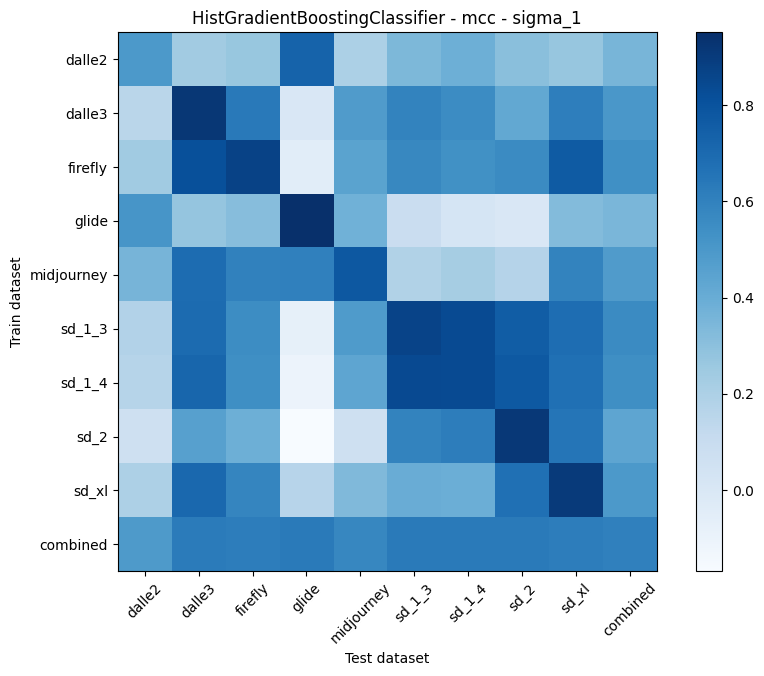

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.492469  0.237875  0.267095  0.729772    0.198817  0.340426   
dalle3         0.153471  0.920184  0.633178  0.000000    0.482962  0.591305   
firefly        0.242089  0.815092  0.870697 -0.048204    0.447418  0.572917   
glide          0.512251  0.274955  0.314658  0.951190    0.375000  0.086767   
midjourney     0.359211  0.689636  0.600099  0.604127    0.778437  0.183176   
sd_1_3         0.180410  0.695705  0.551135 -0.072640    0.483647  0.866260   
sd_1_4         0.165095  0.715725  0.539943 -0.104073    0.433774  0.840832   
sd_2           0.058995  0.458466  0.383643 -0.168834    0.058995  0.591986   
sd_xl          0.196347  0.706229  0.579987  0.162255    0.331424  0.399119   
combined       0.491692  0.624176  0.617063  0.631349    0.575577  0.631349   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.385005  0.306108  0.271965  0.353571  
dalle3         0.553857  0.419079  0.612190  0.502511  
firefly        0.533988  0.559918  0.766621  0.539745  
glide          0.021932  0.000000  0.324233  0.348698  
midjourney     0.221187  0.169400  0.592050  0.482133  
sd_1_3         0.833382  0.755085  0.686038  0.558187  
sd_1_4         0.835093  0.773879  0.675008  0.542541  
sd_2           0.618064  0.912238  0.653197  0.432346  
sd_xl          0.390403  0.673162  0.905918  0.493927  
combined       0.631349  0.631349  0.617063  0.604563

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.492469  0.237875  0.267095  0.729772    0.198817  0.340426   
dalle3         0.153471  0.920184  0.633178  0.000000    0.482962  0.591305   
firefly        0.242089  0.815092  0.870697 -0.048204    0.447418  0.572917   
glide          0.512251  0.274955  0.314658  0.951190    0.375000  0.086767   
midjourney     0.359211  0.689636  0.600099  0.604127    0.778437  0.183176   
sd_1_3         0.180410  0.695705  0.551135 -0.072640    0.483647  0.866260   
sd_1_4         0.165095  0.715725  0.539943 -0.104073    0.433774  0.840832   
sd_2           0.058995  0.458466  0.383643 -0.168834    0.058995  0.591986   
sd_xl          0.196347  0.706229  0.579987  0.162255    0.331424  0.399119   
combined       0.491692  0.624176  0.617063  0.631349    0.575577  0.631349   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.385005  0.306108  0.271965  0.358837  
dalle3         0.553857  0.419079  0.612190  0.485136  
firefly        0.533988  0.559918  0.766621  0.528948  
glide          0.021932  0.000000  0.324233  0.317887  
midjourney     0.221187  0.169400  0.592050  0.466369  
sd_1_3         0.833382  0.755085  0.686038  0.553225  
sd_1_4         0.835093  0.773879  0.675008  0.541697  
sd_2           0.618064  0.912238  0.653197  0.396305  
sd_xl          0.390403  0.673162  0.905918  0.482761  
combined       0.631349  0.631349  0.617063  0.605663

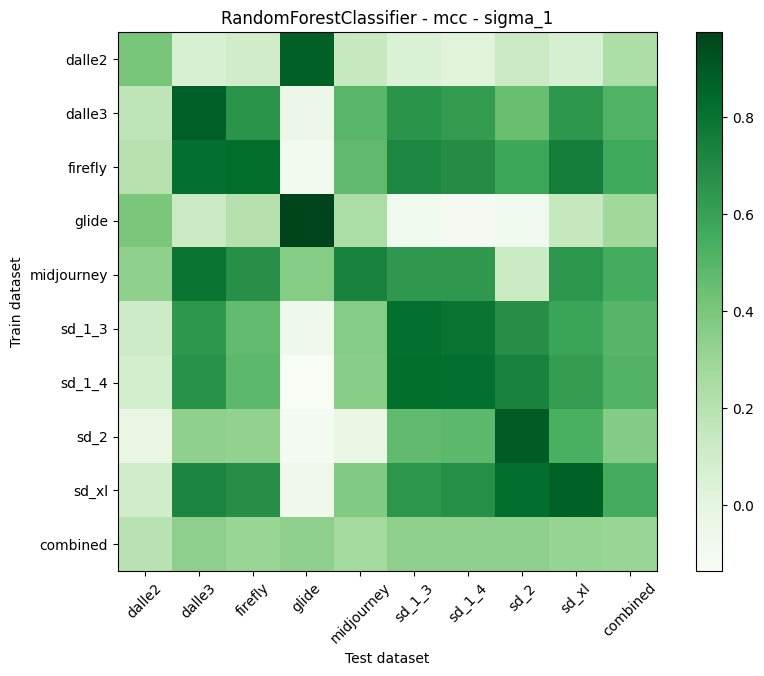

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.409823  0.061546  0.102422  0.877471    0.140028  0.047019   
dalle3         0.175581  0.880396  0.654597 -0.051640    0.495275  0.654597   
firefly        0.201918  0.815826  0.831498 -0.097322    0.470544  0.716084   
glide          0.399119  0.123300  0.202733  0.975305    0.238733 -0.082269   
midjourney     0.335936  0.795806  0.676906  0.363627    0.735083  0.639241   
sd_1_3         0.112022  0.641783  0.463455 -0.069886    0.364967  0.815500   
sd_1_4         0.090402  0.663325  0.482211 -0.136302    0.351747  0.826748   
sd_2          -0.022942  0.334795  0.325362 -0.108826   -0.022942  0.471599   
sd_xl          0.100868  0.721771  0.684152 -0.071715    0.376197  0.647324   
combined       0.196008  0.337944  0.303621  0.337944    0.271726  0.337944   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.016310  0.121581  0.068626  0.229995  
dalle3         0.619677  0.447914  0.641448  0.518092  
firefly        0.692219  0.577260  0.750150  0.560335  
glide         -0.112509 -0.082269  0.147377  0.278654  
midjourney     0.639241  0.125723  0.648585  0.550814  
sd_1_3         0.795089  0.683426  0.587477  0.501216  
sd_1_4         0.816235  0.735230  0.616981  0.508900  
sd_2           0.484278  0.895011  0.534634  0.369555  
sd_xl          0.674877  0.820369  0.872797  0.548386  
combined       0.337944  0.337944  0.314772  0.306076

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.409823  0.061546  0.102422  0.877471    0.140028  0.047019   
dalle3         0.175581  0.880396  0.654597 -0.051640    0.495275  0.654597   
firefly        0.201918  0.815826  0.831498 -0.097322    0.470544  0.716084   
glide          0.399119  0.123300  0.202733  0.975305    0.238733 -0.082269   
midjourney     0.335936  0.795806  0.676906  0.363627    0.735083  0.639241   
sd_1_3         0.112022  0.641783  0.463455 -0.069886    0.364967  0.815500   
sd_1_4         0.090402  0.663325  0.482211 -0.136302    0.351747  0.826748   
sd_2          -0.022942  0.334795  0.325362 -0.108826   -0.022942  0.471599   
sd_xl          0.100868  0.721771  0.684152 -0.071715    0.376197  0.647324   
combined       0.196008  0.337944  0.303621  0.337944    0.271726  0.337944   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.016310  0.121581  0.068626  0.204981  
dalle3         0.619677  0.447914  0.641448  0.501983  
firefly        0.692219  0.577260  0.750150  0.550908  
glide         -0.112509 -0.082269  0.147377  0.201058  
midjourney     0.639241  0.125723  0.648585  0.551128  
sd_1_3         0.795089  0.683426  0.587477  0.488204  
sd_1_4         0.816235  0.735230  0.616981  0.494064  
sd_2           0.484278  0.895011  0.534634  0.321219  
sd_xl          0.674877  0.820369  0.872797  0.536293  
combined       0.337944  0.337944  0.314772  0.308427

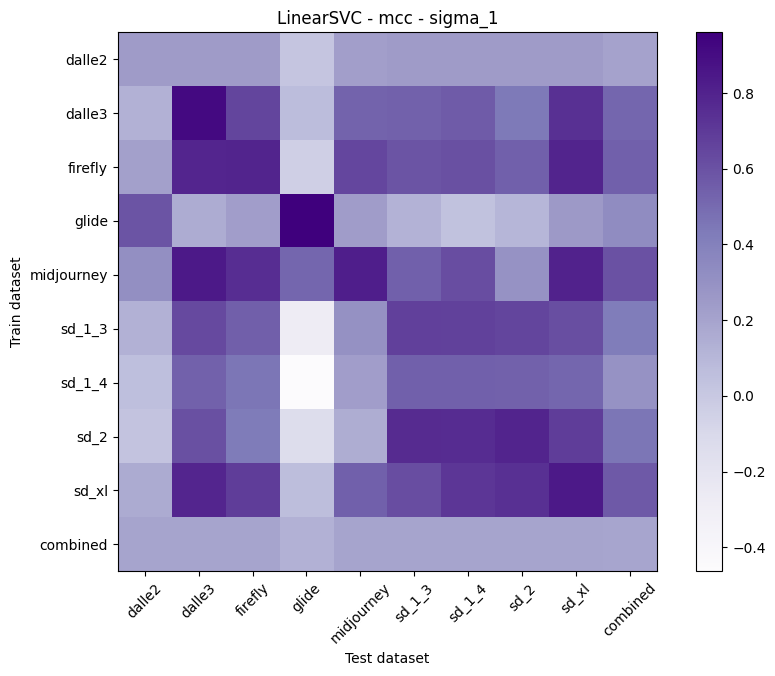

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.241249  0.241249  0.241249  0.016310    0.225520  0.241249   
dalle3         0.129628  0.912238  0.653197  0.066667    0.527380  0.535969   
firefly        0.216219  0.784286  0.790169 -0.044387    0.646367  0.590030   
glide          0.590519  0.158948  0.228345  0.960432    0.234061  0.121691   
midjourney     0.311708  0.838256  0.751354  0.518468    0.815896  0.541545   
sd_1_3         0.130946  0.633921  0.546054 -0.275317    0.300376  0.674200   
sd_1_4         0.055587  0.534655  0.451679 -0.463455    0.231400  0.542677   
sd_2           0.029165  0.606282  0.427838 -0.137402    0.152753  0.761166   
sd_xl          0.163903  0.785677  0.685214  0.063099    0.539229  0.620497   
combined       0.197386  0.197386  0.197386  0.129287    0.197386  0.197386   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.241249  0.241249  0.241249  0.205697  
dalle3         0.561767  0.436716  0.739086  0.515927  
firefly        0.605189  0.540433  0.790169  0.540977  
glide          0.037179  0.105269  0.250766  0.331579  
midjourney     0.616737  0.297513  0.799419  0.602445  
sd_1_3         0.667361  0.653838  0.614419  0.421974  
sd_1_4         0.542677  0.534655  0.518869  0.296711  
sd_2           0.755259  0.791212  0.686764  0.449160  
sd_xl          0.710889  0.742379  0.842260  0.568095  
combined       0.197386  0.197386  0.197386  0.188870

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.241249  0.241249  0.241249  0.016310    0.225520  0.241249   
dalle3         0.129628  0.912238  0.653197  0.066667    0.527380  0.535969   
firefly        0.216219  0.784286  0.790169 -0.044387    0.646367  0.590030   
glide          0.590519  0.158948  0.228345  0.960432    0.234061  0.121691   
midjourney     0.311708  0.838256  0.751354  0.518468    0.815896  0.541545   
sd_1_3         0.130946  0.633921  0.546054 -0.275317    0.300376  0.674200   
sd_1_4         0.055587  0.534655  0.451679 -0.463455    0.231400  0.542677   
sd_2           0.029165  0.606282  0.427838 -0.137402    0.152753  0.761166   
sd_xl          0.163903  0.785677  0.685214  0.063099    0.539229  0.620497   
combined       0.197386  0.197386  0.197386  0.129287    0.197386  0.197386   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.241249  0.241249  0.241249  0.214508  
dalle3         0.561767  0.436716  0.739086  0.506961  
firefly        0.605189  0.540433  0.790169  0.546497  
glide          0.037179  0.105269  0.250766  0.298579  
midjourney     0.616737  0.297513  0.799419  0.610099  
sd_1_3         0.667361  0.653838  0.614419  0.438422  
sd_1_4         0.542677  0.534655  0.518869  0.327638  
sd_2           0.755259  0.791212  0.686764  0.452560  
sd_xl          0.710889  0.742379  0.842260  0.572572  
combined       0.197386  0.197386  0.197386  0.189819









 ################ Evaluating models trained on standardAugmented and tested on sigma_2. ################


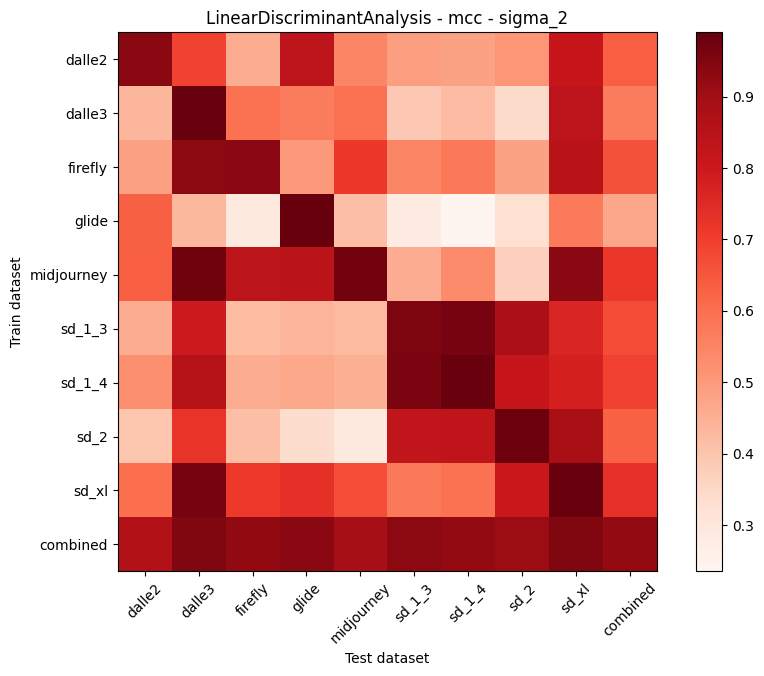

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.935012  0.689656  0.459188  0.834181    0.545658  0.488273   
dalle3         0.433650  0.985111  0.594160  0.570421    0.594160  0.391192   
firefly        0.484974  0.930047  0.935105  0.501557    0.713290  0.546844   
glide          0.632832  0.430105  0.289890  0.990050    0.413381  0.274272   
midjourney     0.635070  0.975110  0.837104  0.841601    0.970049  0.454135   
sd_1_3         0.458349  0.795909  0.420596  0.437500    0.424843  0.955012   
sd_1_4         0.526830  0.851680  0.454315  0.466577    0.450206  0.960048   
sd_2           0.395520  0.727001  0.416871  0.337299    0.288489  0.824970   
sd_xl          0.602081  0.965012  0.710534  0.735288    0.665883  0.578332   
combined       0.861077  0.950761  0.925104  0.935292    0.895101  0.930186   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.480000  0.508854  0.811364  0.634233  
dalle3         0.421089  0.341953  0.833812  0.571300  
firefly        0.579684  0.480814  0.847387  0.662009  
glide          0.235159  0.324387  0.573873  0.469179  
midjourney     0.535164  0.368562  0.935292  0.718460  
sd_1_3         0.965109  0.877471  0.761166  0.669061  
sd_1_4         0.985111  0.811817  0.777333  0.689682  
sd_2           0.829384  0.980049  0.883586  0.628108  
sd_xl          0.594160  0.803118  0.985111  0.731600  
combined       0.920046  0.910000  0.950761  0.919485

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.935012  0.689656  0.459188  0.834181    0.545658  0.488273   
dalle3         0.433650  0.985111  0.594160  0.570421    0.594160  0.391192   
firefly        0.484974  0.930047  0.935105  0.501557    0.713290  0.546844   
glide          0.632832  0.430105  0.289890  0.990050    0.413381  0.274272   
midjourney     0.635070  0.975110  0.837104  0.841601    0.970049  0.454135   
sd_1_3         0.458349  0.795909  0.420596  0.437500    0.424843  0.955012   
sd_1_4         0.526830  0.851680  0.454315  0.466577    0.450206  0.960048   
sd_2           0.395520  0.727001  0.416871  0.337299    0.288489  0.824970   
sd_xl          0.602081  0.965012  0.710534  0.735288    0.665883  0.578332   
combined       0.861077  0.950761  0.925104  0.935292    0.895101  0.930186   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.480000  0.508854  0.811364  0.639132  
dalle3         0.421089  0.341953  0.833812  0.573950  
firefly        0.579684  0.480814  0.847387  0.668856  
glide          0.235159  0.324387  0.573873  0.462661  
midjourney     0.535164  0.368562  0.935292  0.728010  
sd_1_3         0.965109  0.877471  0.761166  0.677328  
sd_1_4         0.985111  0.811817  0.777333  0.698213  
sd_2           0.829384  0.980049  0.883586  0.631463  
sd_xl          0.594160  0.803118  0.985111  0.737724  
combined       0.920046  0.910000  0.950761  0.919814

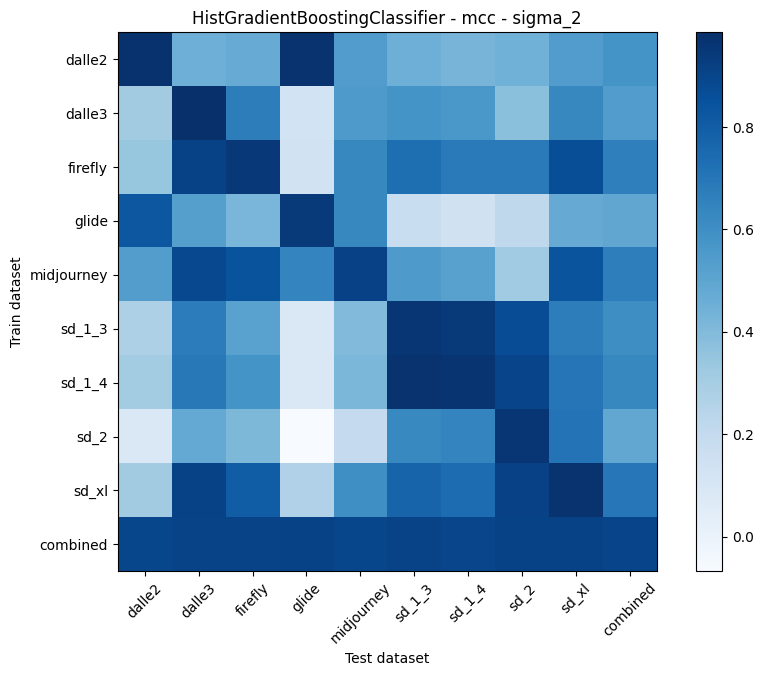

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975110  0.454135  0.470572  0.970049    0.539162  0.454135   
dalle3         0.314772  0.985012  0.668545  0.126886    0.550329  0.581717   
firefly        0.345395  0.910410  0.950048  0.134263    0.629837  0.733816   
glide          0.826251  0.527931  0.421464  0.941697    0.629262  0.178563   
midjourney     0.535797  0.885277  0.842066  0.643644    0.915011  0.552325   
sd_1_3         0.276916  0.673162  0.515572  0.086751    0.399119  0.960048   
sd_1_4         0.308563  0.690134  0.578332  0.087932    0.416871  0.970000   
sd_2           0.081619  0.482805  0.412205 -0.067505    0.195965  0.627036   
sd_xl          0.313458  0.906918  0.803118  0.267490    0.602081  0.773079   
combined       0.892862  0.903667  0.903667  0.909112    0.892862  0.903667   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.429143  0.445854  0.539162  0.579952  
dalle3         0.562106  0.374654  0.628885  0.540722  
firefly        0.683340  0.683340  0.862765  0.660812  
glide          0.140123  0.219476  0.473016  0.492329  
midjourney     0.519245  0.318507  0.837358  0.666565  
sd_1_3         0.945012  0.868142  0.669061  0.605022  
sd_1_4         0.965012  0.902213  0.702351  0.629435  
sd_2           0.643120  0.960000  0.712470  0.487768  
sd_xl          0.739445  0.911642  0.970000  0.694651  
combined       0.898251  0.909112  0.909112  0.902461

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975110  0.454135  0.470572  0.970049    0.539162  0.454135   
dalle3         0.314772  0.985012  0.668545  0.126886    0.550329  0.581717   
firefly        0.345395  0.910410  0.950048  0.134263    0.629837  0.733816   
glide          0.826251  0.527931  0.421464  0.941697    0.629262  0.178563   
midjourney     0.535797  0.885277  0.842066  0.643644    0.915011  0.552325   
sd_1_3         0.276916  0.673162  0.515572  0.086751    0.399119  0.960048   
sd_1_4         0.308563  0.690134  0.578332  0.087932    0.416871  0.970000   
sd_2           0.081619  0.482805  0.412205 -0.067505    0.195965  0.627036   
sd_xl          0.313458  0.906918  0.803118  0.267490    0.602081  0.773079   
combined       0.892862  0.903667  0.903667  0.909112    0.892862  0.903667   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.429143  0.445854  0.539162  0.586369  
dalle3         0.562106  0.374654  0.628885  0.532545  
firefly        0.683340  0.683340  0.862765  0.659246  
glide          0.140123  0.219476  0.473016  0.484198  
midjourney     0.519245  0.318507  0.837358  0.672137  
sd_1_3         0.945012  0.868142  0.669061  0.599309  
sd_1_4         0.965012  0.902213  0.702351  0.624601  
sd_2           0.643120  0.960000  0.712470  0.449746  
sd_xl          0.739445  0.911642  0.970000  0.698581  
combined       0.898251  0.909112  0.909112  0.902479

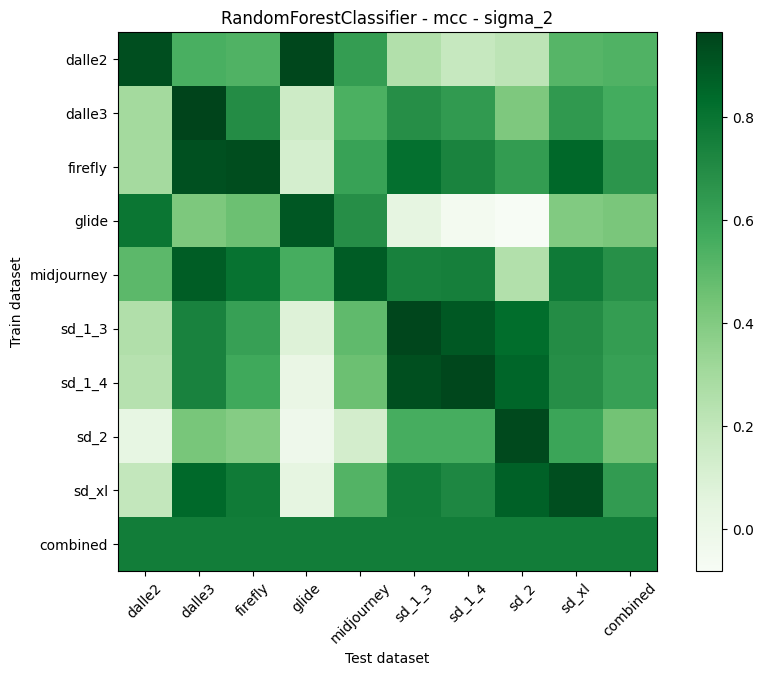

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.930186  0.548194  0.531662  0.950761    0.626915  0.252748   
dalle3         0.298630  0.965012  0.698271  0.152793    0.546673  0.690134   
firefly        0.297641  0.920046  0.935012  0.121691    0.606869  0.815896   
glide          0.790000  0.416628  0.460902  0.899975    0.688808  0.038818   
midjourney     0.502655  0.880000  0.802572  0.557370    0.885011  0.742851   
sd_1_3         0.255785  0.737476  0.615012  0.081619    0.490921  0.955012   
sd_1_4         0.239034  0.738083  0.577036  0.014098    0.458664  0.925104   
sd_2           0.032026  0.429143  0.390645 -0.019066    0.129287  0.559126   
sd_xl          0.194090  0.845857  0.771048  0.040564    0.526266  0.766505   
combined       0.762252  0.762252  0.762252  0.762252    0.762252  0.762252   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.183333  0.213621  0.519245  0.533041  
dalle3         0.641838  0.412637  0.645834  0.567784  
firefly        0.732121  0.631489  0.848069  0.658574  
glide         -0.052414 -0.081781  0.403229  0.424044  
midjourney     0.751883  0.252050  0.774701  0.679474  
sd_1_3         0.896897  0.828156  0.695973  0.625699  
sd_1_4         0.950048  0.853464  0.687500  0.616254  
sd_2           0.559126  0.945106  0.595026  0.442620  
sd_xl          0.717383  0.870174  0.930745  0.636360  
combined       0.762252  0.762252  0.762252  0.762252

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.930186  0.548194  0.531662  0.950761    0.626915  0.252748   
dalle3         0.298630  0.965012  0.698271  0.152793    0.546673  0.690134   
firefly        0.297641  0.920046  0.935012  0.121691    0.606869  0.815896   
glide          0.790000  0.416628  0.460902  0.899975    0.688808  0.038818   
midjourney     0.502655  0.880000  0.802572  0.557370    0.885011  0.742851   
sd_1_3         0.255785  0.737476  0.615012  0.081619    0.490921  0.955012   
sd_1_4         0.239034  0.738083  0.577036  0.014098    0.458664  0.925104   
sd_2           0.032026  0.429143  0.390645 -0.019066    0.129287  0.559126   
sd_xl          0.194090  0.845857  0.771048  0.040564    0.526266  0.766505   
combined       0.762252  0.762252  0.762252  0.762252    0.762252  0.762252   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.183333  0.213621  0.519245  0.528518  
dalle3         0.641838  0.412637  0.645834  0.561313  
firefly        0.732121  0.631489  0.848069  0.656537  
glide         -0.052414 -0.081781  0.403229  0.396018  
midjourney     0.751883  0.252050  0.774701  0.683233  
sd_1_3         0.896897  0.828156  0.695973  0.617428  
sd_1_4         0.950048  0.853464  0.687500  0.604781  
sd_2           0.559126  0.945106  0.595026  0.402269  
sd_xl          0.717383  0.870174  0.930745  0.629181  
combined       0.762252  0.762252  0.762252  0.762252

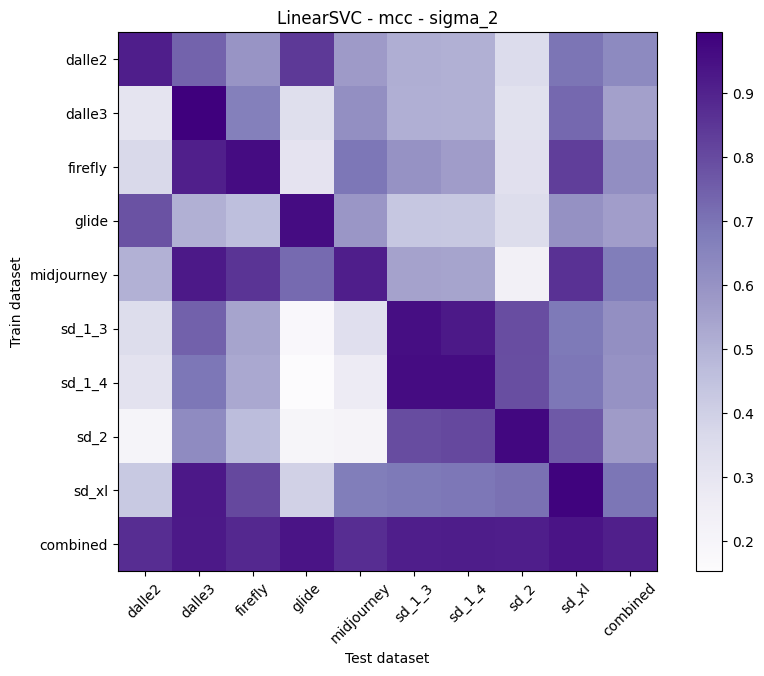

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.910046  0.739190  0.592014  0.842701    0.571471  0.513944   
dalle3         0.306942  0.995012  0.663413  0.335581    0.612474  0.511170   
firefly        0.364742  0.906918  0.960048  0.308563    0.690134  0.602081   
glide          0.778811  0.505690  0.459907  0.960769    0.583792  0.430256   
midjourney     0.503903  0.925289  0.855867  0.723173    0.910046  0.549701   
sd_1_3         0.345456  0.744079  0.543807  0.176369    0.331424  0.955012   
sd_1_4         0.318308  0.690134  0.530804  0.152793    0.267490  0.960048   
sd_2           0.202818  0.625897  0.466577  0.196231    0.209258  0.794472   
sd_xl          0.422797  0.926960  0.806290  0.393349    0.675276  0.683213   
combined       0.870174  0.925567  0.885011  0.935948    0.870174  0.910182   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.505690  0.350701  0.696219  0.632379  
dalle3         0.507240  0.326207  0.727370  0.554568  
firefly        0.566465  0.327881  0.829384  0.614860  
glide          0.425975  0.346083  0.604364  0.563262  
midjourney     0.541388  0.232361  0.860689  0.672741  
sd_1_3         0.925289  0.791521  0.685507  0.612190  
sd_1_4         0.960048  0.790169  0.690134  0.600321  
sd_2           0.807460  0.975012  0.764605  0.570421  
sd_xl          0.691177  0.707186  0.985012  0.693393  
combined       0.915286  0.910182  0.935948  0.906229

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.910046  0.739190  0.592014  0.842701    0.571471  0.513944   
dalle3         0.306942  0.995012  0.663413  0.335581    0.612474  0.511170   
firefly        0.364742  0.906918  0.960048  0.308563    0.690134  0.602081   
glide          0.778811  0.505690  0.459907  0.960769    0.583792  0.430256   
midjourney     0.503903  0.925289  0.855867  0.723173    0.910046  0.549701   
sd_1_3         0.345456  0.744079  0.543807  0.176369    0.331424  0.955012   
sd_1_4         0.318308  0.690134  0.530804  0.152793    0.267490  0.960048   
sd_2           0.202818  0.625897  0.466577  0.196231    0.209258  0.794472   
sd_xl          0.422797  0.926960  0.806290  0.393349    0.675276  0.683213   
combined       0.870174  0.925567  0.885011  0.935948    0.870174  0.910182   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.505690  0.350701  0.696219  0.635775  
dalle3         0.507240  0.326207  0.727370  0.553934  
firefly        0.566465  0.327881  0.829384  0.617357  
glide          0.425975  0.346083  0.604364  0.566183  
midjourney     0.541388  0.232361  0.860689  0.678046  
sd_1_3         0.925289  0.791521  0.685507  0.610941  
sd_1_4         0.960048  0.790169  0.690134  0.595547  
sd_2           0.807460  0.975012  0.764605  0.560259  
sd_xl          0.691177  0.707186  0.985012  0.699029  
combined       0.915286  0.910182  0.935948  0.906497









 ################ Evaluating models trained on standardAugmented and tested on sigma_3. ################


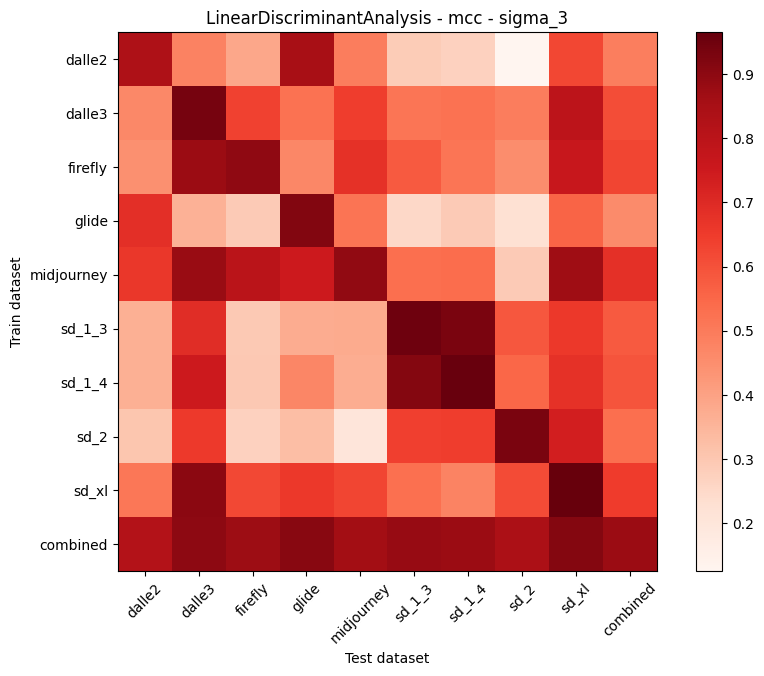

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.833382  0.480814  0.386797  0.847387    0.493276  0.288195   
dalle3         0.466035  0.936981  0.636026  0.525508    0.644647  0.512812   
firefly        0.446171  0.875098  0.895549  0.467707    0.678016  0.578499   
glide          0.683258  0.358359  0.292388  0.918323    0.516726  0.252423   
midjourney     0.660178  0.878975  0.800160  0.750338    0.889919  0.529672   
sd_1_3         0.364073  0.691868  0.292739  0.373026    0.377466  0.950048   
sd_1_4         0.363704  0.750949  0.297351  0.471115    0.368216  0.915286   
sd_2           0.303621  0.653838  0.272837  0.327881    0.202818  0.637847   
sd_xl          0.511524  0.901127  0.620264  0.656793    0.624306  0.527691   
combined       0.820000  0.897528  0.871090  0.908287    0.860689  0.881588   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.272834  0.125331  0.620875  0.492355  
dalle3         0.525508  0.495855  0.792540  0.610786  
firefly        0.514673  0.450492  0.763829  0.624725  
glide          0.292388  0.226285  0.555591  0.457100  
midjourney     0.538520  0.289992  0.868142  0.681866  
sd_1_3         0.930419  0.587044  0.659276  0.579066  
sd_1_4         0.960192  0.548695  0.679187  0.591890  
sd_2           0.645834  0.930745  0.735288  0.531687  
sd_xl          0.478947  0.612190  0.965109  0.650000  
combined       0.876326  0.840168  0.913708  0.873996

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.833382  0.480814  0.386797  0.847387    0.493276  0.288195   
dalle3         0.466035  0.936981  0.636026  0.525508    0.644647  0.512812   
firefly        0.446171  0.875098  0.895549  0.467707    0.678016  0.578499   
glide          0.683258  0.358359  0.292388  0.918323    0.516726  0.252423   
midjourney     0.660178  0.878975  0.800160  0.750338    0.889919  0.529672   
sd_1_3         0.364073  0.691868  0.292739  0.373026    0.377466  0.950048   
sd_1_4         0.363704  0.750949  0.297351  0.471115    0.368216  0.915286   
sd_2           0.303621  0.653838  0.272837  0.327881    0.202818  0.637847   
sd_xl          0.511524  0.901127  0.620264  0.656793    0.624306  0.527691   
combined       0.820000  0.897528  0.871090  0.908287    0.860689  0.881588   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.272834  0.125331  0.620875  0.483210  
dalle3         0.525508  0.495855  0.792540  0.615101  
firefly        0.514673  0.450492  0.763829  0.630004  
glide          0.292388  0.226285  0.555591  0.455082  
midjourney     0.538520  0.289992  0.868142  0.689544  
sd_1_3         0.930419  0.587044  0.659276  0.580662  
sd_1_4         0.960192  0.548695  0.679187  0.594966  
sd_2           0.645834  0.930745  0.735288  0.523412  
sd_xl          0.478947  0.612190  0.965109  0.655328  
combined       0.876326  0.840168  0.913708  0.874376

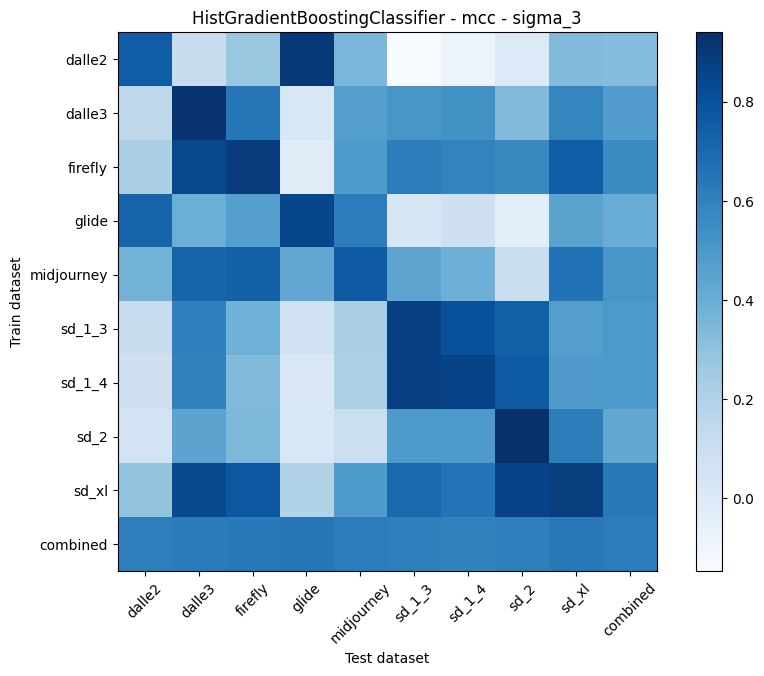

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.751354  0.110609  0.277424  0.898251    0.357957 -0.147377   
dalle3         0.150000  0.920414  0.639663  0.021054    0.471599  0.509510   
firefly        0.218361  0.840168  0.886876 -0.017929    0.488718  0.615069   
glide          0.720902  0.392466  0.465895  0.846604    0.620776  0.026318   
midjourney     0.372920  0.722637  0.739527  0.429540    0.762453  0.439019   
sd_1_3         0.109659  0.601354  0.381612  0.061965    0.221680  0.872139   
sd_1_4         0.075173  0.596128  0.336763  0.012393    0.212035  0.875887   
sd_2           0.050572  0.446086  0.346573  0.019066    0.087932  0.490855   
sd_xl          0.290132  0.836770  0.776590  0.191761    0.487160  0.701403   
combined       0.612190  0.625897  0.632832  0.646869    0.619017  0.612190   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2        -0.086767  0.000000  0.334860  0.320268  
dalle3         0.530451  0.334795  0.580650  0.477710  
firefly        0.588693  0.562500  0.747104  0.555731  
glide          0.075719 -0.034770  0.447533  0.404719  
midjourney     0.391762  0.097197  0.668021  0.507147  
sd_1_3         0.807957  0.738083  0.471115  0.496716  
sd_1_4         0.856812  0.756677  0.484974  0.493276  
sd_2           0.494875  0.940423  0.613978  0.427619  
sd_xl          0.658544  0.860689  0.885100  0.631775  
combined       0.598689  0.612190  0.632832  0.621304

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.751354  0.110609  0.277424  0.898251    0.357957 -0.147377   
dalle3         0.150000  0.920414  0.639663  0.021054    0.471599  0.509510   
firefly        0.218361  0.840168  0.886876 -0.017929    0.488718  0.615069   
glide          0.720902  0.392466  0.465895  0.846604    0.620776  0.026318   
midjourney     0.372920  0.722637  0.739527  0.429540    0.762453  0.439019   
sd_1_3         0.109659  0.601354  0.381612  0.061965    0.221680  0.872139   
sd_1_4         0.075173  0.596128  0.336763  0.012393    0.212035  0.875887   
sd_2           0.050572  0.446086  0.346573  0.019066    0.087932  0.490855   
sd_xl          0.290132  0.836770  0.776590  0.191761    0.487160  0.701403   
combined       0.612190  0.625897  0.632832  0.646869    0.619017  0.612190   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2        -0.086767  0.000000  0.334860  0.277368  
dalle3         0.530451  0.334795  0.580650  0.462015  
firefly        0.588693  0.562500  0.747104  0.547729  
glide          0.075719 -0.034770  0.447533  0.395716  
midjourney     0.391762  0.097197  0.668021  0.513675  
sd_1_3         0.807957  0.738083  0.471115  0.473952  
sd_1_4         0.856812  0.756677  0.484974  0.467427  
sd_2           0.494875  0.940423  0.613978  0.387818  
sd_xl          0.658544  0.860689  0.885100  0.632016  
combined       0.598689  0.612190  0.632832  0.621412

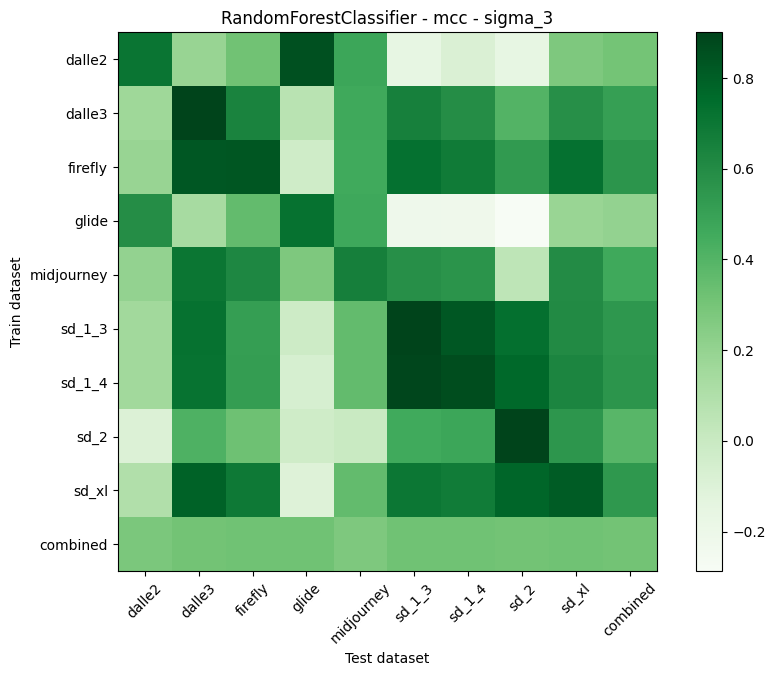

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.710000  0.186332  0.314850  0.852807    0.475086 -0.160128   
dalle3         0.163036  0.900405  0.640333  0.063607    0.461754  0.653295   
firefly        0.189298  0.826748  0.832041 -0.031960    0.455518  0.725444   
glide          0.593228  0.133914  0.355040  0.721743    0.467113 -0.215526   
midjourney     0.201667  0.704736  0.617961  0.269655    0.657624  0.584964   
sd_1_3         0.150326  0.723747  0.512812 -0.021054    0.355996  0.900405   
sd_1_4         0.150326  0.719266  0.517046 -0.068825    0.355996  0.890178   
sd_2          -0.095329  0.416456  0.321831 -0.032026    0.000000  0.458664   
sd_xl          0.095470  0.785481  0.691245 -0.102314    0.354441  0.700877   
combined       0.283333  0.306942  0.319262  0.319262    0.272004  0.319262   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2        -0.085400 -0.160128  0.271903  0.302778  
dalle3         0.593268  0.400945  0.584770  0.506693  
firefly        0.682187  0.531189  0.725444  0.553562  
glide         -0.222396 -0.287500  0.183340  0.202954  
midjourney     0.558085  0.043856  0.601355  0.463375  
sd_1_3         0.830665  0.732744  0.606044  0.547122  
sd_1_4         0.865011  0.764640  0.627432  0.553231  
sd_2           0.475248  0.900721  0.548695  0.389458  
sd_xl          0.676906  0.775242  0.811462  0.542811  
combined       0.319262  0.306942  0.319262  0.306942

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.710000  0.186332  0.314850  0.852807    0.475086 -0.160128   
dalle3         0.163036  0.900405  0.640333  0.063607    0.461754  0.653295   
firefly        0.189298  0.826748  0.832041 -0.031960    0.455518  0.725444   
glide          0.593228  0.133914  0.355040  0.721743    0.467113 -0.215526   
midjourney     0.201667  0.704736  0.617961  0.269655    0.657624  0.584964   
sd_1_3         0.150326  0.723747  0.512812 -0.021054    0.355996  0.900405   
sd_1_4         0.150326  0.719266  0.517046 -0.068825    0.355996  0.890178   
sd_2          -0.095329  0.416456  0.321831 -0.032026    0.000000  0.458664   
sd_xl          0.095470  0.785481  0.691245 -0.102314    0.354441  0.700877   
combined       0.283333  0.306942  0.319262  0.319262    0.272004  0.319262   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2        -0.085400 -0.160128  0.271903  0.267258  
dalle3         0.593268  0.400945  0.584770  0.495713  
firefly        0.682187  0.531189  0.725444  0.548434  
glide         -0.222396 -0.287500  0.183340  0.192106  
midjourney     0.558085  0.043856  0.601355  0.471100  
sd_1_3         0.830665  0.732744  0.606044  0.532409  
sd_1_4         0.865011  0.764640  0.627432  0.535674  
sd_2           0.475248  0.900721  0.548695  0.332696  
sd_xl          0.676906  0.775242  0.811462  0.532090  
combined       0.319262  0.306942  0.319262  0.307281

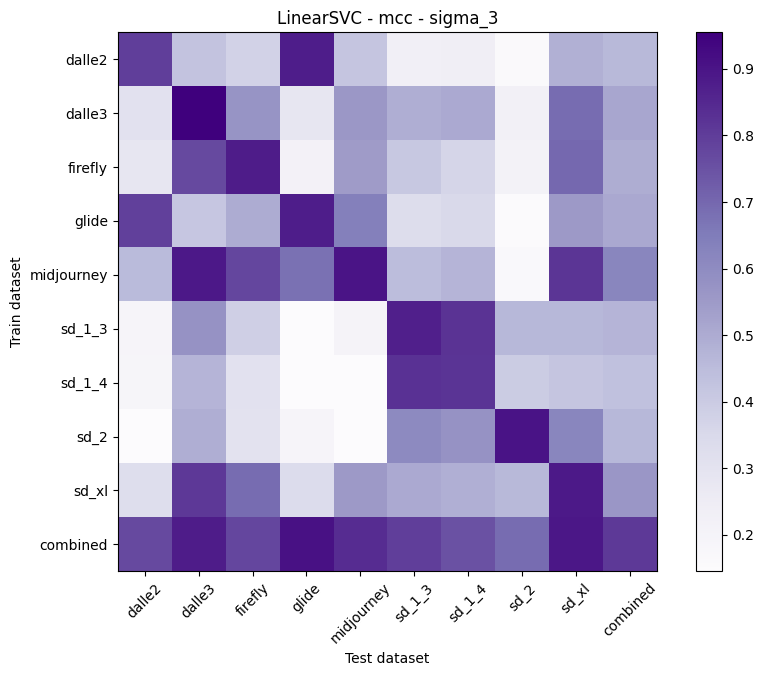

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.795395  0.424195  0.373632  0.877446    0.420084  0.229416   
dalle3         0.307266  0.955107  0.568939  0.282131    0.556794  0.491708   
firefly        0.282112  0.769777  0.882164  0.215145    0.543807  0.407761   
glide          0.790989  0.416333  0.497096  0.877446    0.638530  0.329414   
midjourney     0.454805  0.890401  0.777815  0.678016    0.900721  0.446171   
sd_1_3         0.189484  0.578332  0.382470  0.144715    0.196231  0.869808   
sd_1_4         0.185895  0.471577  0.306942  0.146553    0.146553  0.827774   
sd_2           0.144749  0.491029  0.300000  0.190555    0.144749  0.605266   
sd_xl          0.327086  0.810441  0.687771  0.336529    0.551145  0.503047   
combined       0.770964  0.881588  0.775786  0.908287    0.840168  0.795249   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.235391  0.160128  0.484322  0.458793  
dalle3         0.503986  0.221680  0.687500  0.512599  
firefly        0.363740  0.208996  0.697917  0.495284  
glide          0.347992  0.152944  0.551135  0.508564  
midjourney     0.471996  0.166304  0.815826  0.619454  
sd_1_3         0.824970  0.462500  0.462500  0.473802  
sd_1_4         0.819140  0.397613  0.418644  0.435620  
sd_2           0.577795  0.902894  0.617063  0.463338  
sd_xl          0.486866  0.458259  0.887500  0.560899  
combined       0.751844  0.686764  0.892189  0.809490

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.795395  0.424195  0.373632  0.877446    0.420084  0.229416   
dalle3         0.307266  0.955107  0.568939  0.282131    0.556794  0.491708   
firefly        0.282112  0.769777  0.882164  0.215145    0.543807  0.407761   
glide          0.790989  0.416333  0.497096  0.877446    0.638530  0.329414   
midjourney     0.454805  0.890401  0.777815  0.678016    0.900721  0.446171   
sd_1_3         0.189484  0.578332  0.382470  0.144715    0.196231  0.869808   
sd_1_4         0.185895  0.471577  0.306942  0.146553    0.146553  0.827774   
sd_2           0.144749  0.491029  0.300000  0.190555    0.144749  0.605266   
sd_xl          0.327086  0.810441  0.687771  0.336529    0.551145  0.503047   
combined       0.770964  0.881588  0.775786  0.908287    0.840168  0.795249   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.235391  0.160128  0.484322  0.444445  
dalle3         0.503986  0.221680  0.687500  0.508346  
firefly        0.363740  0.208996  0.697917  0.485713  
glide          0.347992  0.152944  0.551135  0.511320  
midjourney     0.471996  0.166304  0.815826  0.622451  
sd_1_3         0.824970  0.462500  0.462500  0.456779  
sd_1_4         0.819140  0.397613  0.418644  0.413410  
sd_2           0.577795  0.902894  0.617063  0.441567  
sd_xl          0.486866  0.458259  0.887500  0.560960  
combined       0.751844  0.686764  0.892189  0.811427

In [18]:
print("########################### MCC ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "mcc"
    evaluation_data_name = "Test"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)